# Sleep Prediction
Here we try to use environmental parameters in addition to mood and activity characteristics to see if we are able to predict sleep quality.

## Features
In this analysis, we are going to consider the following features:
1. **Acitivity**: The main metrics for activity that we will use are:
    * Daily Steps
    * Intensity Levels
2. **Mood**: We have five metrics for mood:
    * Content
    * Lonely
    * Sadness
    * Stress
    * Energy Level 
3. **IEQ**: There are many measurements of IEQ that we consider:
    * CO$_2$
    * CO
    * PM$_{2.5}$
    * NO$_2$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:
1. **Self-Report**: There are four metrics for self-report sleep quality reported via EMA:
    * TST
    * SOL
    * NAW
    * Restfulness
2. **Fitbit-Measured**: There are also four metrics of sleep quality that we can use from Fitbit:
    * TST
    * SE
    * REM Percentage
    * Light Percentage
    * Deep Percentage

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plottings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [3]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw.drop(["home","increasing_co2","ema","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2"],axis="columns",inplace=True)
ieq_raw = ieq_raw.groupby(["beacon","beiwe","redcap","start_time","end_time"]).median()
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq = ieq_raw.copy()
ieq.head()

beacon     beiwe  redcap          start_time            end_time  \
0       1  kyj367pi      10 2020-06-10 23:05:00 2020-06-11 09:14:00   
1       1  kyj367pi      10 2020-06-11 23:12:30 2020-06-12 09:14:30   
2       1  kyj367pi      10 2020-06-17 22:55:30 2020-06-18 08:51:30   
3       1  kyj367pi      10 2020-06-18 22:13:30 2020-06-19 08:42:00   
4       1  kyj367pi      10 2020-06-20 23:06:30 2020-06-21 07:43:00   

   tvoc_median    lux_median  co_median  co2_median  pm2p5_mass_median  \
0    71.566667  4.958996e-16   1.607322  506.381100           4.176611   
1   216.916667  4.958996e-16   1.169600  530.170098          10.268426   
2   319.646667  4.958996e-16   0.591232  515.493173           5.591069   
3   309.186667  4.958996e-16   0.086787  496.541909           5.670253   
4   316.976667  4.958996e-16   0.247670  482.574615           3.976247   

   temperature_c_median  rh_median  
0             28.000000  39.483333  
1             27.500000  40.436667  
2             27.588333  45.706667  
3             28.450000  46.830000  
4             28.000000  47.862500

<div class="alert alert-block alert-danger">
 
Since we have so many `nan` values and even the values we have are not very exciting, we leave out the `no2` measurements.
    
</div>

## Feature: Activity
Activity data are essentially untouched from the raw format

In [4]:
activity_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
activity = activity_raw[["timestamp","beiwe","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]]
activity.rename({"timestamp":"date"},axis="columns",inplace=True)
activity.head()

date     beiwe  steps  sedentary_minutes  lightly_active_minutes  \
0 2020-05-13  hfttkth7   9207               1241                      70   
1 2020-05-14  hfttkth7  15207                614                     263   
2 2020-05-15  hfttkth7  14556                577                     205   
3 2020-05-16  hfttkth7  18453                760                     176   
4 2020-05-17  hfttkth7  15425                605                     207   

   fairly_active_minutes  very_active_minutes  
0                    118                   11  
1                    134                   23  
2                     57                  108  
3                     24                  151  
4                     50                  131

## Feature: Mood
We only want to consider mood data from the latest survey prior to the participant going to sleep so we only important the evening EMAs.

In [5]:
mood = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
mood["date"] = pd.to_datetime(mood["timestamp"].dt.date)
mood.head()

timestamp     beiwe  content  stress  lonely  sad  energy  redcap  \
0 2020-05-13 19:00:23  awa8uces      1.0     1.0     1.0  3.0     2.0      28   
1 2020-05-13 19:21:32  lkkjddam      0.0     2.0     3.0  1.0     0.0      12   
2 2020-05-13 19:30:38  rvhdl2la      2.0     1.0     0.0  0.0     1.0      29   
3 2020-05-13 20:07:04  xxvnhauv      1.0     3.0     1.0  2.0     0.0      21   
4 2020-05-13 20:25:07  xdbdrk6e      2.0     1.0     2.0  1.0     3.0      23   

   beacon       date  
0    26.0 2020-05-13  
1    21.0 2020-05-13  
2     NaN 2020-05-13  
3    22.0 2020-05-13  
4    24.0 2020-05-13

## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [6]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.rename({"date":"end_date"},axis="columns",inplace=True)
srsq.head()

timestamp   end_date     beiwe  redcap  beacon  tst   sol  naw  \
0 2020-05-13 09:10:27 2020-05-13  qh34m4r9      68    19.0  8.0  20.0  2.0   
1 2020-05-13 09:15:49 2020-05-13  awa8uces      28    26.0  2.0  10.0  3.0   
2 2020-05-13 09:42:19 2020-05-13  xxvnhauv      21    22.0  6.0  30.0  3.0   
3 2020-05-13 09:43:27 2020-05-13  rvhdl2la      29     NaN  5.3   5.0  2.0   
4 2020-05-13 10:11:51 2020-05-13  q5y11ytm      48     NaN  2.0  10.0  0.0   

   restful  
0      3.0  
1      1.0  
2      1.0  
3      2.0  
4      0.0

## Target: Fitbit Sleep Quality (FBSQ)
Fitbit sleep summary data is imported below.

In [7]:
fbsq_raw = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)
fbsq = fbsq_raw[["start_time","end_time","start_date","end_date","beiwe","redcap","beacon","tst_fb","efficiency","rem_percent","light_percent","deep_percent"]]
fbsq.rename({"tst_fb":"tst","efficiency":"se"},axis="columns",inplace=True)
fbsq.head()

start_time            end_time start_date   end_date     beiwe  \
0 2020-05-14 00:27:00 2020-05-14 07:13:00 2020-05-14 2020-05-14  hfttkth7   
1 2020-05-14 23:53:30 2020-05-15 08:06:30 2020-05-14 2020-05-15  hfttkth7   
2 2020-05-15 23:28:00 2020-05-16 04:57:00 2020-05-15 2020-05-16  hfttkth7   
3 2020-05-17 02:01:30 2020-05-17 09:28:30 2020-05-17 2020-05-17  hfttkth7   
4 2020-05-18 00:24:00 2020-05-18 07:20:00 2020-05-18 2020-05-18  hfttkth7   

   redcap  beacon       tst         se  rem_percent  light_percent  \
0     NaN     NaN  6.316667  93.349754     0.216359       0.562005   
1     NaN     NaN  6.533333  79.513185     0.119898       0.637755   
2     NaN     NaN  4.783333  87.234043     0.174216       0.662021   
3     NaN     NaN  6.716667  90.156600     0.205955       0.600496   
4     NaN     NaN  5.850000  84.375000     0.250712       0.475783   

   deep_percent  
0      0.221636  
1      0.242347  
2      0.163763  
3      0.193548  
4      0.273504

## Target: Combined Sleep Quality (CSQ)
The sleep quality dataset has already been created from a previous analysis so we simply just have to import it.

I don't think we will be using this dataset, but we might as well keep it here.

In [8]:
sleep_quality = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date","date"],infer_datetime_format=True)
csq = sleep_quality[["start_time","end_time","start_date","end_date","date","beiwe","redcap","beacon","tst_ema","sol_ema","naw_ema","restful_ema","tst_fb","efficiency","rem_percent","nrem_percent"]]
csq.head() # Combined Sleep Quality (csq)

start_time            end_time start_date   end_date       date  \
0 2020-05-14 01:06:00 2020-05-14 11:39:30 2020-05-14 2020-05-14 2020-05-14   
1 2020-05-16 02:19:00 2020-05-16 10:00:30 2020-05-16 2020-05-16 2020-05-16   
2 2020-05-17 00:27:00 2020-05-17 10:28:00 2020-05-17 2020-05-17 2020-05-17   
3 2020-05-18 01:37:00 2020-05-18 10:59:30 2020-05-18 2020-05-18 2020-05-18   
4 2020-05-21 23:59:30 2020-05-22 09:27:30 2020-05-21 2020-05-22 2020-05-22   

      beiwe  redcap  beacon  tst_ema  sol_ema  naw_ema  restful_ema    tst_fb  \
0  15tejjtw    45.0     NaN      9.0     30.0      5.0          2.0  8.766667   
1  15tejjtw    45.0     NaN      9.0     15.0      2.0          2.0  6.600000   
2  15tejjtw    45.0     NaN      9.0     30.0      1.0          2.0  8.850000   
3  15tejjtw    45.0     NaN      9.0     25.0      2.0          1.0  7.966667   
4  15tejjtw    45.0     NaN      9.0     20.0      2.0          2.0  8.316667   

   efficiency  rem_percent  nrem_percent  
0   83.096367     0.231939      0.768061  
1   85.900217     0.123737      0.876263  
2   88.352745     0.254237      0.745763  
3   85.053381     0.207113      0.792887  
4   87.852113     0.264529      0.735471

<a id="encoding" ></a>

# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

In [9]:
def plot_distribution(df, variable,**kwargs):
    """plots distribution of values"""
    fig, ax = plt.subplots(figsize=(12,4))
    # density plot
    sns.kdeplot(x=variable,cut=0,data=df,zorder=2,
                linewidth=3,color="black",ax=ax)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.upper(),fontsize=16)
    if "xlim" in kwargs.keys():
        ax.set_xlim(kwargs["xlim"])
    else:
        ax.set_xlim([0,max(df[variable])])
    # cumulative
    ax2 = ax.twinx()
    sns.kdeplot(x=variable,cut=0,data=df,cumulative=True,zorder=1,
                linewidth=2,color="firebrick",ax=ax2)
    # y-axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,1])
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["left","top"]:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## SE
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |



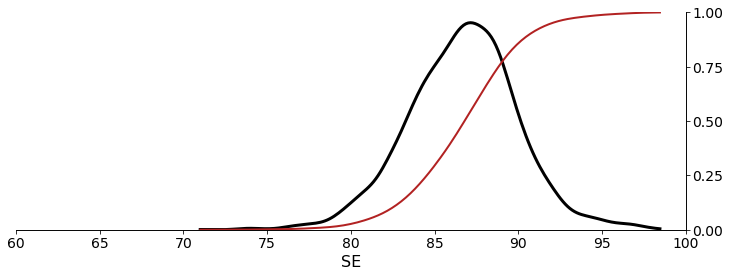

In [10]:
plot_distribution(fbsq,"se",xlim=[60,100])

Here, we just say the SE is good (1) when above 85%, otherwise it is bad (0).

In [11]:
def encode_se(value):
    """returns encoded value for se"""
    if value >= 85:
        return 1
    else:
        return 0

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [12]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## REM
Ideally you should be spending between 20% and 25% of your night in REM sleep.

In [13]:
def encode_rem(value):
    """returns score of REM percent"""
    if value >= 0.2 and value <= 0.25:
        return 1
    else:
        return 0

## Light Sleep
Light Sleep should be a maximum of about 60% but we also don't want too little. 

In [14]:
def encode_light(value):
    """returns score of light percent"""
    if value >= 0.4 and value <= 0.6:
        return 1
    else:
        return 0

## Deep Sleep
Deep sleep should encompass about 12% to 23% of your night.

In [15]:
def encode_deep(value):
    """returns score of deep percent"""
    if value >= 0.12 and value <= 0.23:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality. However, looking at the distribution of values, perhaps we should alter that threshold since many of the participants fall asleep faster than that.

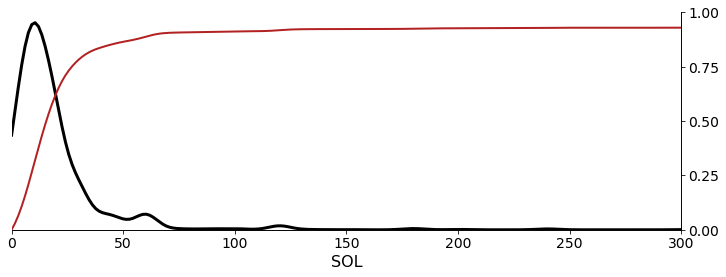

In [16]:
plot_distribution(srsq,"sol")

In [17]:
def encode_sol(value):
    """returns score of sol"""
    if value < 15:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [18]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [19]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Sleep Quality

### Self-Report Sleep
We start with self-report metrics of sleep quality.

In [20]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

timestamp   end_date     beiwe  redcap  beacon  tst   sol  naw  \
0 2020-05-13 09:10:27 2020-05-13  qh34m4r9      68    19.0  8.0  20.0  2.0   
1 2020-05-13 09:15:49 2020-05-13  awa8uces      28    26.0  2.0  10.0  3.0   
2 2020-05-13 09:42:19 2020-05-13  xxvnhauv      21    22.0  6.0  30.0  3.0   
3 2020-05-13 09:43:27 2020-05-13  rvhdl2la      29     NaN  5.3   5.0  2.0   
4 2020-05-13 10:11:51 2020-05-13  q5y11ytm      48     NaN  2.0  10.0  0.0   

   restful  tst_binary  sol_binary  naw_binary  restful_binary  
0      3.0           1           0           0               1  
1      1.0           0           1           0               0  
2      1.0           0           0           0               0  
3      2.0           0           1           0               1  
4      0.0           0           1           1               0

### Fitbit Sleep
And now Fitbit-measured sleep quality.

In [21]:
for sm, f in zip(["tst","se","rem_percent","light_percent","deep_percent"], [encode_tst,encode_se,encode_rem,encode_light,encode_deep]):
    fbsq[f"{sm}_binary"] = fbsq.apply(lambda x: f(x[sm]), axis="columns")
    
fbsq.head()

start_time            end_time start_date   end_date     beiwe  \
0 2020-05-14 00:27:00 2020-05-14 07:13:00 2020-05-14 2020-05-14  hfttkth7   
1 2020-05-14 23:53:30 2020-05-15 08:06:30 2020-05-14 2020-05-15  hfttkth7   
2 2020-05-15 23:28:00 2020-05-16 04:57:00 2020-05-15 2020-05-16  hfttkth7   
3 2020-05-17 02:01:30 2020-05-17 09:28:30 2020-05-17 2020-05-17  hfttkth7   
4 2020-05-18 00:24:00 2020-05-18 07:20:00 2020-05-18 2020-05-18  hfttkth7   

   redcap  beacon       tst         se  rem_percent  light_percent  \
0     NaN     NaN  6.316667  93.349754     0.216359       0.562005   
1     NaN     NaN  6.533333  79.513185     0.119898       0.637755   
2     NaN     NaN  4.783333  87.234043     0.174216       0.662021   
3     NaN     NaN  6.716667  90.156600     0.205955       0.600496   
4     NaN     NaN  5.850000  84.375000     0.250712       0.475783   

   deep_percent  tst_binary  se_binary  rem_percent_binary  \
0      0.221636           0          1                   1   
1      0.242347           0          0                   0   
2      0.163763           0          1                   0   
3      0.193548           0          1                   1   
4      0.273504           0          0                   0   

   light_percent_binary  deep_percent_binary  
0                     1                    1  
1                     0                    0  
2                     0                    1  
3                     0                    1  
4                     1                    0

<a id="feature_engineering" ></a>

# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding
We encode each of the features into a binary outcome.

### Activity

#### Activity Level
Encoding the activity levels can be accomplished by looking at recommendations from the American College of Sports Medicine. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories that are not exactly the same label as what the ACSM states. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6 (ACSM Moderate)
* Very: > 6 (ACSM Vigorous)

We look on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day. Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [22]:
def encode_activity_level(row, moderate_threshold=30):
    """returns score of activity level"""
    if row["fairly_active_minutes"] + row["very_active_minutes"]*2 > moderate_threshold:
        return 1
    else:
        return 0

#### Number of Steps
An attainable goal that all adults should strive for is about 10,000 steps a day

In [23]:
def econde_steps(value):
    if value > 10000:
        return 1
    else:
        return 0

In [24]:
activity["active_binary"] = activity.apply(lambda row: encode_activity_level(row), axis="columns")
activity["steps_binary"] = activity.apply(lambda x: econde_steps(x["steps"]), axis="columns")
activity.head()

date     beiwe  steps  sedentary_minutes  lightly_active_minutes  \
0 2020-05-13  hfttkth7   9207               1241                      70   
1 2020-05-14  hfttkth7  15207                614                     263   
2 2020-05-15  hfttkth7  14556                577                     205   
3 2020-05-16  hfttkth7  18453                760                     176   
4 2020-05-17  hfttkth7  15425                605                     207   

   fairly_active_minutes  very_active_minutes  active_binary  steps_binary  
0                    118                   11              1             0  
1                    134                   23              1             1  
2                     57                  108              1             1  
3                     24                  151              1             1  
4                     50                  131              1             1

### Mood
Each of the mood scores (except for `energy`) are on the same Likert scale as `restful` so we can just use that function to encode the mood scores. For `energy`, there are only two negative responses so we will consider the `Neutral` response as a positive score which allows us to use the same function.

In [25]:
for variable in ["content","stress","lonely","sad","energy"]:
    mood[f"{variable}_binary"] = mood.apply(lambda x: encode_likert(x[variable]), axis="columns")
    
mood.head()

timestamp     beiwe  content  stress  lonely  sad  energy  redcap  \
0 2020-05-13 19:00:23  awa8uces      1.0     1.0     1.0  3.0     2.0      28   
1 2020-05-13 19:21:32  lkkjddam      0.0     2.0     3.0  1.0     0.0      12   
2 2020-05-13 19:30:38  rvhdl2la      2.0     1.0     0.0  0.0     1.0      29   
3 2020-05-13 20:07:04  xxvnhauv      1.0     3.0     1.0  2.0     0.0      21   
4 2020-05-13 20:25:07  xdbdrk6e      2.0     1.0     2.0  1.0     3.0      23   

   beacon       date  content_binary  stress_binary  lonely_binary  \
0    26.0 2020-05-13               0              0              0   
1    21.0 2020-05-13               0              1              1   
2     NaN 2020-05-13               1              0              0   
3    22.0 2020-05-13               0              1              0   
4    24.0 2020-05-13               1              0              1   

   sad_binary  energy_binary  
0           1              1  
1           0              0  
2           0              0  
3           1              0  
4           0              1

### IEQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [26]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [27]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","tvoc","pm2p5_mass","temperature_c","rh"]:#"no2"
        mean_night = np.nanmean(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],mean_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

beacon     beiwe  redcap          start_time            end_time  \
0       1  kyj367pi      10 2020-06-10 23:05:00 2020-06-11 09:14:00   
1       1  kyj367pi      10 2020-06-11 23:12:30 2020-06-12 09:14:30   
2       1  kyj367pi      10 2020-06-17 22:55:30 2020-06-18 08:51:30   
3       1  kyj367pi      10 2020-06-18 22:13:30 2020-06-19 08:42:00   
4       1  kyj367pi      10 2020-06-20 23:06:30 2020-06-21 07:43:00   

   tvoc_median    lux_median  co_median  co2_median  pm2p5_mass_median  \
0    71.566667  4.958996e-16   1.607322  506.381100           4.176611   
1   216.916667  4.958996e-16   1.169600  530.170098          10.268426   
2   319.646667  4.958996e-16   0.591232  515.493173           5.591069   
3   309.186667  4.958996e-16   0.086787  496.541909           5.670253   
4   316.976667  4.958996e-16   0.247670  482.574615           3.976247   

   temperature_c_median  rh_median  co2_median_binary  co_median_binary  \
0             28.000000  39.483333                  1                 0   
1             27.500000  40.436667                  1                 0   
2             27.588333  45.706667                  1                 1   
3             28.450000  46.830000                  1                 1   
4             28.000000  47.862500                  1                 1   

   tvoc_median_binary  pm2p5_mass_median_binary  temperature_c_median_binary  \
0                   1                         1                            0   
1                   1                         0                            1   
2                   0                         1                            1   
3                   0                         1                            0   
4                   0                         1                            0   

   rh_median_binary  
0                 1  
1                 1  
2                 1  
3                 1  
4                 0

## Correcting EMA Timestamp
The EMAs are tricky because they can be submitted at any time. So we need to make sure that the `date` column we merge along corresponds to the correct end date of the Fitbit sleep event. 

In [28]:
def correct_ema_date(ema, fbs, threshold=3, verbose=True):
    """adds new column corresponding to the day when the participant woke"""
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        end_dates = []
        if verbose:
            print("Participant:", pt)
        # getting data per participant
        ema_pt = ema[ema["beiwe"] == pt]
        try:
            fb_pt = fbs[fbs["beiwe"] == pt]
        except KeyError:
            if verbose:
                print("\tNo Fitbit Data")
            continue
        # looping through submission times
        for submission_time in ema_pt["timestamp"]:
            end_dates.append(np.nan) # appending to keep same length
            fb_since = fb_pt[fb_pt["start_time"] > submission_time] # Fitbit sleep data since the EMA was submitted
            try:
                dt = fb_since["start_time"].iloc[0] - submission_time # get time difference between when the EMA was submitted and the Fitbit started logging data
            except IndexError:
                if verbose:
                    print("\tNo Fitbit Data after EMA submission of", submission_time.date())
                continue
            if dt < timedelta(hours=threshold): # if the EMA was submitted a certain time before the sleep event, add the actual date
                if submission_time.hour > 12:
                    end_dates[-1] = submission_time.date() + timedelta(days=1)
                else:
                    end_dates[-1] = submission_time.date()
                    
        ema_pt["end_date"] = pd.to_datetime(end_dates)
        if verbose:
            print((ema_pt["date"] == ema_pt["end_date"]).value_counts())
            print()
        ema_with_dates = ema_with_dates.append(ema_pt)
        
    return ema_with_dates

We get a new mood dataframe with the `end_date` column which we will merge along.

In [29]:
new_mood = correct_ema_date(mood, fbsq, threshold=5, verbose=False)

## Correcting Activity Date
The activity date corresponds to the day on which the participant was that active. Since all the other dates are relative to when the participant wakes up, we have to add a day to the activity data.

In [30]:
activity["end_date"] = activity["date"] + timedelta(days=1)

## Combining
Now that we have encoded all the target variables, we can combine them in different datasets to get a better sense of the available data for prediction. The common link between all the datasets will be the IEQ dataset since we are aiming to use those variables as a novel approach to prediction.

### IEQ Only
Considering the base case: just IEQ observations.

In [31]:
print("Number of observations:",len(ieq_bi))

Number of observations: 551


### Activity and IEQ

In [32]:
ieq_bi["end_date"] = pd.to_datetime(ieq_bi["end_time"].dt.date)
ieq_and_activity = ieq_bi.merge(right=activity,on=["end_date","beiwe"])
print("Number of observations:",len(ieq_and_activity))

Number of observations: 508


<div class="alert alert-block alert-success">
 
By including activity data, we lose 43 observations from the original target dataset. This percent loss might even be smaller considering we haven't combined the data with the target datasets yet.
    
</div>

### Mood and IEQ

In [33]:
ieq_and_mood = ieq_bi.merge(right=new_mood,on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(ieq_and_mood))

Number of observations: 115


<div class="alert alert-block alert-danger">
 
Unfortunately the mood data is too sparsely represented and _dramatically_ reduces the amount of observations that we have.
    
</div>

### Activity, Mood, and IEQ

In [34]:
features_all = ieq_and_activity.merge(right=new_mood, on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(features_all))

Number of observations: 103


<div class="alert alert-block alert-danger">
 
Now looping in all three feature sets, we see that we only hae 70 observations to work with and this is before merging with the target datasets which would cut down our dataset even more. 
    
</div>

<a id="exploration"></a>

# Data Exploration
Now that we have our features and targets, we can look at the data to get a better sense of what we can do with it.

We have to start by combining the features and targets so that we are looking at the finalized dataset.

In [35]:
# Fitbit
combined_fb = ieq_and_activity.merge(right=fbsq,on=["beiwe","end_date"])
combined_fb_simple = combined_fb[[column for column in combined_fb.columns if column.endswith("binary")]]
# Beiwe
combined_sr = ieq_and_activity.merge(right=srsq,on=["beiwe","end_date"])
combined_sr_simple = combined_sr[[column for column in combined_sr.columns if column.endswith("binary")]]

In [36]:
def plot_summary_count(df,variable):
    """plots the stripplot of a binary variable"""
    figure, ax = plt.subplots(figsize=(4,4))
    # count
    sns.countplot(x=variable,data=df,
                  edgecolor="black",ax=ax)
    # stats
    ax.text(0,len(df),f"Mean: {round(np.nanmean(df[variable]),2)}",va="top",ha="center",fontsize=14)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.split("_")[0].upper(),fontsize=16)
    # y-axis
    plt.yticks(fontsize=14)
    ax.set_ylabel("Count",fontsize=16)
    ax.set_ylim([0,len(df)])
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## Summary of Features
We start with the features

## Summary of Targets
For the targets, our main concern is that we are getting equal representation from each of the responses. A lack of observations might lead to poorly performing models.

### Fitbit
Fitbit sleep targets and distribution of responses.

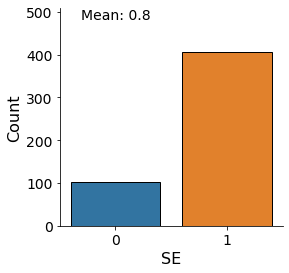

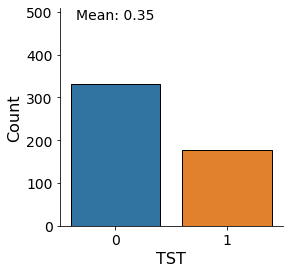

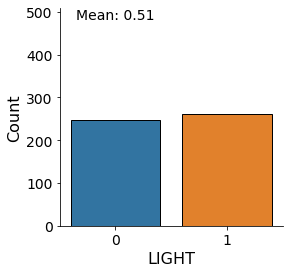

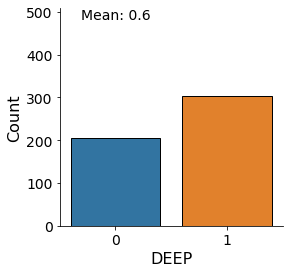

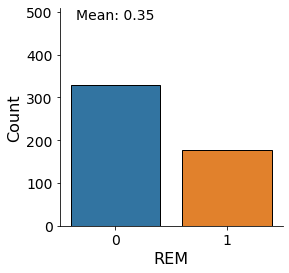

In [37]:
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    plot_summary_count(combined_fb_simple,f"{fb_target}_binary")

### Self-Report
And now for the self-report metrics

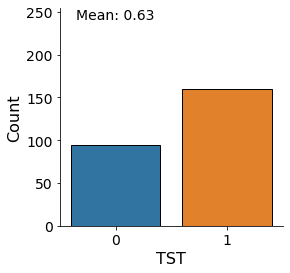

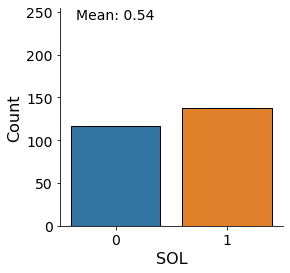

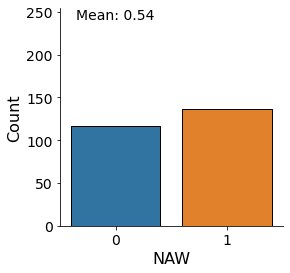

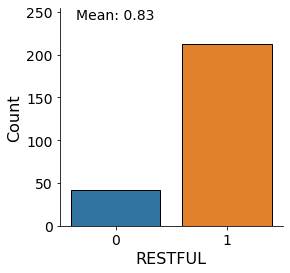

In [38]:
for sr_target in ["tst","sol","naw","restful"]:
    plot_summary_count(combined_sr_simple,f"{sr_target}_binary")

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. We will try a wide-variety of classifiers to determine which is the most applicable to solving our problem. The classifiers that we use can be seen in the following cell via the `import` statements.

## Linear Regression
We use linear regression as a first step in the analysis.

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
class linear_model:
    
    def __init__(self):
        pass
    
    def set_x_and_y(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """sets the x and y parameters"""
        # for reference
        self.target_label = target
        self.feature_labels = features
        combined = feature_set.merge(right=target_set,on=["beiwe","end_date"])
        combined_simple = combined[[column for column in combined.columns if not column.endswith("binary") and not column.endswith("x") and not column.endswith("y")]]
        combined_simple.dropna(inplace=True)
        # getting x and y
        self.y = combined_simple[[f"{target}"]]
        self.X = combined_simple[[column for column in combined.columns if column.endswith("median") or column.endswith("minutes") or column == "steps"]]
        self.X = self.X[features]

    def set_model(self):
        """runs a linear leasts-squares regression model"""
        self.model = LinearRegression(normalize=True).fit(self.X,self.y)
        temp = pd.DataFrame(data={"feature":self.feature_labels,"coefficient":self.model.coef_[0]})
        self.coefficients = temp.sort_values("coefficient")
    
    def run(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """runs the linear model"""
        self.set_x_and_y(feature_set, target_set, features, target)
        self.set_model()
        print(self)
        
    def get_r2(self):
        """gets r2"""
        return round(self.model.score(self.X, self.y),3)
    
    def get_coefs(self):
        """gets coefficients of the model"""
        return self.coefficients
    
    def __str__(self):
        """output"""
        print("Linear Model")
        try:
            print("Observations:", len(self.X))
            print("Score:", self.get_r2())
            print("Coefficients:")
            for feature, c in zip(self.get_coefs().iloc[:,0], self.get_coefs().iloc[:,1]):
                print(f"\t{feature}:\t{round(c,4)}")
        except AttributeError:
            print("No Model found")
            
        return ""

### Aggregate
All the participants' data considered

In [41]:
lm = linear_model()
lm.run(ieq_and_activity, fbsq, features=["co2_median","co_median","pm2p5_mass_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"])

Linear Model
Observations: 396
Score: 0.087
Coefficients:
	temperature_c_median:	-0.0573
	co_median:	-0.0412
	lightly_active_minutes:	-0.0028
	sedentary_minutes:	-0.0006
	steps:	-0.0
	co2_median:	0.0
	fairly_active_minutes:	0.0036
	very_active_minutes:	0.0062
	rh_median:	0.0068
	pm2p5_mass_median:	0.0335



## Classification

In [42]:
# Logistic Regressions
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
# ADAboost
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier

To automate the prediction/evaluation process, we have created the class below that utilizes the following steps:
1. Feature and Target Data Split: The feature and target datasets are fed into the program, cross-referenced, and then split.
2. Train/Test Split: Data are split into a training and a testing split

In [50]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, f1_score, precision_recall_curve, plot_precision_recall_curve, accuracy_score

class ieq_and_sq_prediction:
    
    def __init__(self):
        """initializes the model parameters"""
        self.classifier_model_params_complete = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            },
            "support_vector": {
                "model":SVC(random_state=42),
                "params": {
                    "kernel":["linear","poly","sigmoid","rbf"],
                }
            },
            "multilayer_perceptron": {
                "model":MLPClassifier(random_state=42,solver="lbfgs",max_iter=500),
                "params": {
                    "hidden_layer_sizes":[1,10,50,100],
                    "activation":["identity","logistic"]
                }
            },
            "adaboost":{
                "model": AdaBoostClassifier(random_state=42),
                "params": {
                }
            },
            "gradientboost":{
                "model": GradientBoostingClassifier(random_state=42),
                "params": {
                    "max_depth":[1,2,3],
                }
            },
            "bagging":{
                "model":BaggingClassifier(random_state=42),
                "params": {
                    "n_estimators":[5,10,20],
                    "bootstrap_features":[False,True],
                }
            }
        }
        self.classifier_model_params = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            }
        }
        self.tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs",max_iter=500),
                             "knn":KNeighborsClassifier(n_neighbors=7,weights="uniform",p=1),
                             "random_forest":RandomForestClassifier(random_state=42,n_estimators=10,max_depth=2,min_samples_leaf=2,min_samples_split=2)}
    
    def get_features_and_targets(self, feature_set, target_set, target="tst"):
        """gets feature set and target set for the same observations"""
        self.target_label = target
        print(f"Getting Features and Target ({target})...")
        # selecting only important target
        target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
        # combining datasets to get overlapping observations
        combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
        combined = combined.merge(right=combined["beiwe"].value_counts().rename("count"),left_on="beiwe",right_index=True,how="left")
        combined = combined[combined["count"] > 1]
        combined_simple = combined[[column for column in combined.columns if column.endswith("binary") or column in ["count","beiwe"]]]
        # splitting into features and targets
        targets = combined_simple[[f"{target}_binary"]]
        features = combined_simple.drop([f"{target}_binary","beiwe"],axis="columns")
        self.groups = combined_simple["beiwe"]
        self.features = features
        self.targets = targets
        
    def split_data(self, test_size=0.33):
        """splits data into training and testing"""
        print("Splitting Data...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets, test_size=test_size, random_state=10, stratify=self.features["count"])
        self.X_train.drop("count",axis="columns",inplace=True)
        self.X_test.drop("count",axis="columns",inplace=True)
        
    def set_test_and_train(self,X_train,X_test,y_train,y_test):
        """sets the training data - use for specialized train_test_split"""
        for dataset in [X_train,X_test,y_train,y_test]:
            try: 
                dataset.drop(["count"],axis="columns",inplace=True)
            except KeyError:
                pass
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def set_weights(self,**kwargs):
        """sets the weights based on the y_train data"""
        if "y_train" in kwargs.keys():
            self.y_train = kwargs["y_train"]
        try:
            low_n = self.y_train.value_counts().sort_index().iloc[0]
            high_n = self.y_train.value_counts().sort_index().iloc[1]
            self.weights = [len(self.y_train) / (2 * low_n) if val == 0 else len(self.y_train) / (2 * high_n) for val in self.y_train[f"{target}_binary"]]
        except Exception as e:
            print(e)
            self.weights = None # defaults to None so the fit() function will work
        
    def optimize_models(self):
        """runs gridsearch cv"""
        print("Testing Classifiers...")
        try:
            scores = []
            params = self.classifier_model_params
            self.set_weights()
            for model_name, mp in params.items():
                s = datetime.now()
                print(f"\t{model_name.replace('_',' ').title()}")
                clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                clf.fit(self.X_train,self.y_train,self.weights)
                scores.append({
                    "model":model_name,
                    "best_score":clf.best_score_,
                    "best_params":clf.best_params_
                })
                print("\t\tElapsed Time:\t", datetime.now() - s)
                print(f"\t\tBest Score:\t{clf.best_score_}\n\t\tBest Params:\t{clf.best_params_}")

            results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
            # getting and saving best model
            results.sort_values(["best_score"],ascending=False,inplace=True)
            self.results = results
            best = results.iloc[0,:]
            # outputting results
            print(f"\tBest Scoring Model:")
            print(f"\t\tModel:\t{best[0].replace('_',' ').title()}\n\t\tScore:\t{round(best[1],3)}\n\t\tParams:\t{best[2]}")
        except AttributeError:
            print("Training data do not exist - run split_data()")
        
    def train_model(self, model):
        """trains the specified model"""
        print("Training...")
        self.model = model # necessary if running functions separately
        try:
            self.set_weights()
            self.X_train = self.X_train
            self.X_test = self.X_test
            self.model.fit(self.X_train,self.y_train,self.weights)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self):
        """gets the predicted results based on the model provided for the given target"""
        print("Predicting...")
        try:
            self.predictions = self.model.predict(self.X_test)
            
            self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

            scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
            print("\tCross Validation Scores:")
            for scr in scores:
                print(f"\t\t{round(scr,3)}")
            print(f"\tAverage:\t{round(scores.mean(),3)}")
            print(f"\tModel Score: {round(self.score,3)}")
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        print("Evaluating...")
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def set_feature_importance(self,plot=False):
        """gets feature importance from classifier models"""
        try:
            # getting importance df
            importance = pd.DataFrame(data={"feature":[value.split('_')[0] for value in self.features.columns[:-1]],"importance":self.model.feature_importances_})
            importance.sort_values("importance",inplace=True)
            self.feature_importance = importance
            if plot:
                # getting color map
                my_cmap = plt.get_cmap("Blues")
                rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
                # plotting
                fig, ax = plt.subplots(figsize=(6,4))
                ax.barh(importance["feature"],importance["importance"],color=my_cmap(rescale(importance["importance"])),edgecolor="black",tick_label=[visualize.get_label(label) for label in importance["feature"]])
                # x-axis
                plt.xticks(fontsize=12)
                ax.set_xlabel("Importance",fontsize=14)
                # y-axis
                plt.yticks(fontsize=12)
                ax.set_ylabel("Feature",fontsize=14)
                # remainder
                for loc in ["top","right"]:
                    ax.spines[loc].set_visible(False)
                plt.show()
                plt.close()
        except AttributeError as e:
            print(e)
            
    def run(self, feature_set, target_set, target="tst", test_size=0.33):
        """runs the class: split, test, predict, evaluate"""
        self.get_features_and_targets(feature_set, target_set, target=target)
        self.split_data(test_size=test_size)
        # gridsearch on models
        self.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        for model_number in range(len(self.results)):
            print(self.results.iloc[model_number,0].replace("_"," ").upper())
            self.model = self.classifier_model_params[self.results.iloc[model_number,:]["model"]]["model"].set_params(**self.results.iloc[model_number,:]["best_params"])
            self.train_model(self.model)
            self.predict()
            self.plot_confusion_matrix()
            self.set_feature_importance(plot=True)
            
    def get_cv(self,validation="gkf",splits=5):
        """gets cv object"""
        if validation == "gkf":
            return GroupKFold(n_splits=splits)
        elif validation == "logo":
            return LeaveOneGroupOut()
        elif validation == "skf":
            return StratifiedKFold(n_splits=splits)
        else:
            return KFold(n_splits=splits)        
            
    def plot_roc_auc(self,validation="gkf",splits=5,save=False):
        """Trains the tuned models and cross-validates"""
        cv = self.get_cv(validation,splits)
            
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            tprs = []
            aucs = []
            f1s = []
            mean_fpr = np.linspace(0, 1, 100)
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                scores = clf.predict(self.features.iloc[test])
                try:
                    fpr, tpr, thresholds = roc_curve(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    auc_score = roc_auc_score(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    f1 = f1_score(self.targets.iloc[test], scores)
                    if validation != "logo":
                        ax.plot(fpr,tpr,lw=1,alpha=0.5,label=f"Fold {i+1}")
                    interp_tpr = np.interp(mean_fpr, fpr, tpr)
                    interp_tpr[0] = 0.0
                    tprs.append(interp_tpr)
                    aucs.append(auc_score)
                    f1s.append(f1)
                except ValueError as e:
                    print(e)
                
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='black',label=f'Mean ROC\nAUC = {round(mean_auc,2)} $\pm$ {round(std_auc,2)}',lw=3, alpha=.8)
            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            ax.set_title(f'{name.replace("_"," ").title()}\nF1 = {round(np.mean(f1s),2)}',fontsize=16)
            plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            ax.legend(frameon=False,loc="lower right",bbox_to_anchor=(1.2,0),fontsize=11,)
        if save:
            plt.savefig(f"../reports/conferences/BuildSys_2021/{self.target_label}-{validation}cv-roc_curve.pdf")
            
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.show()
        plt.close()
        
    def find_accuracy_threshold(self):
        """"""
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            clf = model.fit(self.X_train,self.y_train)
            y_pred_pos = clf.predict_proba(self.X_test)[:,1]
            thresholds = []
            accs = []
            for threshold in np.linspace(0,1,100):
                thresholds.append(threshold)
                y_pred_class = y_pred_pos > threshold
                acc = accuracy_score(self.y_test, y_pred_class)
                accs.append(acc)
            ax.plot(thresholds,accs,color="black",lw=2)
            ix = np.argmax(accs)
            ax.set_title(thresholds[ix])
        plt.show()
        plt.close()

    def plot_pr_auc(self,cv="gkf",splits=5,save=False):
        """plots the precision-recall curve"""
        cv = self.get_cv(cv,splits)
        
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            precisions = []
            thresholds = []
            mean_recall = np.linspace(0, 1, 100)
            fscores_balanced = []
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                precision, recall, threshold = precision_recall_curve(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                if cv != "logo":
                    ax.plot(recall,precision,lw=1,alpha=0.5,label=f"Fold {i+1}")
                    
                precisions.append(np.interp(mean_recall, np.sort(recall), precision))
                thresholds.append(np.interp(mean_recall, np.sort(recall), np.append(threshold,[1])))
                fscores_balanced.append(f1_score(self.targets.iloc[test],clf.predict(self.features.iloc[test])))
                
            mean_precision = np.mean(precisions, axis=0)
            mean_threshold = np.mean(thresholds, axis=0)
            fscore = (2 * mean_precision * mean_recall[::-1]) / (mean_precision + mean_recall[::-1])
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            score = round(sum(self.targets.iloc[:,0])/len(self.targets),3)
            print(f'Model={name}\n\tBest Threshold={round(mean_threshold[ix],3)}\n\tF-Score (balanced) = {round(np.mean(fscores_balanced),2)}\n\tF-Score (adjusted) ={round(fscore[ix],3)}\n\tNaive Score={score if score > 0.5 else 1-score}')
            ax.plot(mean_recall[::-1], mean_precision, color='black',lw=3, alpha=.8)#,label=f'Mean ROC\nAUC = {round(mean_auc,2)} $\pm$ {round(std_auc,2)}'
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            ax.set_title(f'{name.replace("_"," ").title()}',fontsize=16)
            plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            ax.legend(frameon=False,loc="lower right",bbox_to_anchor=(1.2,0),fontsize=11,)
        if save:
            plt.savefig(f"../reports/conferences/BuildSys_2021/{self.target_label}-{validation}cv-roc_curve.pdf")
            
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.show()
        plt.close()
            
            

### Scoring
Now that we have determined which models and hyperparameters to use, we can go forward and calculate some scoring metrics.

Check out this article [here](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc) for more.

#### Restricting Dataset to a Select Number

In [51]:
n_nights_by_pt = ieq_and_activity[["start_time","beiwe"]].groupby("beiwe").count().sort_values("start_time",ascending=False)
n_nights_select = n_nights_by_pt[n_nights_by_pt["start_time"] >= 20]
ieq_activity_and_fb_select = ieq_and_activity[ieq_and_activity["beiwe"].isin(n_nights_select.index)]

#### Plotting and Measuring

SKF
Getting Features and Target (se)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.469
	F-Score (balanced) = 0.88
	F-Score (adjusted) =0.9
	Naive Score=0.818
Model=knn
	Best Threshold=0.286
	F-Score (balanced) = 0.82
	F-Score (adjusted) =0.902
	Naive Score=0.818
Model=random_forest
	Best Threshold=0.648
	F-Score (balanced) = 0.9
	F-Score (adjusted) =0.9
	Naive Score=0.818


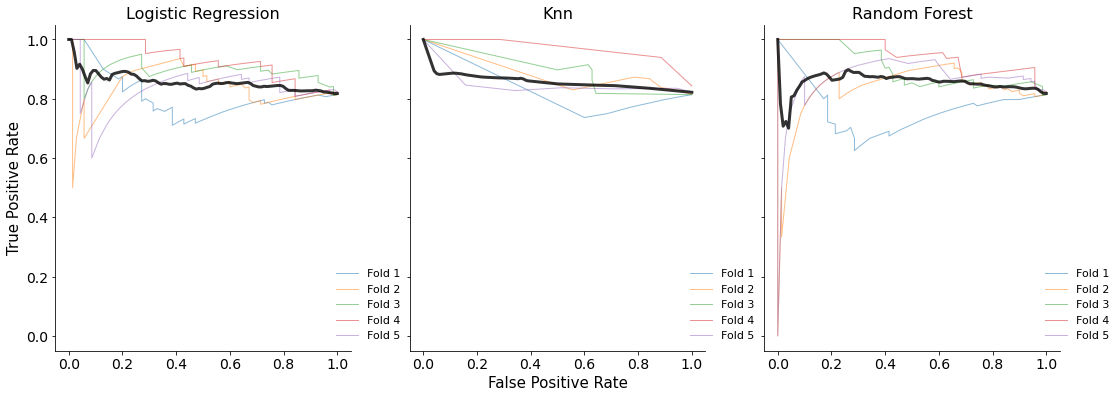

Getting Features and Target (tst)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.272
	F-Score (balanced) = 0.1
	F-Score (adjusted) =0.521
	Naive Score=0.633
Model=knn
	Best Threshold=0.257
	F-Score (balanced) = 0.2
	F-Score (adjusted) =0.471
	Naive Score=0.633
Model=random_forest
	Best Threshold=0.312
	F-Score (balanced) = 0.01
	F-Score (adjusted) =0.517
	Naive Score=0.633


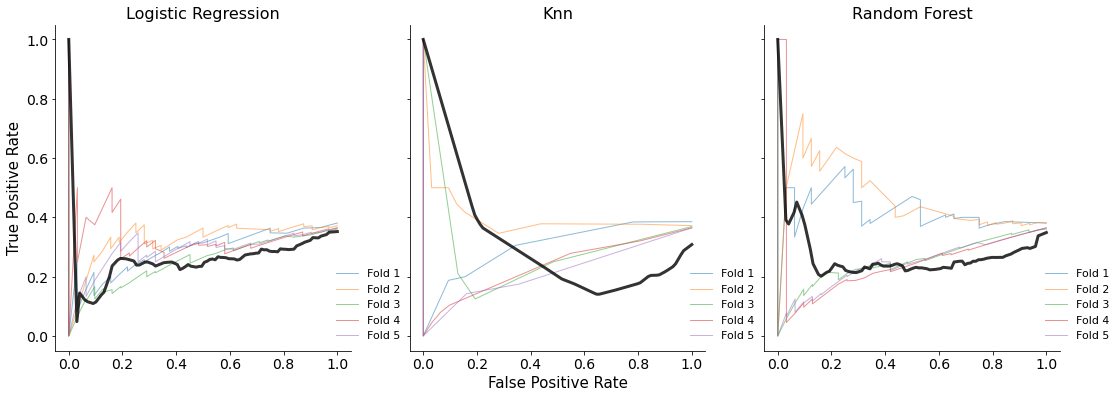

Getting Features and Target (light_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.294
	F-Score (balanced) = 0.47
	F-Score (adjusted) =0.671
	Naive Score=0.5
Model=knn
	Best Threshold=0.303
	F-Score (balanced) = 0.47
	F-Score (adjusted) =0.648
	Naive Score=0.5
Model=random_forest
	Best Threshold=0.388
	F-Score (balanced) = 0.46
	F-Score (adjusted) =0.672
	Naive Score=0.5


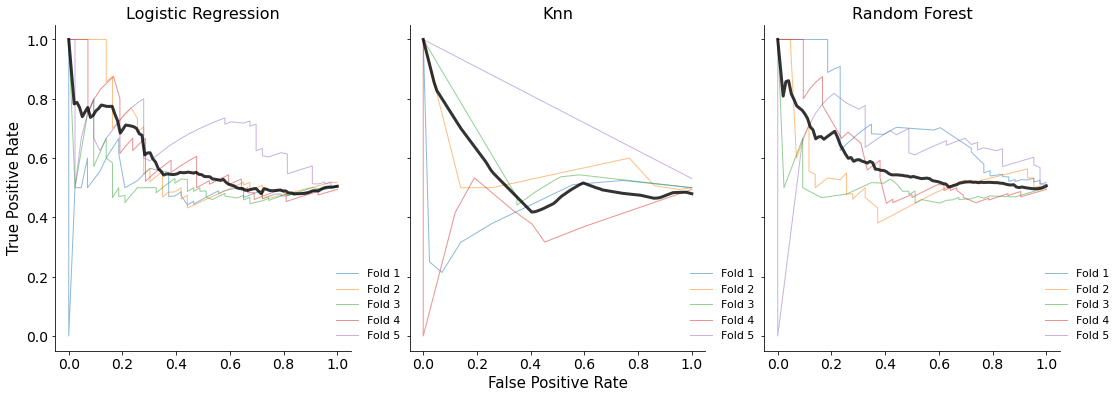

Getting Features and Target (deep_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.404
	F-Score (balanced) = 0.62
	F-Score (adjusted) =0.751
	Naive Score=0.6
Model=knn
	Best Threshold=0.114
	F-Score (balanced) = 0.45
	F-Score (adjusted) =0.752
	Naive Score=0.6
Model=random_forest
	Best Threshold=0.499
	F-Score (balanced) = 0.67
	F-Score (adjusted) =0.743
	Naive Score=0.6


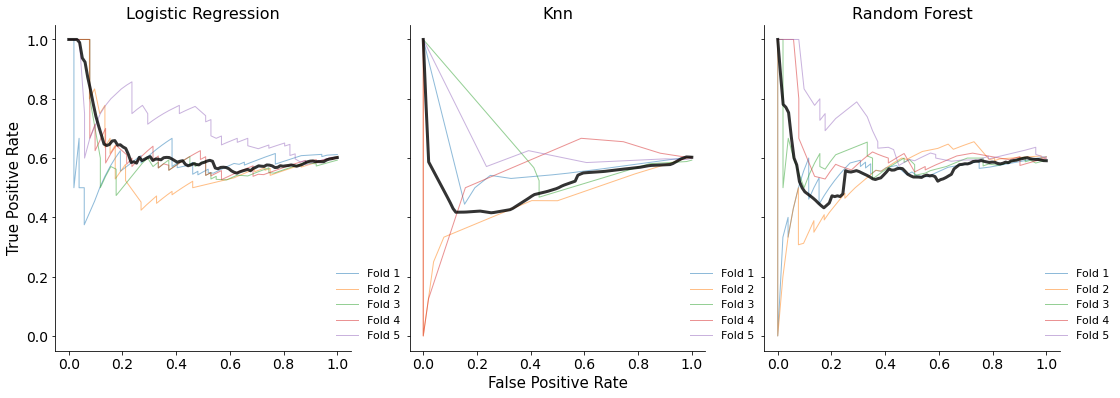

Getting Features and Target (rem_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.312
	F-Score (balanced) = 0.15
	F-Score (adjusted) =0.555
	Naive Score=0.645
Model=knn
	Best Threshold=0.674
	F-Score (balanced) = 0.26
	F-Score (adjusted) =0.574
	Naive Score=0.645
Model=random_forest
	Best Threshold=0.276
	F-Score (balanced) = 0.01
	F-Score (adjusted) =0.526
	Naive Score=0.645


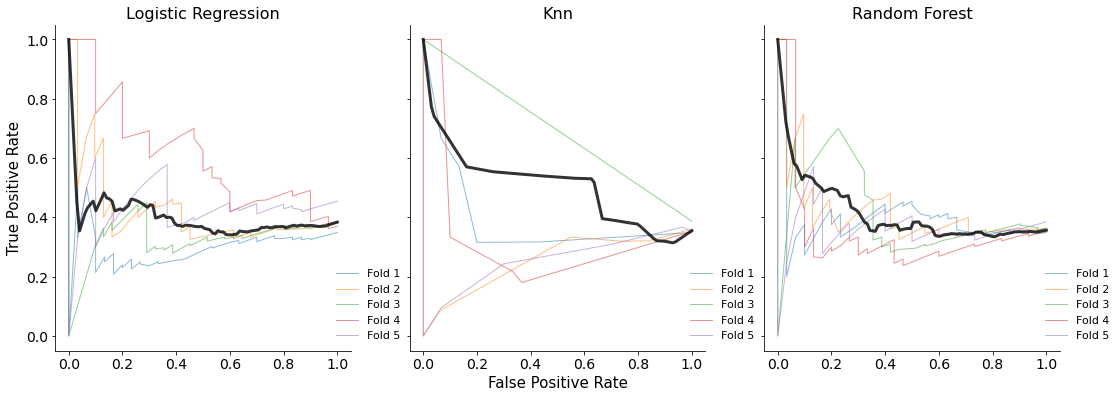

Getting Features and Target (tst)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.415
	F-Score (balanced) = 0.77
	F-Score (adjusted) =0.805
	Naive Score=0.652
Model=knn
	Best Threshold=0.286
	F-Score (balanced) = 0.69
	F-Score (adjusted) =0.791
	Naive Score=0.652
Model=random_forest
	Best Threshold=0.492
	F-Score (balanced) = 0.78
	F-Score (adjusted) =0.794
	Naive Score=0.652


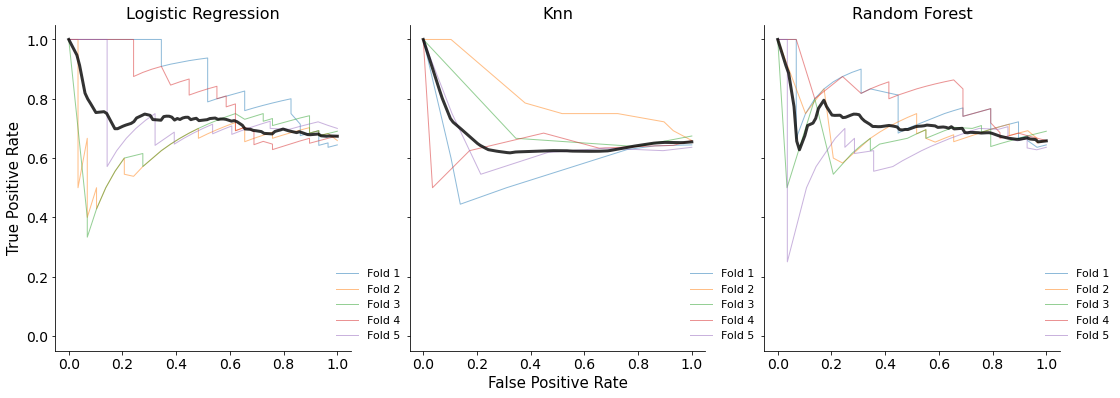

Getting Features and Target (sol)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.381
	F-Score (balanced) = 0.56
	F-Score (adjusted) =0.724
	Naive Score=0.548
Model=knn
	Best Threshold=0.428
	F-Score (balanced) = 0.59
	F-Score (adjusted) =0.761
	Naive Score=0.548
Model=random_forest
	Best Threshold=0.471
	F-Score (balanced) = 0.64
	F-Score (adjusted) =0.766
	Naive Score=0.548


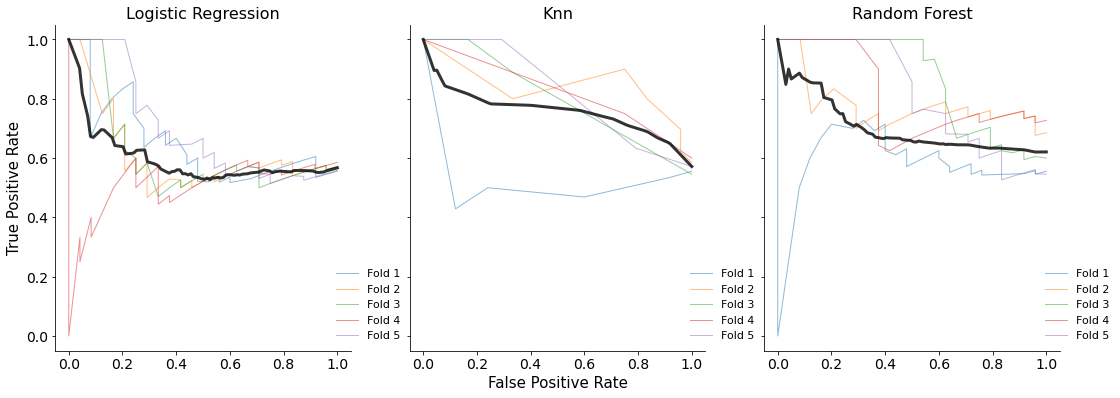

Getting Features and Target (naw)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.376
	F-Score (balanced) = 0.5
	F-Score (adjusted) =0.674
	Naive Score=0.511
Model=knn
	Best Threshold=0.349
	F-Score (balanced) = 0.61
	F-Score (adjusted) =0.73
	Naive Score=0.511
Model=random_forest
	Best Threshold=0.372
	F-Score (balanced) = 0.55
	F-Score (adjusted) =0.709
	Naive Score=0.511


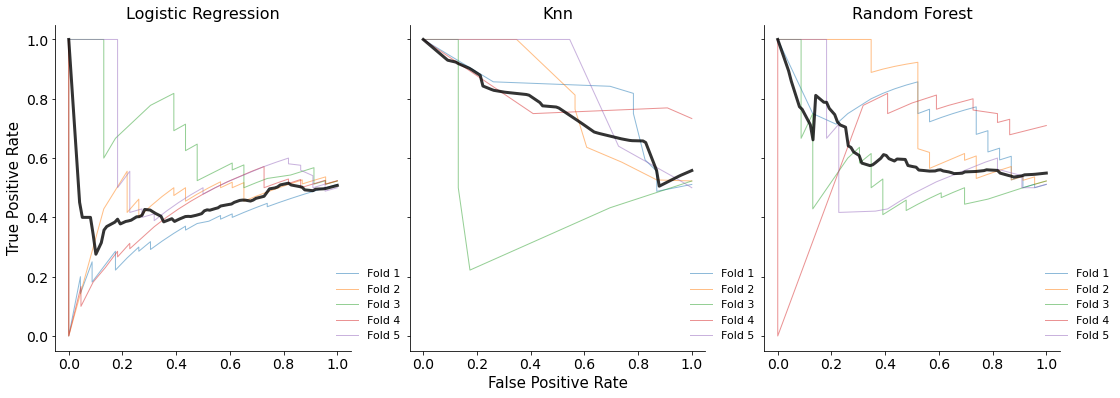

Getting Features and Target (restful)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.599
	F-Score (balanced) = 0.91
	F-Score (adjusted) =0.916
	Naive Score=0.837
Model=knn
	Best Threshold=0.371
	F-Score (balanced) = 0.81
	F-Score (adjusted) =0.911
	Naive Score=0.837
Model=random_forest
	Best Threshold=0.642
	F-Score (balanced) = 0.91
	F-Score (adjusted) =0.918
	Naive Score=0.837


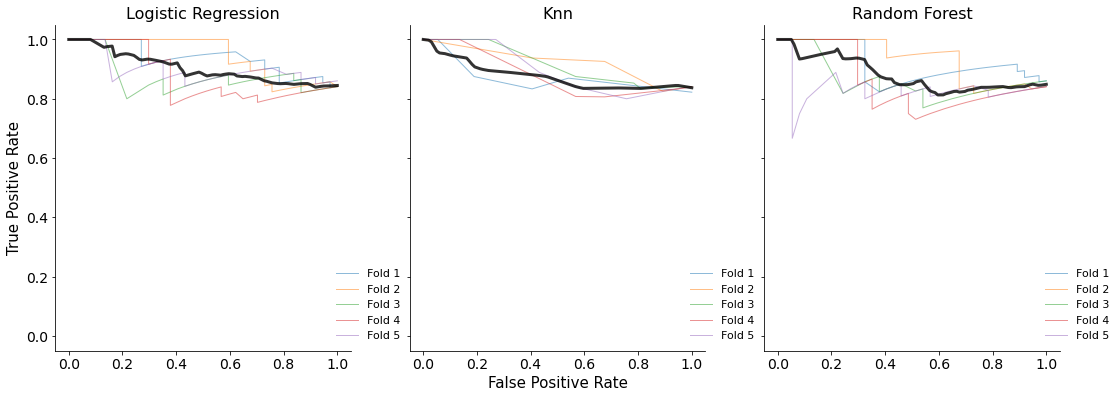

LOGO
Getting Features and Target (se)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.602
	F-Score (balanced) = 0.88
	F-Score (adjusted) =0.906
	Naive Score=0.818
Model=knn
	Best Threshold=0.607
	F-Score (balanced) = 0.87
	F-Score (adjusted) =0.905
	Naive Score=0.818
Model=random_forest
	Best Threshold=0.739
	F-Score (balanced) = 0.89
	F-Score (adjusted) =0.903
	Naive Score=0.818


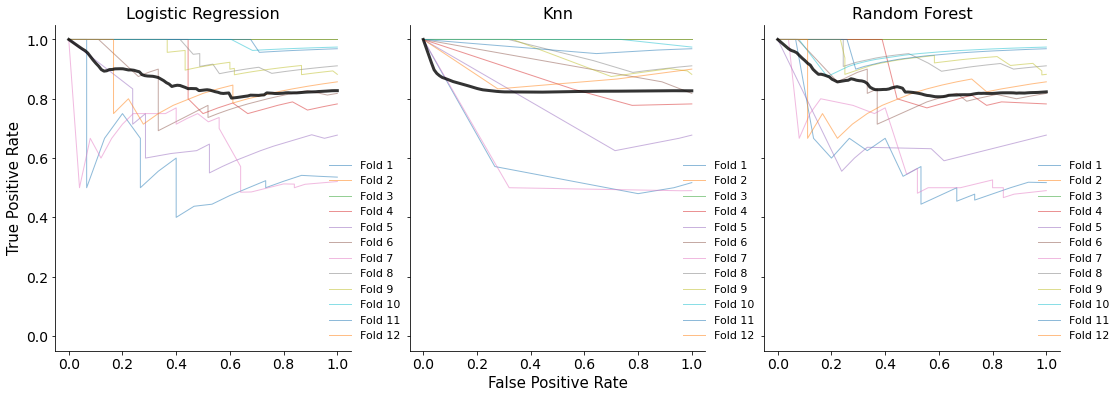

Getting Features and Target (tst)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.339
	F-Score (balanced) = 0.11
	F-Score (adjusted) =0.526
	Naive Score=0.633
Model=knn
	Best Threshold=0.433
	F-Score (balanced) = 0.24
	F-Score (adjusted) =0.525
	Naive Score=0.633
Model=random_forest
	Best Threshold=0.356
	F-Score (balanced) = 0.03
	F-Score (adjusted) =0.55
	Naive Score=0.633


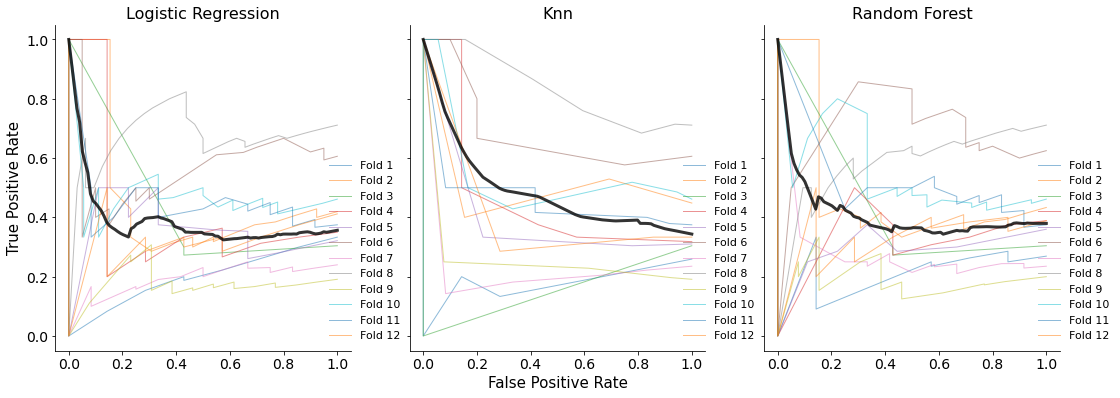

Getting Features and Target (light_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=nan
	F-Score (balanced) = 0.26
	F-Score (adjusted) =nan
	Naive Score=0.5
Model=knn
	Best Threshold=nan
	F-Score (balanced) = 0.36
	F-Score (adjusted) =nan
	Naive Score=0.5
Model=random_forest
	Best Threshold=nan
	F-Score (balanced) = 0.28
	F-Score (adjusted) =nan
	Naive Score=0.5


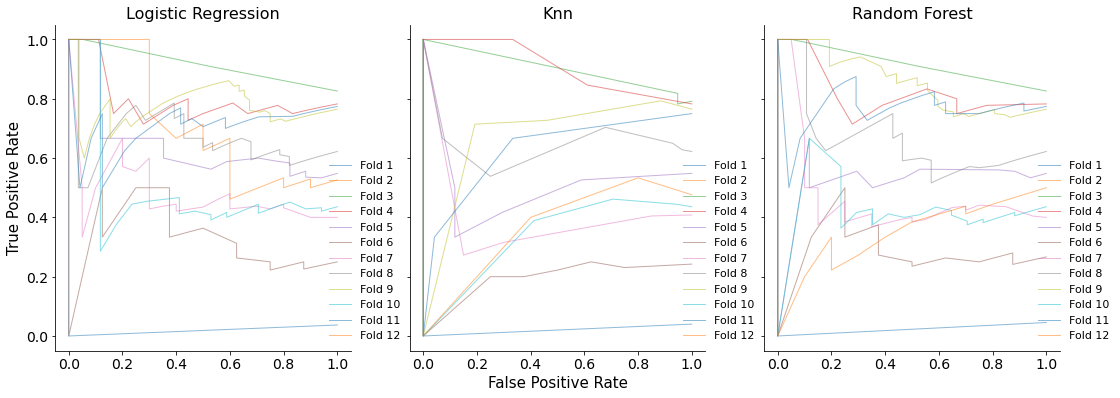

Getting Features and Target (deep_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=nan
	F-Score (balanced) = 0.61
	F-Score (adjusted) =nan
	Naive Score=0.6
Model=knn
	Best Threshold=nan
	F-Score (balanced) = 0.52
	F-Score (adjusted) =nan
	Naive Score=0.6
Model=random_forest
	Best Threshold=nan
	F-Score (balanced) = 0.67
	F-Score (adjusted) =nan
	Naive Score=0.6


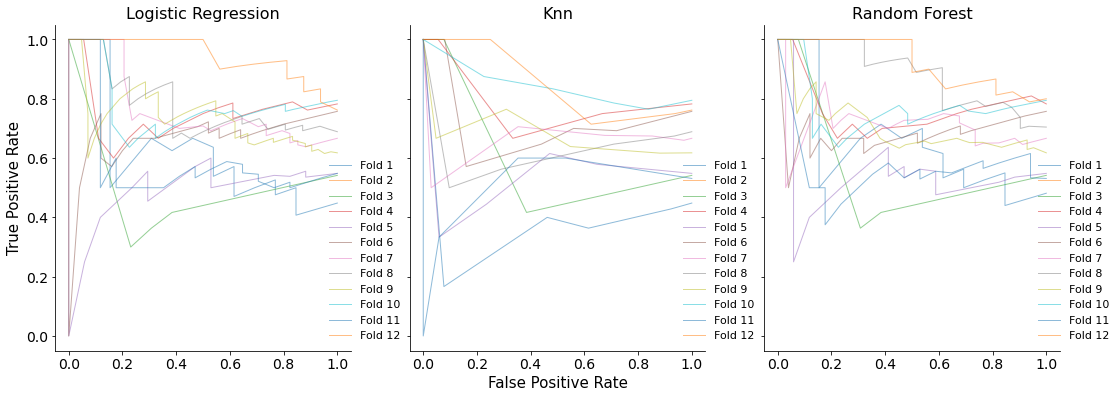

Getting Features and Target (rem_percent)...
Splitting Data...
Model=logistic_regression
	Best Threshold=nan
	F-Score (balanced) = 0.07
	F-Score (adjusted) =nan
	Naive Score=0.645
Model=knn
	Best Threshold=nan
	F-Score (balanced) = 0.22
	F-Score (adjusted) =nan
	Naive Score=0.645
Model=random_forest
	Best Threshold=nan
	F-Score (balanced) = 0.02
	F-Score (adjusted) =nan
	Naive Score=0.645


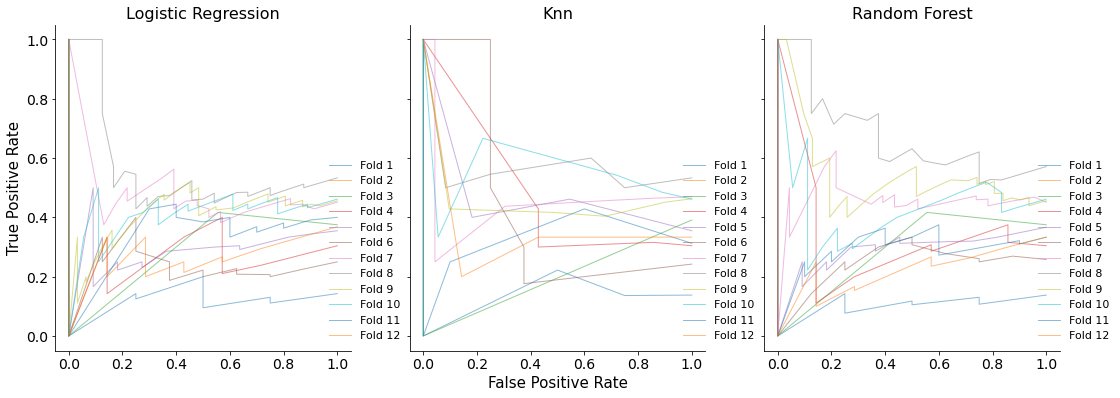

Getting Features and Target (tst)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.463
	F-Score (balanced) = 0.64
	F-Score (adjusted) =0.761
	Naive Score=0.652
Model=knn
	Best Threshold=0.417
	F-Score (balanced) = 0.51
	F-Score (adjusted) =0.75
	Naive Score=0.652
Model=random_forest
	Best Threshold=0.523
	F-Score (balanced) = 0.71
	F-Score (adjusted) =0.753
	Naive Score=0.652


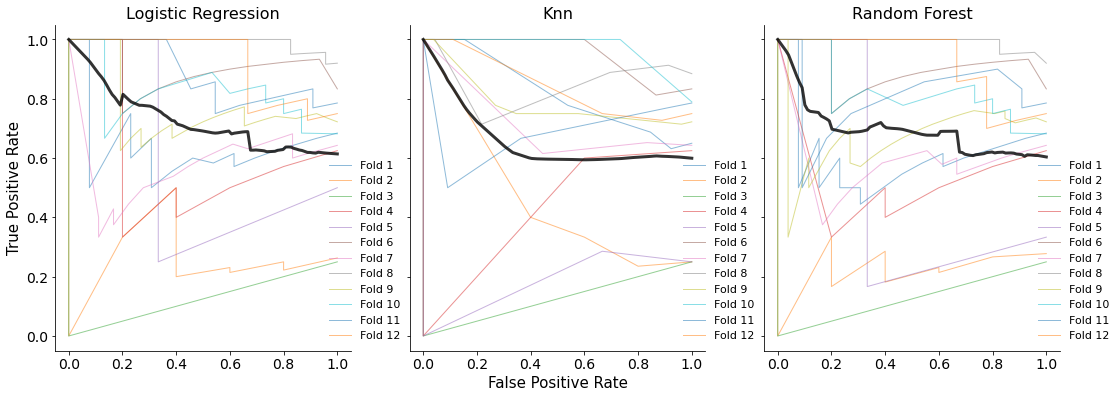

Getting Features and Target (sol)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.496
	F-Score (balanced) = 0.6
	F-Score (adjusted) =0.746
	Naive Score=0.548
Model=knn
	Best Threshold=0.488
	F-Score (balanced) = 0.59
	F-Score (adjusted) =0.728
	Naive Score=0.548
Model=random_forest
	Best Threshold=0.527
	F-Score (balanced) = 0.63
	F-Score (adjusted) =0.728
	Naive Score=0.548


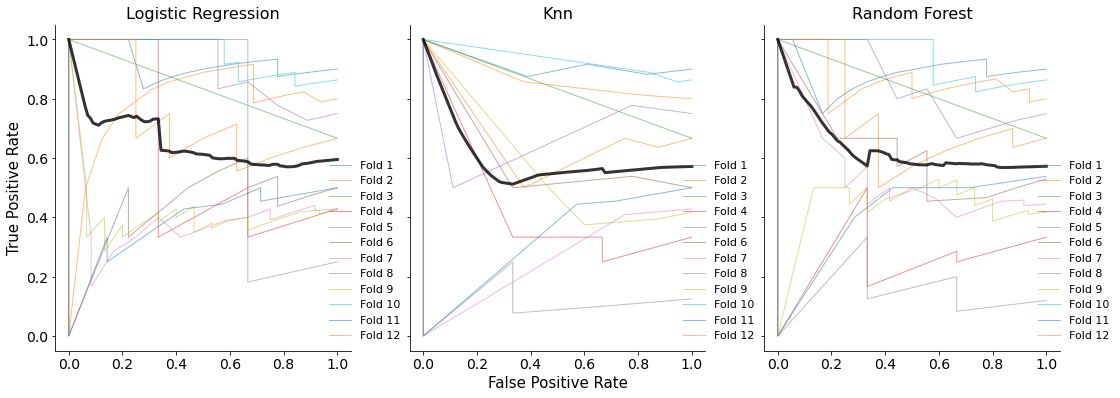

Getting Features and Target (naw)...
Splitting Data...
Model=logistic_regression
	Best Threshold=nan
	F-Score (balanced) = 0.47
	F-Score (adjusted) =nan
	Naive Score=0.511
Model=knn
	Best Threshold=nan
	F-Score (balanced) = 0.32
	F-Score (adjusted) =nan
	Naive Score=0.511
Model=random_forest
	Best Threshold=nan
	F-Score (balanced) = 0.4
	F-Score (adjusted) =nan
	Naive Score=0.511


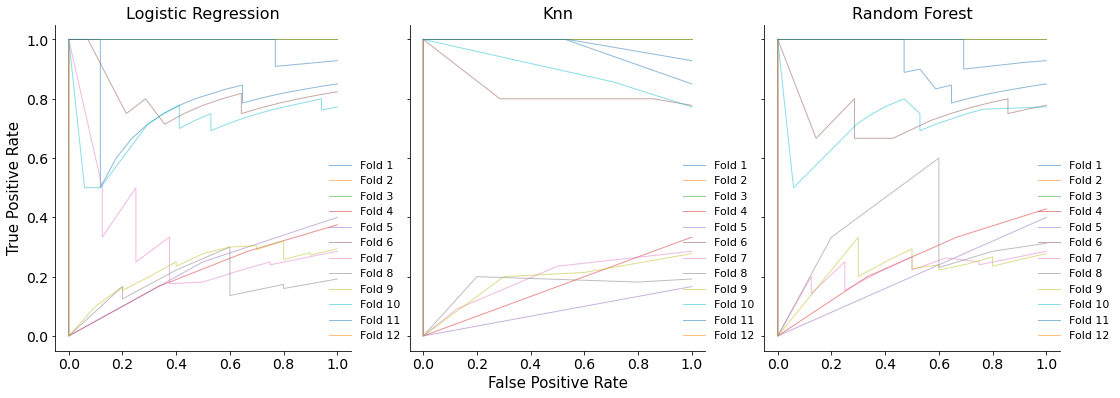

Getting Features and Target (restful)...
Splitting Data...
Model=logistic_regression
	Best Threshold=0.68
	F-Score (balanced) = 0.88
	F-Score (adjusted) =0.906
	Naive Score=0.837
Model=knn
	Best Threshold=0.536
	F-Score (balanced) = 0.79
	F-Score (adjusted) =0.894
	Naive Score=0.837
Model=random_forest
	Best Threshold=0.735
	F-Score (balanced) = 0.88
	F-Score (adjusted) =0.892
	Naive Score=0.837


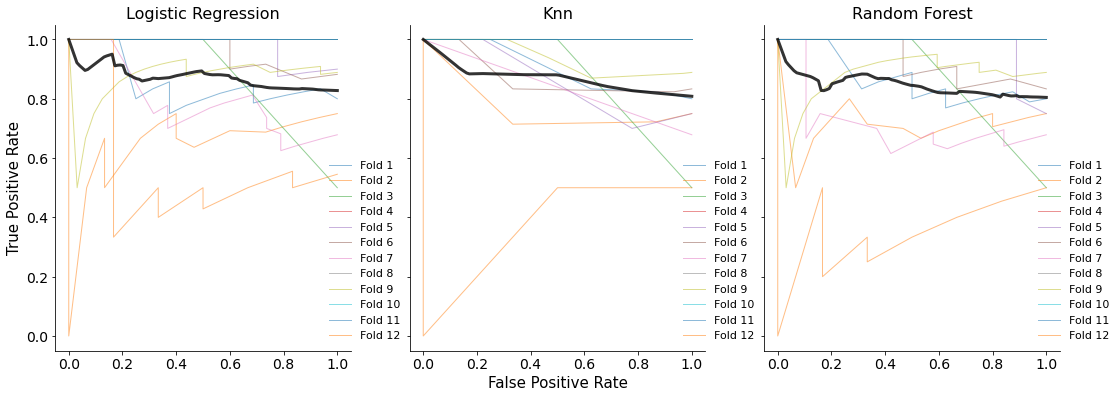

In [52]:
temp = ieq_and_sq_prediction()
for validation_method in ["skf","logo"]:
    print(validation_method.upper())
    for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
        for target in targets:
            temp.get_features_and_targets(ieq_activity_and_fb_select, target_set, target=target)
            temp.split_data()
            temp.plot_pr_auc(validation_method)
            #temp.find_accuracy_threshold()

## Optimizing Models
Looking at different components of:
* classifiers
* validation
* hyperparameters

### Aggregate
All the participants' data considered and stratified according to the number of observations.

Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.162954
		Best Score:	0.8058823529411765
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.802508
		Best Score:	0.8058823529411765
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.092136
		Best Score:	0.8058823529411765
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.553739
		Best Score:	0.7764705882352941
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.806
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.654
		0.654
		0.654
		0.631
	Average:	0.649
	Model Score: 0.685
Evaluating...


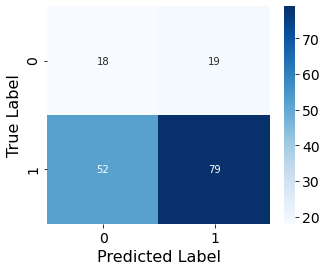

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.654
		0.654
		0.654
		0.631
	Average:	0.649
	Model Score: 0.713
Evaluating...


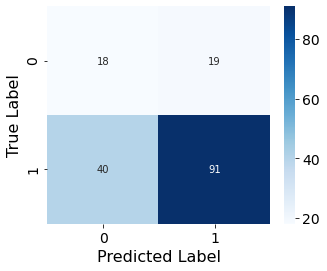

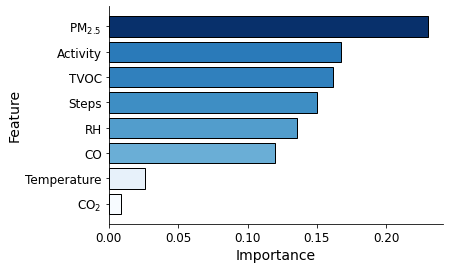

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.652
		0.654
		0.654
		0.855
		0.631
	Average:	0.689
	Model Score: 0.69
Evaluating...


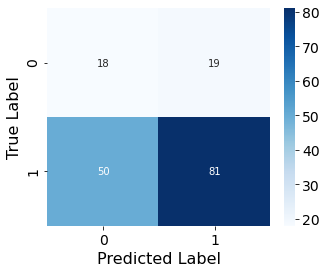

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...


TypeError: fit() takes 3 positional arguments but 4 were given

In [213]:
agg_pred = ieq_and_sq_prediction()
agg_res = {"target":[],"best_performing_model":[],"model":[],"model_score":[],"biased_score":[],"hyper_parameters":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for target in targets:
        agg_pred.run(ieq_and_activity,target_set,target)
        for i in range(len(agg_pred.results)):
            agg_res["target"].append(target)
            agg_res["best_performing_model"].append(agg_pred.results.iloc[0,0])
            agg_res["model"].append(agg_pred.results.iloc[i,0])
            agg_res["model_score"].append(agg_pred.results.iloc[i,1])
            bs = sum(agg_pred.targets.values)/len(agg_pred.targets)
            agg_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            agg_res["hyper_parameters"].append(agg_pred.results.iloc[i,2])
            try:
                agg_res["sensitive_parameter1"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                agg_res["sensitive_parameter2"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                agg_res["sensitive_parameter1"].append(np.nan)
                agg_res["sensitive_parameter2"].append(np.nan)

In [82]:
agg_res_df = pd.DataFrame(agg_res)
#agg_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-aggregate-results.csv")
agg_res_df.head()

target best_performing_model                  model  model_score  \
0     se   logistic_regression    logistic_regression     0.805882   
1     se   logistic_regression          random_forest     0.805882   
2     se   logistic_regression  bernoulli_naive_bayes     0.805882   
3     se   logistic_regression     k-nearest_neighbor     0.776471   
4    tst         random_forest          random_forest     0.676471   

   biased_score                                   hyper_parameters  \
0      0.797244         {'fit_intercept': True, 'solver': 'lbfgs'}   
1      0.797244  {'max_depth': 2, 'min_samples_leaf': 1, 'min_s...   
2      0.797244                                       {'alpha': 0}   
3      0.797244   {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}   
4      0.653543  {'max_depth': 2, 'min_samples_leaf': 1, 'min_s...   

  sensitive_parameter1 sensitive_parameter2  
0                pm2p5               active  
1                pm2p5               active  
2                pm2p5               active  
3                pm2p5               active  
4               active          temperature

### Per Participant
Now we try another model where we considering only 1 participant, train on a subset of their data and see about predicting their sleep quality.

We first have to identify applicable participants. After an initial inspection, there seems to be a good cutoff of about **30 nights** that would give us a minimum of 20 nights for training and 10 for testing.

#### Self-Report

In [48]:
ieq_and_srsq = ieq_and_activity.merge(right=srsq,on=["beiwe","redcap","beacon","end_date"])
n_nights_sr = ieq_and_srsq[["start_time","beiwe"]].groupby("beiwe").count().sort_values("start_time",ascending=False)
n_nights_gt20 = n_nights_sr[n_nights_sr["start_time"] >= 20]
n_nights_gt20

start_time
beiwe               
tlmlq19s          36
lkkjddam          28
qh34m4r9          26
tmexej5v          22
9jtzsuu8          20
awa8uces          20

<div class="alert alert-block alert-warning">

There really aren't that many available nights of data. Perhaps we can use the participants with at least 20 nights of data?
    
</div>

In [49]:
ieq_activity_and_sr_gt20 = ieq_and_activity[ieq_and_activity["beiwe"].isin(n_nights_gt20.index)]

#### Classification
Now that we have the 8 participants identified, we can run the classification models.

KYJ367PI
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.119559
		Best Score:	0.82
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.440377
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067168
		Best Score:	0.76
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.357440
		Best Score:	0.82
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.82
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


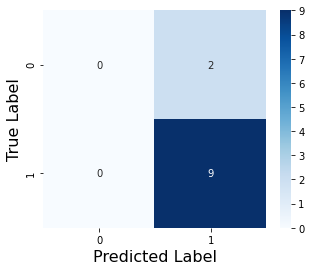

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


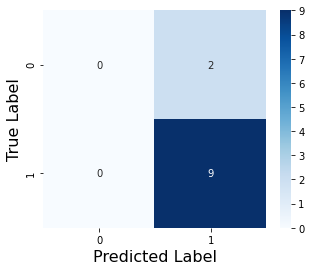

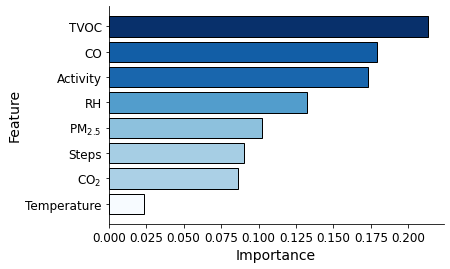

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


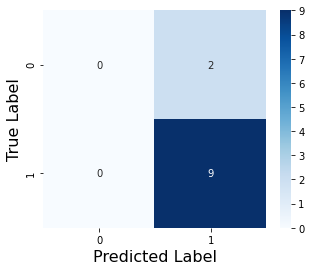

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		0.375
		0.562
	Average:	0.716
	Model Score: 0.918
Evaluating...


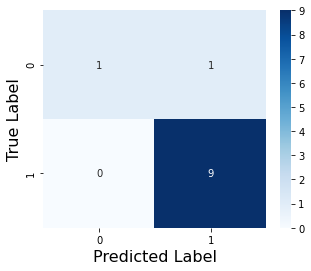

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.123407
		Best Score:	0.43
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.687709
		Best Score:	0.5700000000000001
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065516
		Best Score:	0.3
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.371182
		Best Score:	0.58
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.58
		Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.85
		0.833
		0.167
		0.5
	Average:	0.59
	Model Score: 0.57
Evaluating...


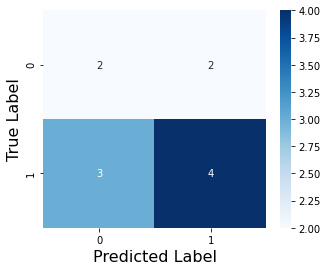

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.85
		0.5
		0.167
		0.5
	Average:	0.573
	Model Score: 0.519
Evaluating...


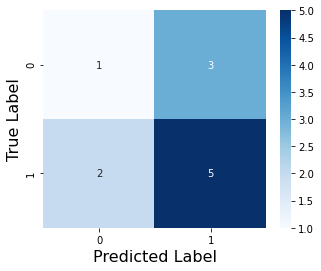

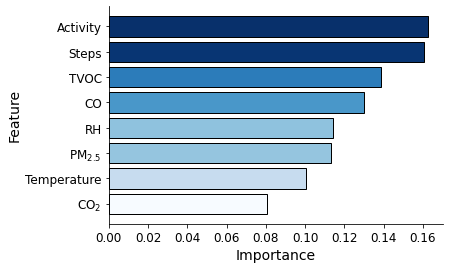

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.85
		0.0
		0.167
		0.5
	Average:	0.463
	Model Score: 0.606
Evaluating...


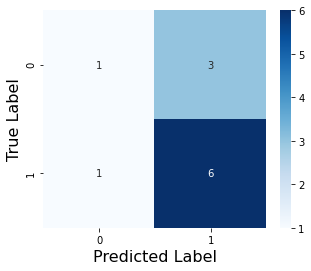

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.36
		0.167
		0.0
		0.375
	Average:	0.267
	Model Score: 0.72
Evaluating...


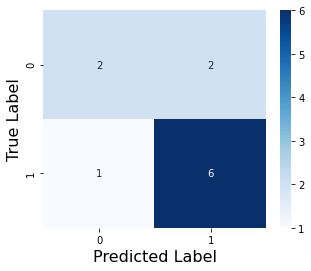

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118072
		Best Score:	0.73
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.549598
		Best Score:	0.73
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.098352
		Best Score:	0.6900000000000001
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.359531
		Best Score:	0.73
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.73
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.669
Evaluating...


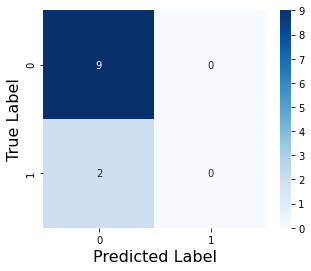

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.636
Evaluating...


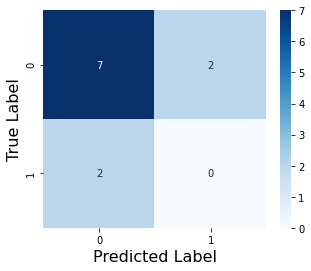

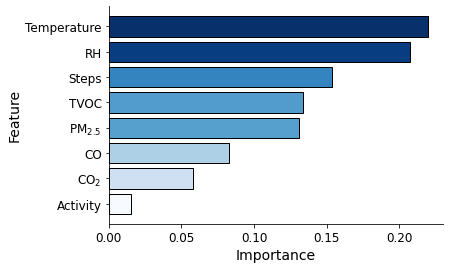

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.655
Evaluating...


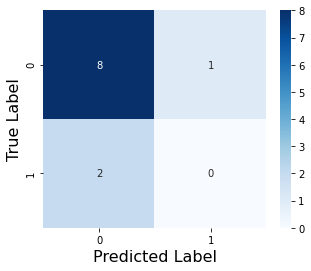

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.36
		0.562
		0.875
		0.562
	Average:	0.592
	Model Score: 0.636
Evaluating...


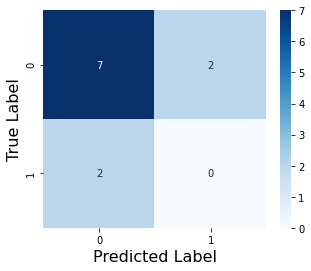

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117028
		Best Score:	0.77
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.959482
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064322
		Best Score:	0.77
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333104
		Best Score:	0.82
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.82
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


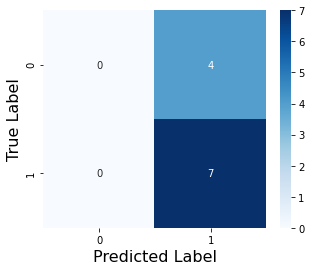

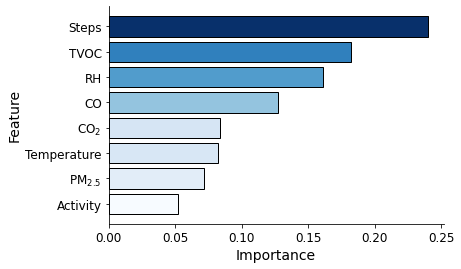

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


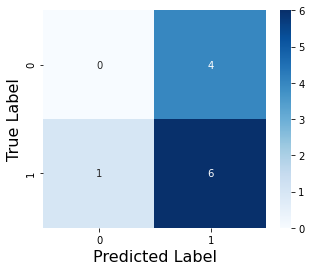

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


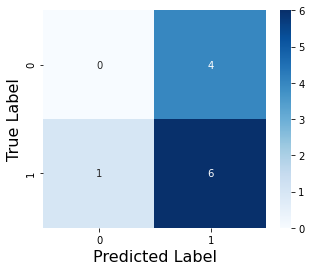

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.833
		0.562
	Average:	0.735
	Model Score: 0.354
Evaluating...


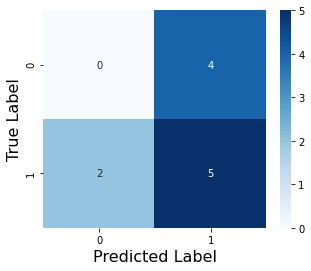

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117743
		Best Score:	0.82
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.685848
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062870
		Best Score:	0.78
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.375983
		Best Score:	0.82
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.82
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


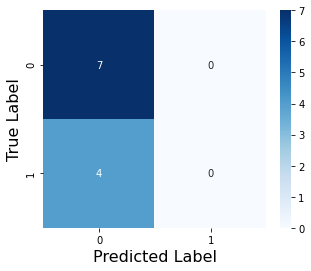

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


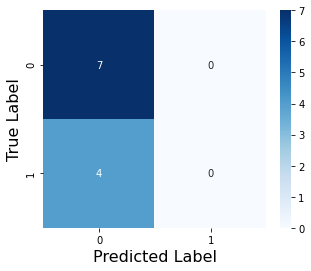

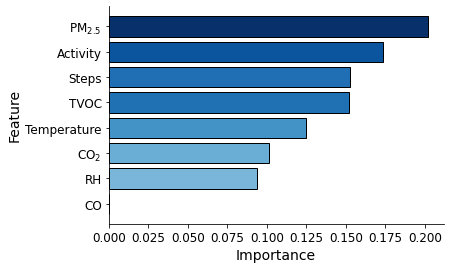

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


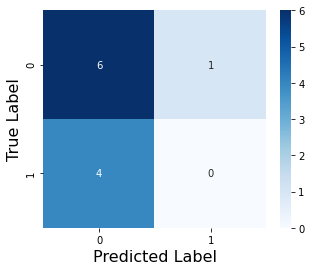

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.64
		1.0
		0.562
		0.562
	Average:	0.673
	Model Score: 0.405
Evaluating...


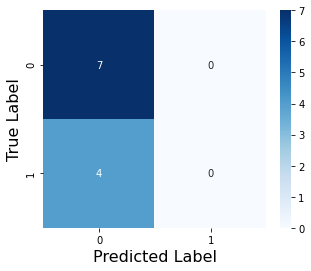

'BernoulliNB' object has no attribute 'feature_importances_'
ITMYLZ3G
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.110721
		Best Score:	0.75
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.191946
		Best Score:	0.8
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064572
		Best Score:	0.65
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.328497
		Best Score:	0.8
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.562
		1.0
		0.833
		0.25
	Average:	0.729
	Model Score: 0.715
Evaluating...


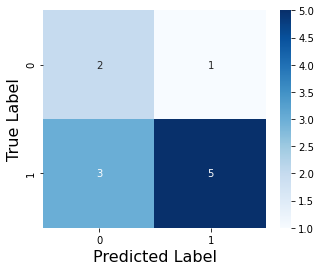

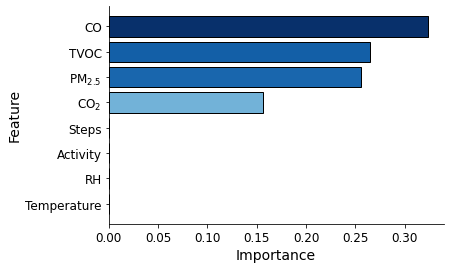

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.562
		1.0
		0.833
		0.25
	Average:	0.729
	Model Score: 0.539
Evaluating...


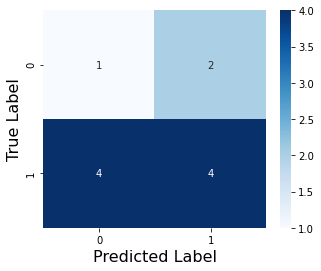

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		0.833
		0.25
	Average:	0.642
	Model Score: 0.636
Evaluating...


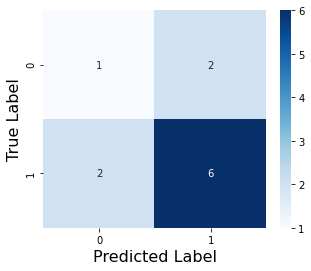

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.5
		1.0
		0.25
		0.167
	Average:	0.583
	Model Score: 0.588
Evaluating...


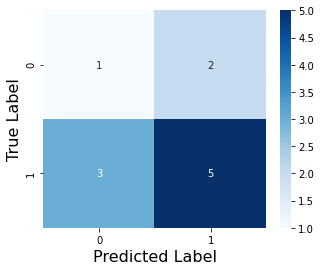

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.114013
		Best Score:	0.7
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.089952
		Best Score:	0.65
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063739
		Best Score:	0.55
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330979
		Best Score:	0.65
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.7
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		1.0
		0.562
		0.562
	Average:	0.575
	Model Score: 0.485
Evaluating...


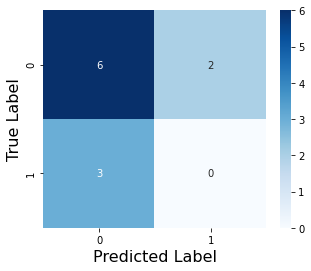

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		0.562
		0.562
		0.562
	Average:	0.488
	Model Score: 0.818
Evaluating...


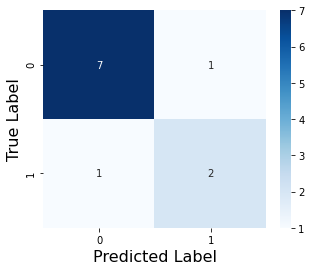

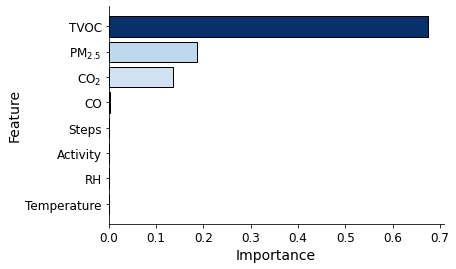

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.562
		0.5
		0.562
		0.562
	Average:	0.488
	Model Score: 0.715
Evaluating...


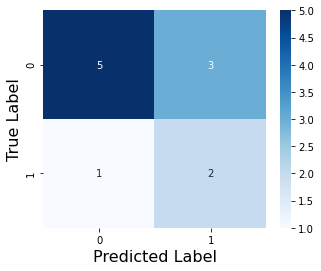

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		0.5
		0.562
		0.5
	Average:	0.462
	Model Score: 0.636
Evaluating...


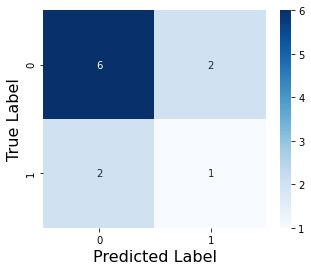

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.109872
		Best Score:	0.45
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.217116
		Best Score:	0.45
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064242
		Best Score:	0.45
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.365845
		Best Score:	0.4
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.45
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.25
		0.5
		0.167
		0.25
	Average:	0.333
	Model Score: 0.539
Evaluating...


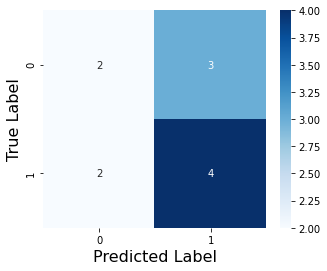

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.25
		0.5
		0.167
		0.167
	Average:	0.392
	Model Score: 0.555
Evaluating...


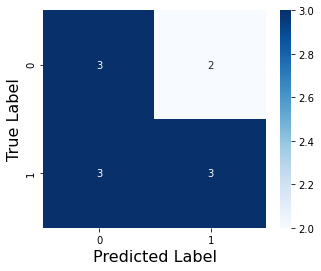

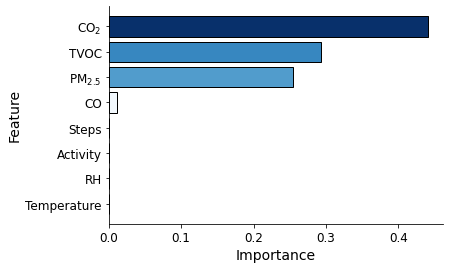

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.833
		0.5
		0.167
		0.167
	Average:	0.433
	Model Score: 0.455
Evaluating...


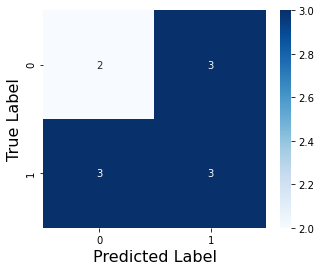

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.375
		0.167
		0.5
		0.25
		0.25
	Average:	0.308
	Model Score: 0.455
Evaluating...


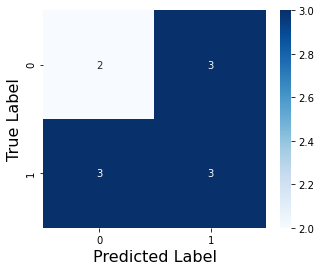

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.136263
		Best Score:	0.6
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.873716
		Best Score:	0.55
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063941
		Best Score:	0.55
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333232
		Best Score:	0.55
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.6
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.833
		0.25
		0.25
		0.5
	Average:	0.542
	Model Score: 0.83
Evaluating...


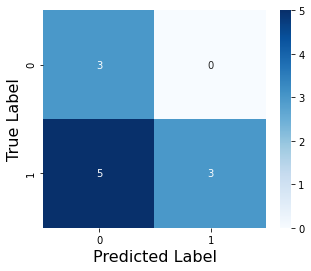

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.25
		0.25
		0.25
		0.5
	Average:	0.425
	Model Score: 0.864
Evaluating...


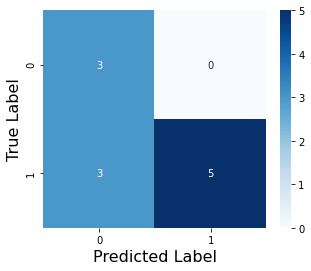

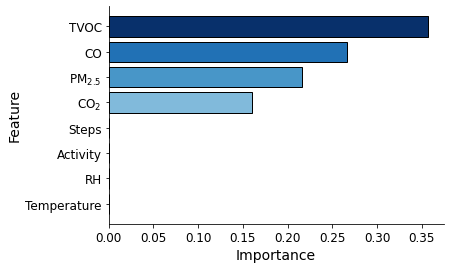

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.833
		0.833
		0.833
		0.25
		0.167
	Average:	0.583
	Model Score: 0.864
Evaluating...


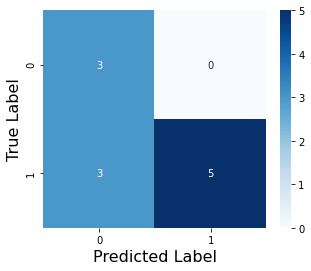

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.833
		0.25
		0.833
		0.25
		0.5
	Average:	0.533
	Model Score: 0.864
Evaluating...


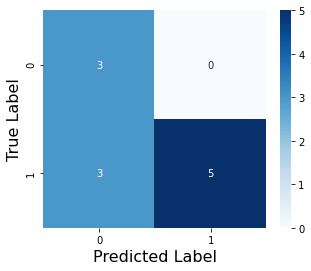

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127651
		Best Score:	0.75
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.928378
		Best Score:	0.75
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067283
		Best Score:	0.75
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.327859
		Best Score:	0.75
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.75
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


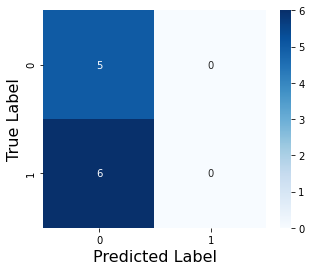

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


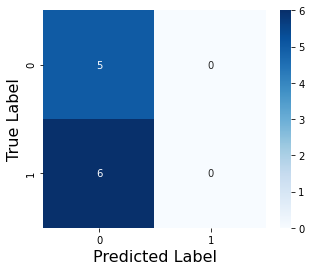

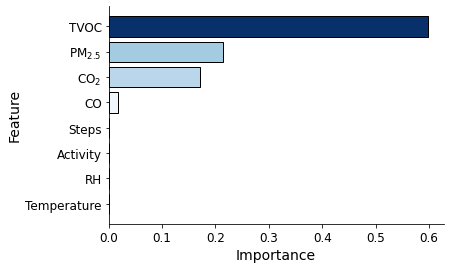

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


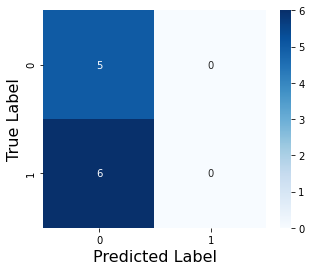

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


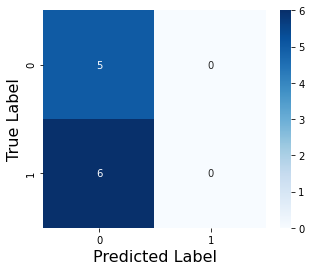

'KNeighborsClassifier' object has no attribute 'feature_importances_'
QH34M4R9
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117363
		Best Score:	0.9
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.900338
		Best Score:	0.9
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062925
		Best Score:	0.9
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.334229
		Best Score:	0.9
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.9
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


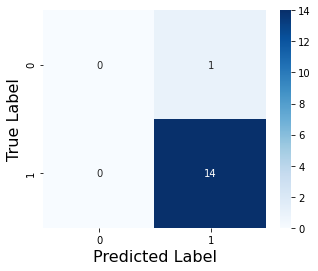

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


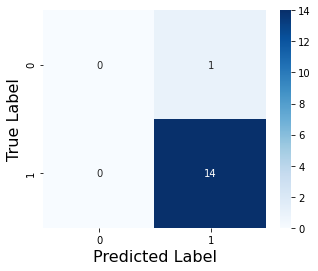

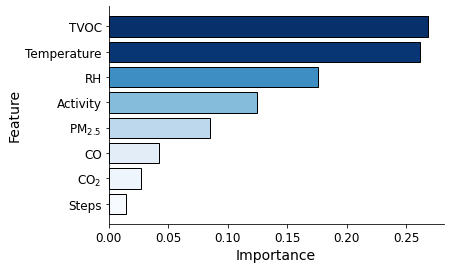

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.867
Evaluating...


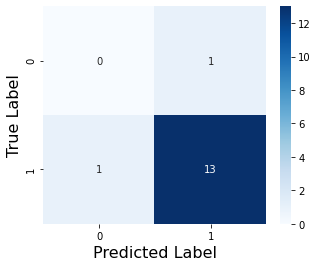

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


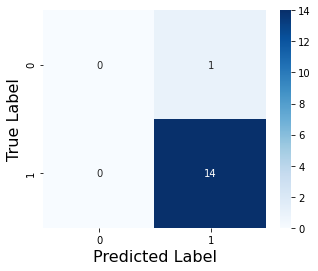

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118824
		Best Score:	0.7666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.055675
		Best Score:	0.8
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067576
		Best Score:	0.7333333333333334
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.337978
		Best Score:	0.7666666666666666
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.867
	Average:	0.723
	Model

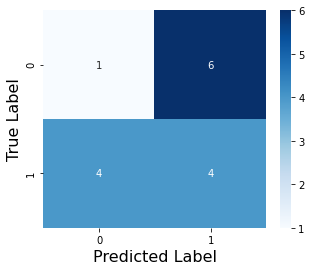

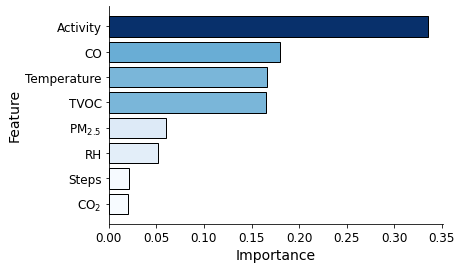

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.444
	Average:	0.639
	Model Score: 0.284
Evaluating...


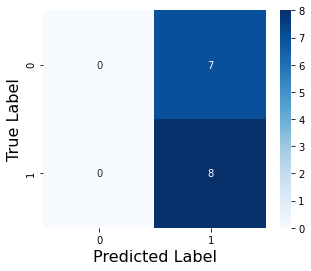

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.444
	Average:	0.639
	Model Score: 0.521
Evaluating...


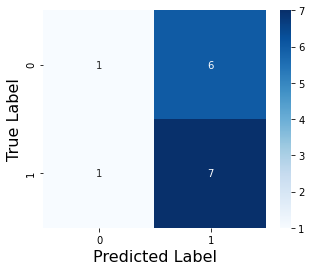

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.667
		0.625
		0.867
	Average:	0.709
	Model Score: 0.246
Evaluating...


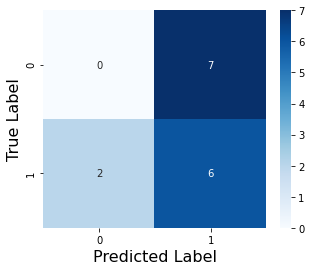

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124516
		Best Score:	0.5000000000000001
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.224497
		Best Score:	0.5666666666666667
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065112
		Best Score:	0.5
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.340076
		Best Score:	0.5666666666666667
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.567
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.4
		0.867
		0.333
		0.667
	Average:	0.503
	Mod

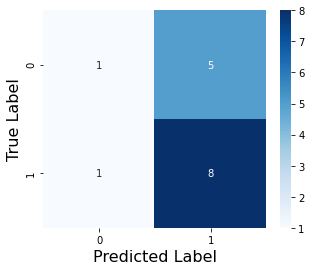

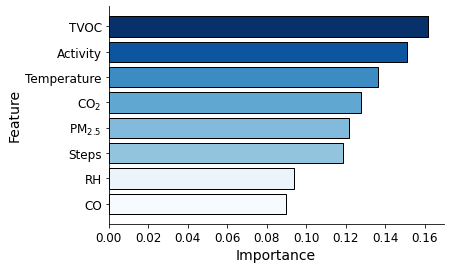

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.333
		0.867
		0.556
		0.8
	Average:	0.671
	Model Score: 0.582
Evaluating...


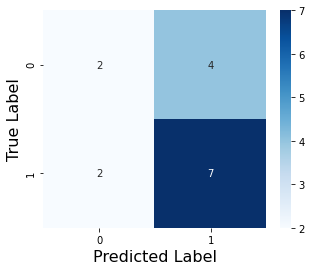

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.867
		0.444
		0.333
		0.333
	Average:	0.436
	Model Score: 0.36
Evaluating...


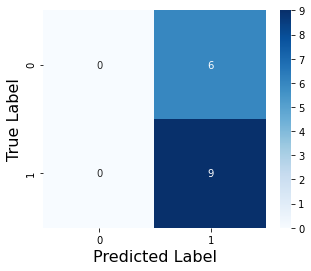

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.667
		0.444
		0.333
		0.4
	Average:	0.409
	Model Score: 0.483
Evaluating...


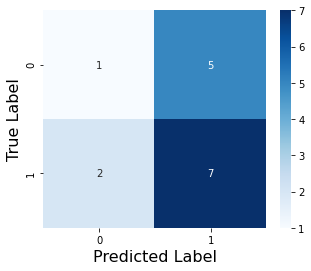

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.133889
		Best Score:	0.6666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.008854
		Best Score:	0.8
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063853
		Best Score:	0.7333333333333334
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330563
		Best Score:	0.7333333333333333
		Best Params:	{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		0.867
		0.667
		0.444
	Average:	0.734
	Model 

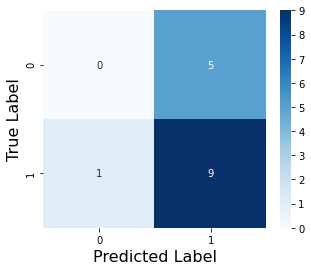

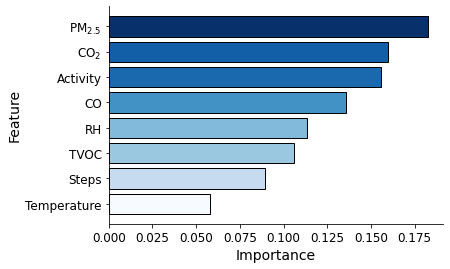

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.867
		0.444
		0.4
		0.867
	Average:	0.654
	Model Score: 0.652
Evaluating...


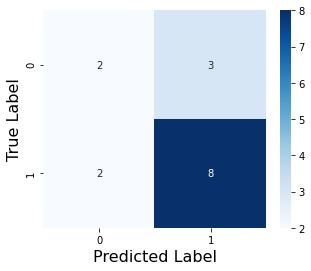

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.667
		0.867
		0.867
		0.667
		0.444
	Average:	0.702
	Model Score: 0.6
Evaluating...


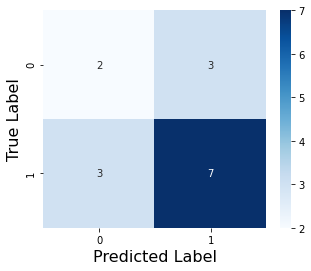

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.444
		0.444
		0.4
		0.444
	Average:	0.486
	Model Score: 0.628
Evaluating...


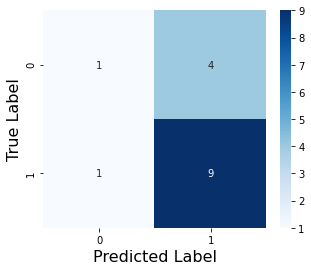

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124568
		Best Score:	0.6000000000000001
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.447419
		Best Score:	0.7000000000000001
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065385
		Best Score:	0.6000000000000001
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.338618
		Best Score:	0.6666666666666667
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.7
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.875
		0.875
		0.875
		0.333


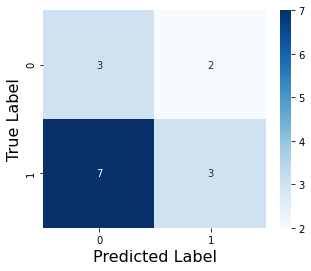

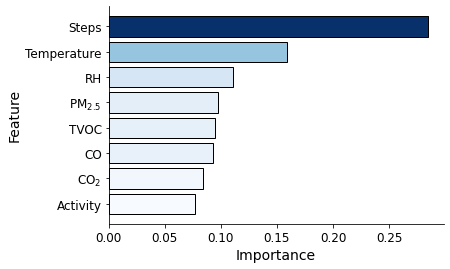

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.875
		0.875
		0.875
		0.333
	Average:	0.642
	Model Score: 0.424
Evaluating...


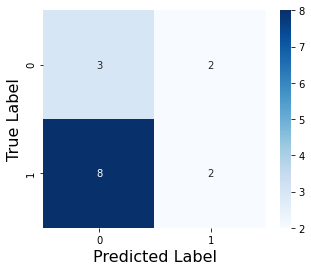

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.25
		0.875
		0.875
		0.333
	Average:	0.517
	Model Score: 0.5
Evaluating...


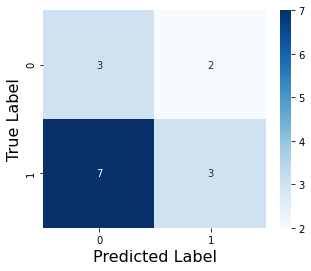

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.25
		0.875
		0.875
		0.333
	Average:	0.517
	Model Score: 0.5
Evaluating...


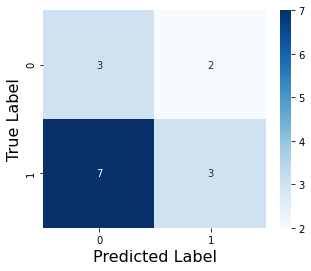

'BernoulliNB' object has no attribute 'feature_importances_'
LKKJDDAM
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.129730
		Best Score:	0.5619047619047619
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.496900
		Best Score:	0.6285714285714286
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064838
		Best Score:	0.5333333333333333
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.344355
		Best Score:	0.5095238095238096
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.629
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.457
		0.886
		0.229
		1.0
	Averag

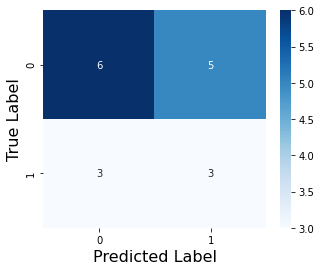

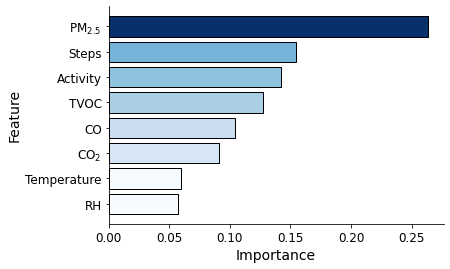

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.595
		0.595
		0.229
		0.8
	Average:	0.606
	Model Score: 0.68
Evaluating...


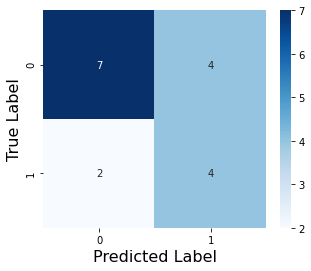

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.229
		0.595
		0.429
		0.8
	Average:	0.572
	Model Score: 0.489
Evaluating...


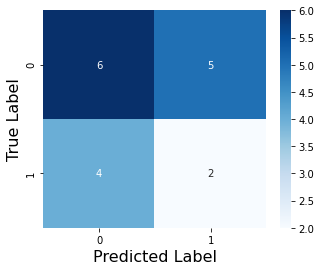

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.457
		0.457
		0.229
		0.875
	Average:	0.523
	Model Score: 0.448
Evaluating...


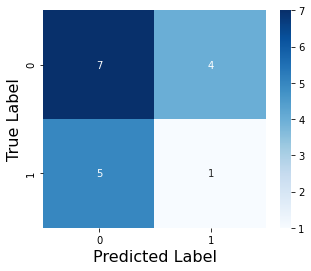

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.119131
		Best Score:	0.7666666666666667
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.137406
		Best Score:	0.7666666666666667
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064167
		Best Score:	0.6714285714285715
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.335773
		Best Score:	0.7952380952380953
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.795
		Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.735
		0.51
		0.51
		0.694
	Average:	0.637
	Model Score: 0.

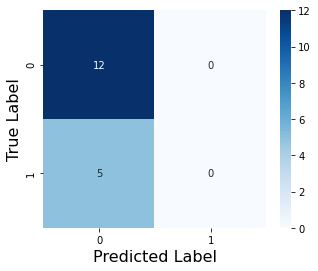

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.51
		0.51
		0.694
	Average:	0.633
	Model Score: 0.498
Evaluating...


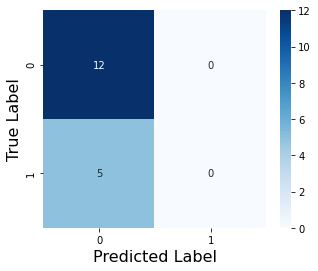

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.51
		0.51
		0.694
	Average:	0.633
	Model Score: 0.498
Evaluating...


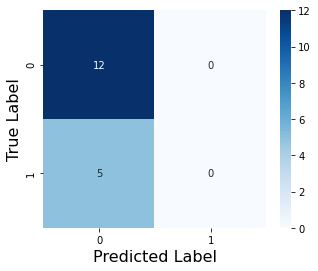

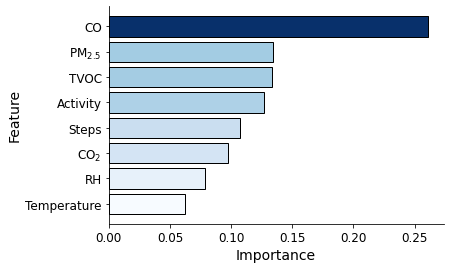

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.476
		0.51
		0.625
	Average:	0.612
	Model Score: 0.498
Evaluating...


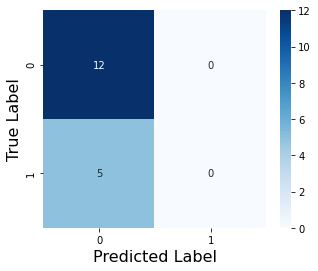

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.134811
		Best Score:	0.4714285714285714
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.362196
		Best Score:	0.5285714285714286
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.071827
		Best Score:	0.5285714285714286
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.343109
		Best Score:	0.5
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.529
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.327
		0.557
		0.327
		0.286
		0.4
	Average:	0.379
	M

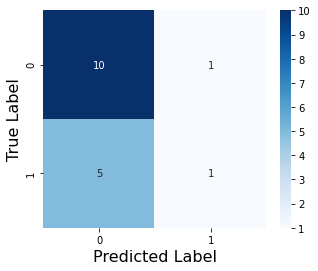

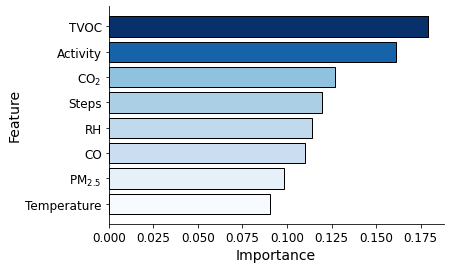

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.286
		0.457
		0.429
		0.886
		0.4
	Average:	0.491
	Model Score: 0.608
Evaluating...


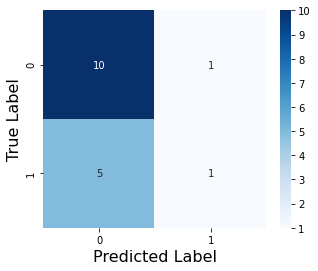

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.286
		0.429
		0.557
		0.327
		0.4
	Average:	0.4
	Model Score: 0.608
Evaluating...


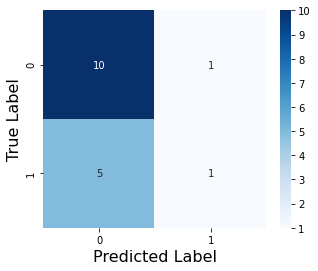

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.327
		0.557
		0.429
		0.229
		0.4
	Average:	0.388
	Model Score: 0.608
Evaluating...


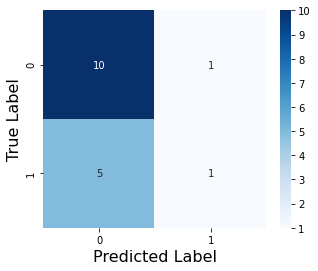

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127711
		Best Score:	0.4904761904761904
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.540758
		Best Score:	0.619047619047619
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067727
		Best Score:	0.619047619047619
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.397168
		Best Score:	0.5285714285714286
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.619
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.886
		0.457
		0.286
		0.714
		0.667

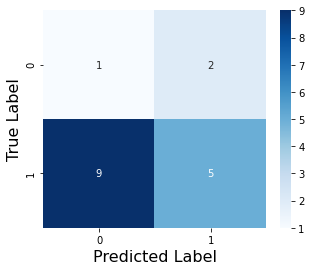

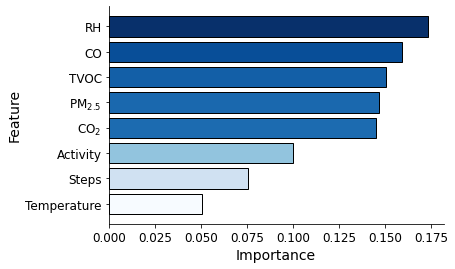

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.886
		0.457
		0.286
		0.714
		0.833
	Average:	0.635
	Model Score: 0.606
Evaluating...


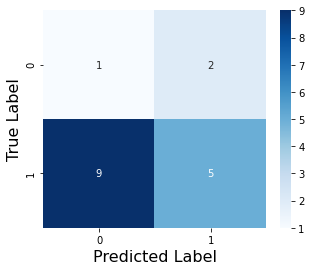

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.595
		0.286
		0.595
		0.8
	Average:	0.574
	Model Score: 0.606
Evaluating...


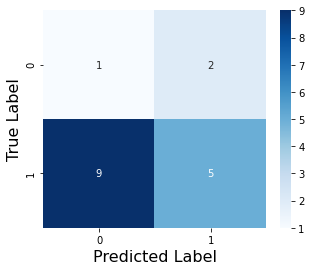

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.595
		0.286
		0.557
		0.222
	Average:	0.494
	Model Score: 0.663
Evaluating...


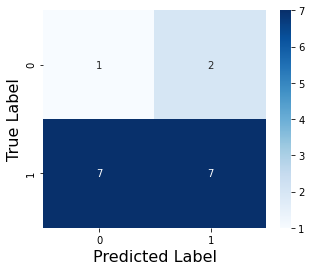

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.149741
		Best Score:	0.5857142857142856
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:20.559172
		Best Score:	0.680952380952381
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.094252
		Best Score:	0.4666666666666666
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.489094
		Best Score:	0.6761904761904762
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.681
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.893
		0.457
		0.714
		0.875


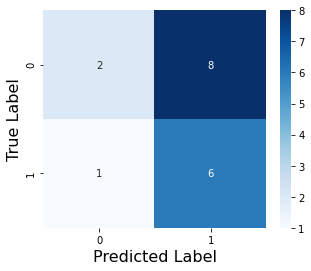

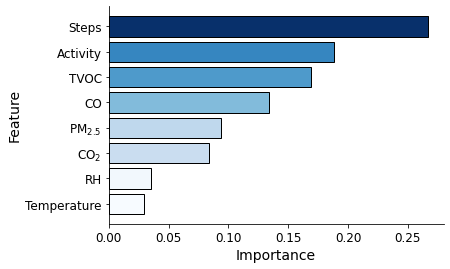

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		1.0
		0.457
		0.714
		0.667
	Average:	0.687
	Model Score: 0.459
Evaluating...


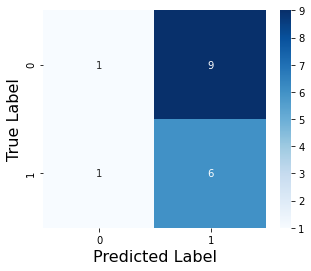

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.886
		0.143
		0.81
		0.5
	Average:	0.587
	Model Score: 0.452
Evaluating...


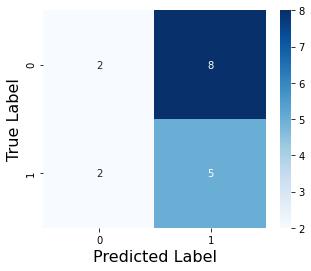

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.595
		0.143
		0.557
		0.2
	Average:	0.418
	Model Score: 0.444
Evaluating...


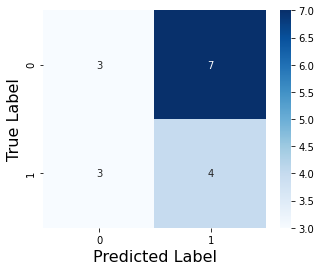

'BernoulliNB' object has no attribute 'feature_importances_'
VR9J5RRY
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.209135
		Best Score:	nan
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.963017
		Best Score:	0.96
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062931
		Best Score:	0.96
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.346976
		Best Score:	0.96
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.96
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


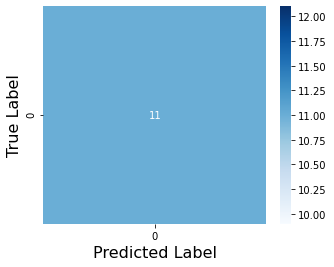

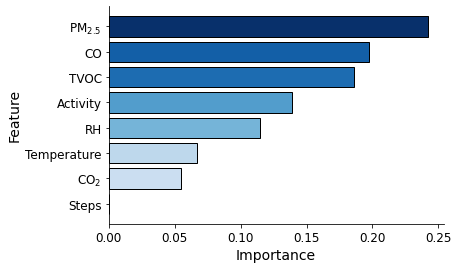

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


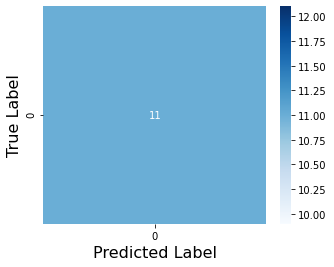

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


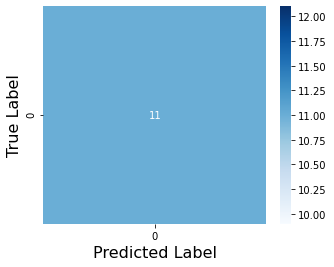

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		nan
		1.0
		1.0
		1.0
		1.0
	Average:	nan
	Model Score: 1.0
Evaluating...


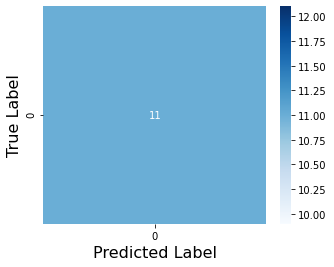

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113158
		Best Score:	0.42000000000000004
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.667524
		Best Score:	0.42000000000000004
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063977
		Best Score:	0.38
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.326071
		Best Score:	0.37
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.42
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.833
		0.25
		0.0
		0.25
	Average:	0.339
	Model Score: 0.455
Evaluating...


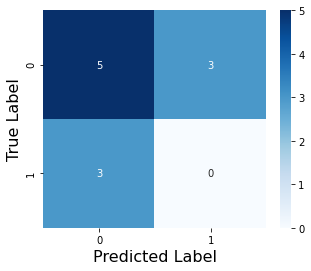

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.833
		0.25
		0.0
		0.25
	Average:	0.339
	Model Score: 0.416
Evaluating...


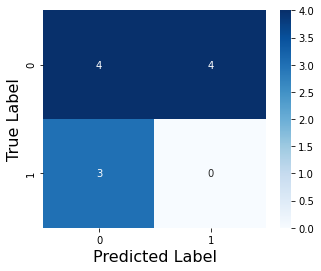

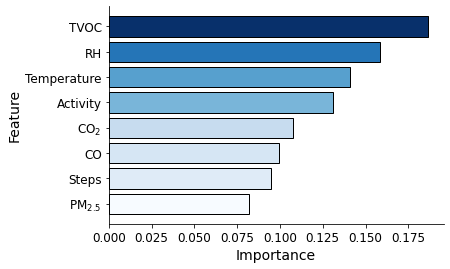

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.833
		0.25
		0.0
		0.25
	Average:	0.327
	Model Score: 0.539
Evaluating...


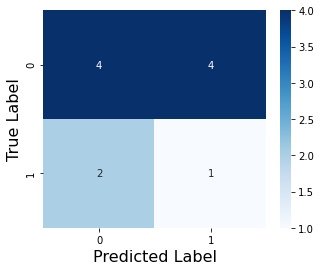

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.375
		0.25
		0.0
		0.25
	Average:	0.247
	Model Score: 0.588
Evaluating...


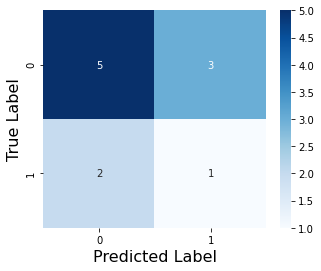

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113801
		Best Score:	0.76
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.949230
		Best Score:	0.76
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064053
		Best Score:	0.67
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.335564
		Best Score:	0.76
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.76
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.529
Evaluating...


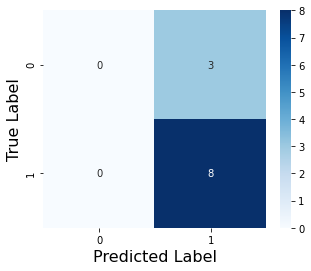

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.529
Evaluating...


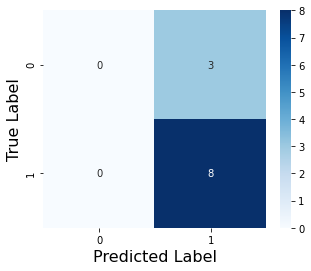

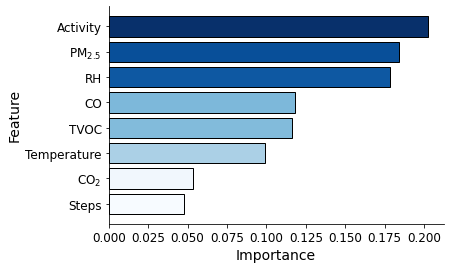

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.509
Evaluating...


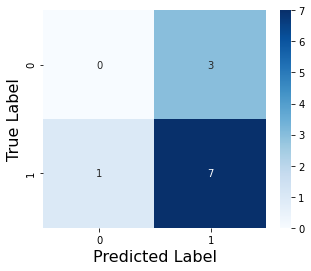

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.562
		0.5
		0.562
		0.562
	Average:	0.558
	Model Score: 0.855
Evaluating...


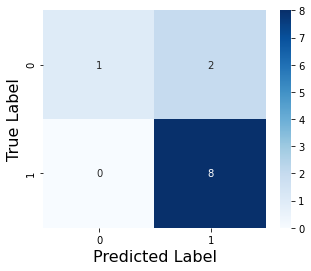

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.116027
		Best Score:	0.15
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.965224
		Best Score:	0.39
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063280
		Best Score:	0.1
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.331560
		Best Score:	0.45
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.45
		Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.25
		1.0
		0.167
		0.5
	Average:	0.383
	Model Score: 0.303
Evaluating...


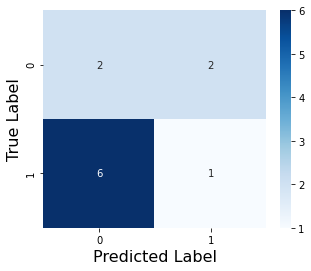

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.833
		0.833
		0.167
		0.0
	Average:	0.407
	Model Score: 0.422
Evaluating...


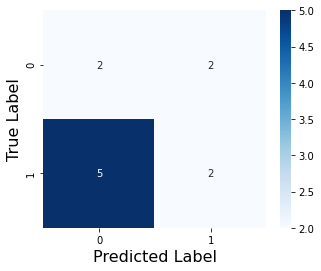

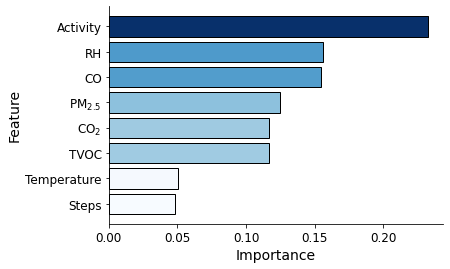

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.0
		0.5
		0.0
		0.167
	Average:	0.133
	Model Score: 0.315
Evaluating...


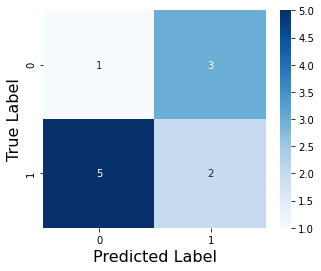

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.0
		0.167
		0.167
		0.0
	Average:	0.067
	Model Score: 0.273
Evaluating...


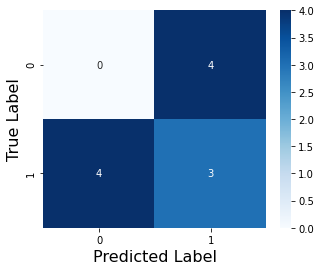

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112168
		Best Score:	0.5599999999999999
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.929374
		Best Score:	0.8
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.069249
		Best Score:	0.45999999999999996
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.328639
		Best Score:	0.75
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.875
		0.875
		0.833
		0.833
	Average:	0.883
	Model Score: 0.685
E

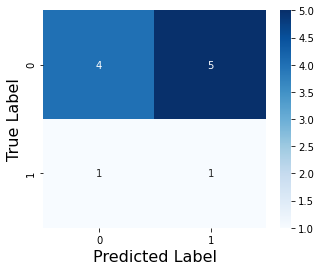

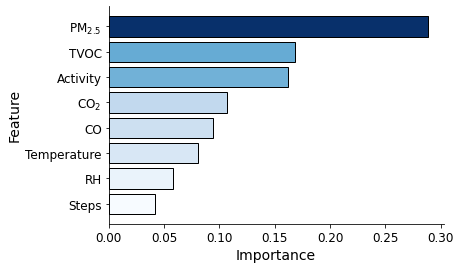

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.875
		0.5
		0.833
		0.833
	Average:	0.808
	Model Score: 0.685
Evaluating...


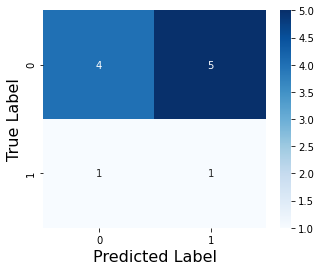

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.875
		0.5
		0.167
		0.25
	Average:	0.528
	Model Score: 0.614
Evaluating...


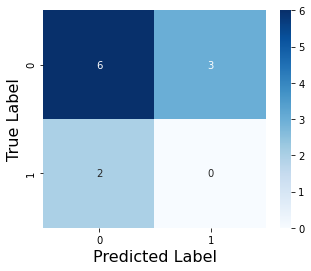

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.875
		0.375
		0.167
		0.167
	Average:	0.487
	Model Score: 0.614
Evaluating...


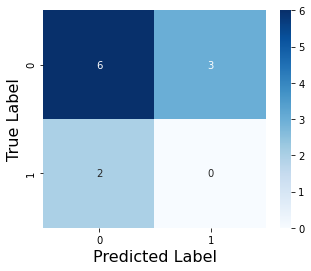

'BernoulliNB' object has no attribute 'feature_importances_'
AWA8UCES
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.104897
		Best Score:	0.67
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:15.874001
		Best Score:	0.67
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063030
		Best Score:	0.62
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.326616
		Best Score:	0.6599999999999999
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.67
		Params:	{'fit_intercept': True, 'sol

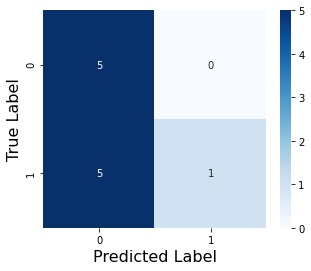

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.5
		1.0
		0.562
		0.25
	Average:	0.582
	Model Score: 0.798
Evaluating...


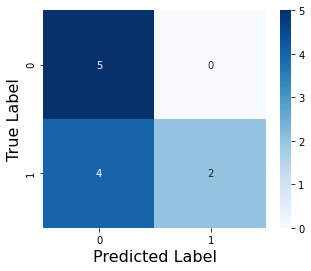

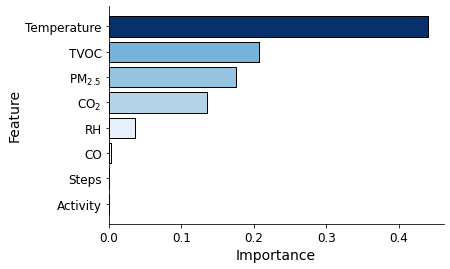

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.562
		0.5
		0.562
		0.25
	Average:	0.545
	Model Score: 0.798
Evaluating...


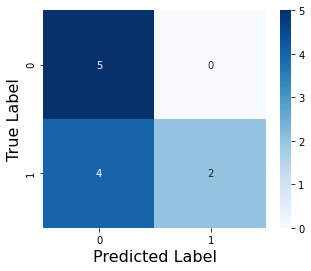

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.5
		0.833
		1.0
		0.25
	Average:	0.637
	Model Score: 0.83
Evaluating...


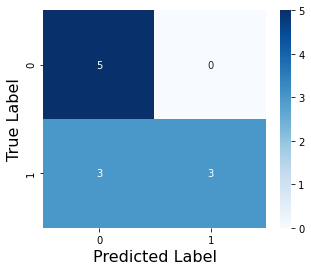

'BernoulliNB' object has no attribute 'feature_importances_'
Only 1 unique value for light percent
Only 1 unique value for deep percent
Only 1 unique value for rem percent
TMEXEJ5V
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.100020
		Best Score:	nan
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.791365
		Best Score:	0.9666666666666668
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062909
		Best Score:	0.9666666666666668
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.328277
		Best Score:	0.9666666666666668
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.967
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST


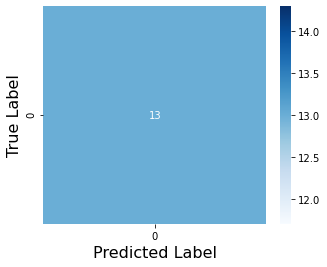

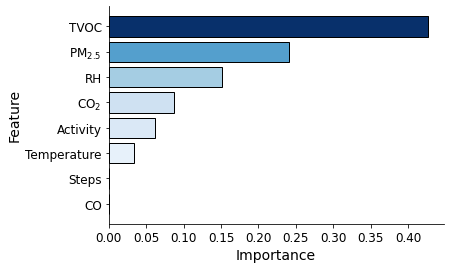

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		1.0
		1.0
		1.0
	Average:	0.939
	Model Score: 1.0
Evaluating...


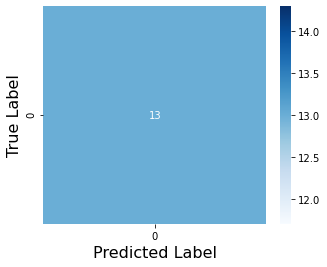

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		1.0
		1.0
		1.0
	Average:	0.939
	Model Score: 1.0
Evaluating...


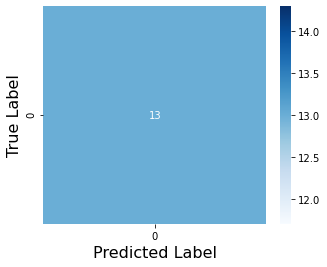

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		nan
		1.0
		1.0
		1.0
		1.0
	Average:	nan
	Model Score: 1.0
Evaluating...


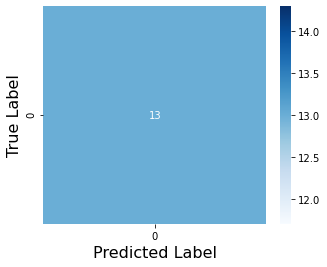

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.107058
		Best Score:	0.49333333333333335
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.869140
		Best Score:	0.5733333333333334
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063872
		Best Score:	0.38
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.326987
		Best Score:	0.5
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.573
		Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.85
		0.3
		0.3
		0.36
	Average:	0.451
	Model Score: 0.436
Eval

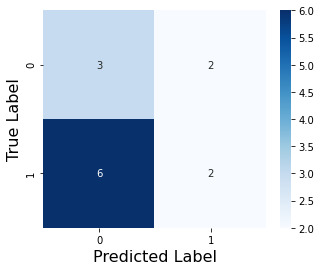

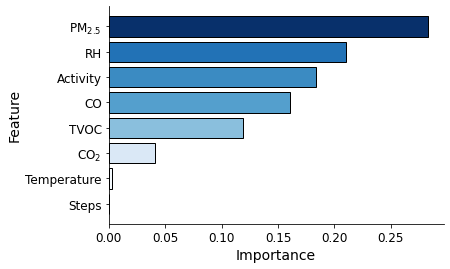

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.4
		0.3
		0.36
		0.3
		0.36
	Average:	0.344
	Model Score: 0.79
Evaluating...


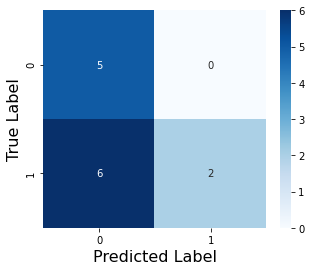

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.667
		0.433
		0.433
		0.3
		0.36
	Average:	0.439
	Model Score: 0.564
Evaluating...


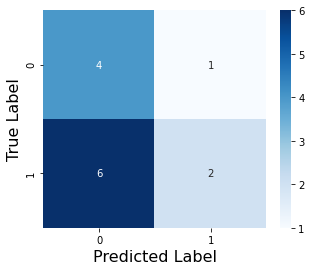

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.4
		0.1
		0.2
		0.3
		0.36
	Average:	0.272
	Model Score: 0.448
Evaluating...


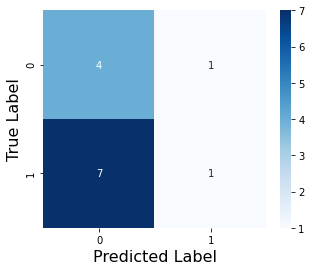

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.107097
		Best Score:	0.54
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.930233
		Best Score:	0.62
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063540
		Best Score:	0.5
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.329145
		Best Score:	0.6533333333333333
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.653
		Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.6
		0.36
		0.36
		0.85
	Average:	0.594
	Model Score: 0.215
Evaluating...


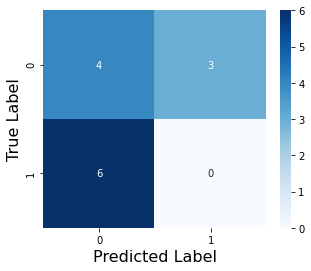

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.6
		0.867
		0.36
		0.36
	Average:	0.487
	Model Score: 0.53
Evaluating...


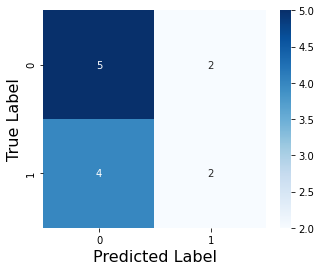

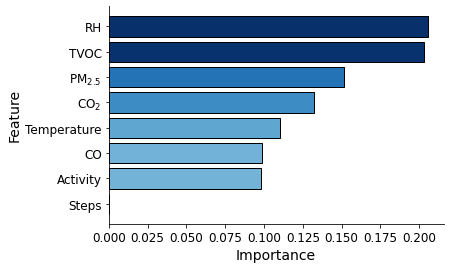

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.6
		0.36
		0.36
		0.3
	Average:	0.374
	Model Score: 0.631
Evaluating...


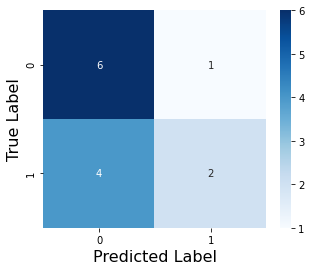

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.6
		0.3
		0.36
		0.3
	Average:	0.362
	Model Score: 0.631
Evaluating...


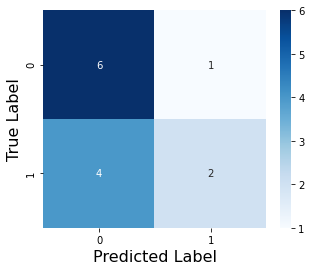

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111670
		Best Score:	0.8466666666666667
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.832118
		Best Score:	0.8466666666666667
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063412
		Best Score:	0.8133333333333332
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.325734
		Best Score:	0.8466666666666667
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.847
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		0.64
		0.64
		0.64
	Average:	0.723
	Model Score: 0.479
E

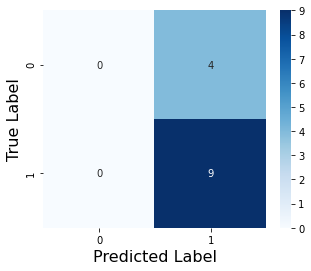

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		0.64
		0.64
		0.64
	Average:	0.723
	Model Score: 0.479
Evaluating...


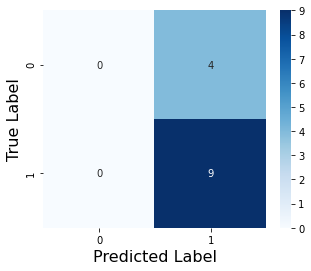

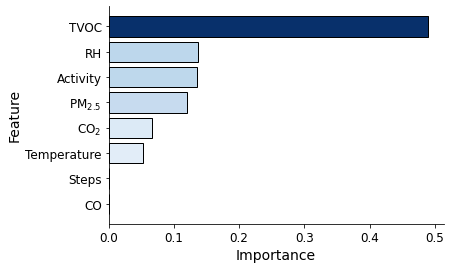

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		0.64
		0.64
		0.64
	Average:	0.723
	Model Score: 0.827
Evaluating...


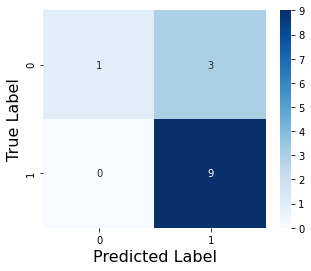

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.667
		1.0
		0.64
		0.6
		1.0
	Average:	0.781
	Model Score: 0.441
Evaluating...


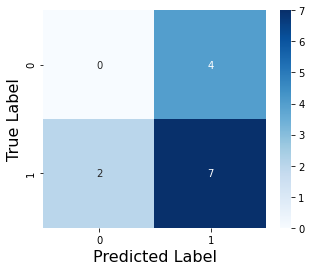

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113040
		Best Score:	0.5
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.207362
		Best Score:	0.6066666666666667
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065019
		Best Score:	0.42000000000000004
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.329776
		Best Score:	0.6066666666666667
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.607
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.867
		0.3
		0.6
		0.36
		0.36
	Average:	0.497
	Model Sc

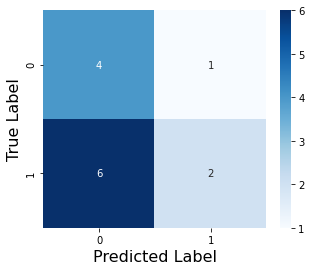

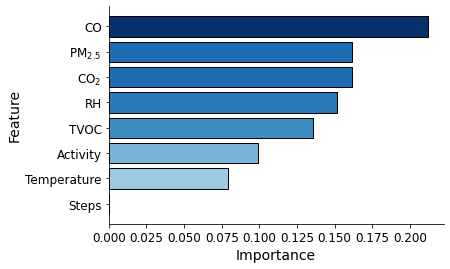

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.867
		0.3
		0.85
		0.3
		0.36
	Average:	0.535
	Model Score: 0.632
Evaluating...


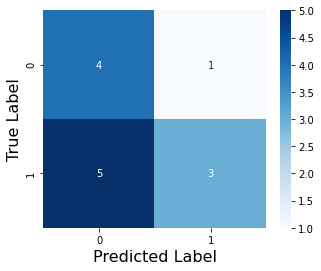

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.4
		0.3
		0.3
		0.36
		0.36
	Average:	0.344
	Model Score: 0.128
Evaluating...


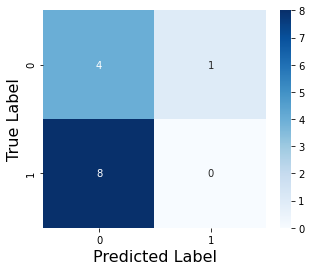

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.4
		0.1
		0.3
		0.36
		0.3
	Average:	0.292
	Model Score: 0.436
Evaluating...


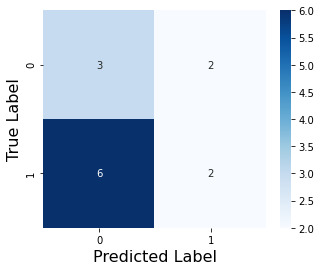

'BernoulliNB' object has no attribute 'feature_importances_'
TLMLQ19S
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121643
		Best Score:	0.8444444444444443
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.280825
		Best Score:	0.8444444444444443
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.069796
		Best Score:	0.8
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.335392
		Best Score:	0.8444444444444443
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.844
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.605
		0.605
		1.0
		0.778
		0.79
	Average:	0.756
	Model Score: 0.913
Evaluating...


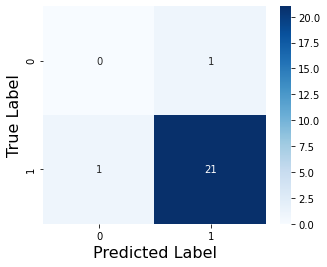

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.903
		0.605
		0.778
		0.79
		0.79
	Average:	0.773
	Model Score: 0.915
Evaluating...


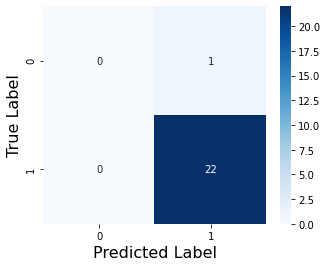

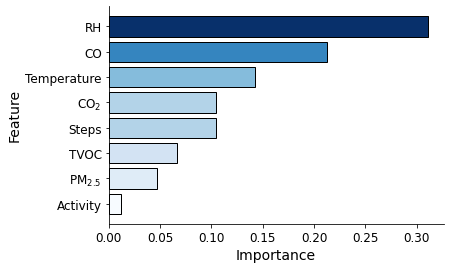

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.605
		0.605
		1.0
		0.778
		0.79
	Average:	0.756
	Model Score: 0.913
Evaluating...


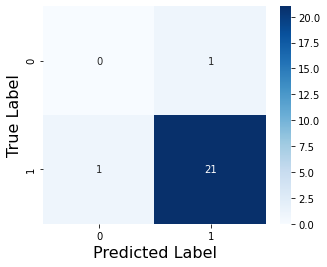

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.556
		0.605
		0.944
		0.944
		0.79
	Average:	0.768
	Model Score: 0.967
Evaluating...


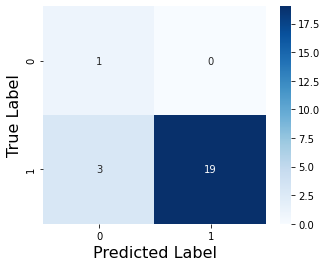

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.122837
		Best Score:	0.7999999999999999
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.019779
		Best Score:	0.8222222222222222
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064286
		Best Score:	0.7999999999999999
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330407
		Best Score:	0.8222222222222222
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.822
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.605
		0.605
		0.605
		0.605
	Average:	0.684


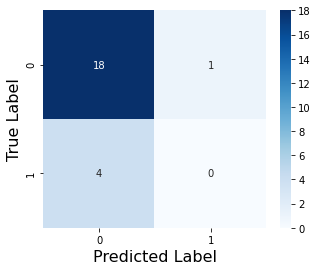

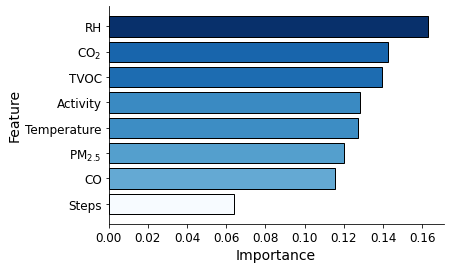

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.605
		0.605
		0.605
		0.605
	Average:	0.684
	Model Score: 0.669
Evaluating...


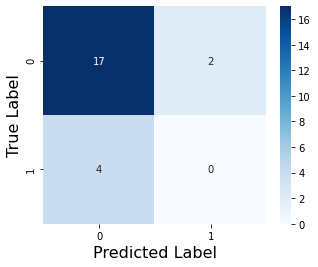

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.79
		0.605
		0.605
		0.605
		0.605
	Average:	0.642
	Model Score: 0.682
Evaluating...


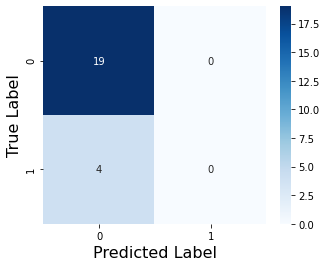

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.79
		0.605
		0.605
		0.605
		0.605
	Average:	0.642
	Model Score: 0.682
Evaluating...


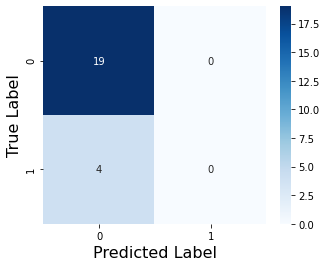

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.125135
		Best Score:	0.6666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.013569
		Best Score:	0.6666666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063671
		Best Score:	0.6444444444444445
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.336245
		Best Score:	0.711111111111111
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.711
		Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.905
		0.444
		0.643
		0.643
		0.583
	Average:	0.644
	Model Score:

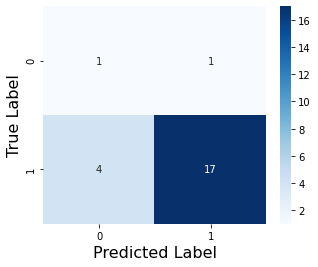

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.643
		0.643
		0.583
	Average:	0.552
	Model Score: 0.896
Evaluating...


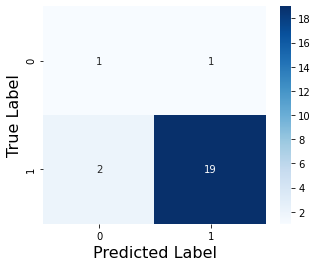

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.417
		0.643
		0.605
	Average:	0.511
	Model Score: 0.913
Evaluating...


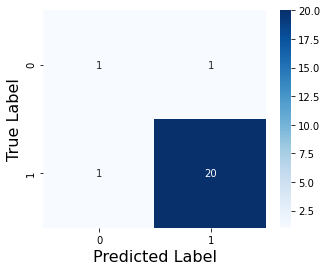

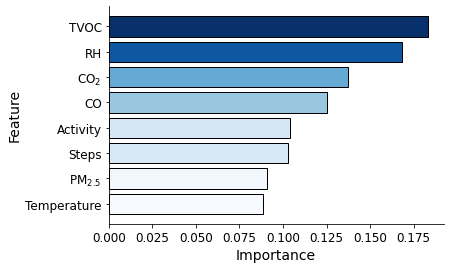

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.7
		0.444
		0.643
		0.643
		0.678
	Average:	0.622
	Model Score: 0.88
Evaluating...


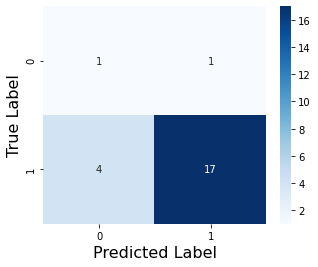

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121020
		Best Score:	0.5555555555555556
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:17.207589
		Best Score:	0.6444444444444445
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065109
		Best Score:	0.5333333333333333
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.347714
		Best Score:	0.6222222222222221
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.644
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.556
		0.907
		0.426
	

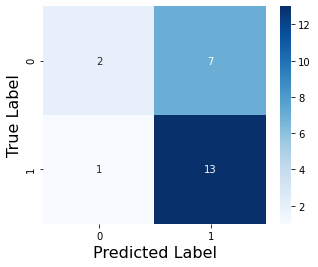

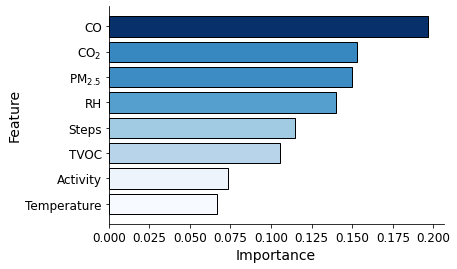

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.643
		0.309
		0.54
	Average:	0.476
	Model Score: 0.496
Evaluating...


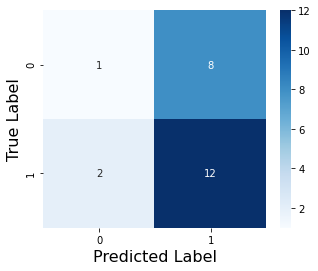

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.381
		0.417
		0.483
		0.792
		0.792
	Average:	0.573
	Model Score: 0.71
Evaluating...


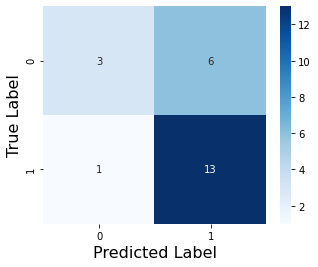

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.381
		0.417
		0.4
		0.792
		0.667
	Average:	0.531
	Model Score: 0.548
Evaluating...


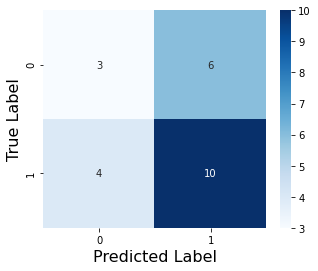

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.126284
		Best Score:	0.5111111111111111
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.923012
		Best Score:	0.711111111111111
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064528
		Best Score:	0.4888888888888888
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.341507
		Best Score:	0.6888888888888889
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.711
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.792
		0.778
		0.852
		0.778
		0.556
	Avera

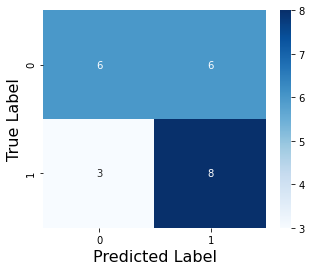

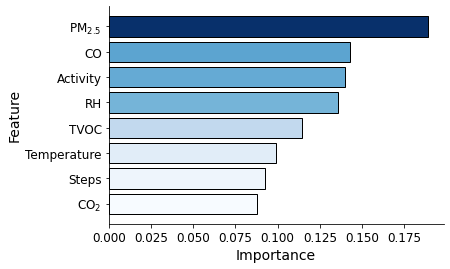

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.792
		0.778
		0.852
		0.792
		0.556
	Average:	0.754
	Model Score: 0.611
Evaluating...


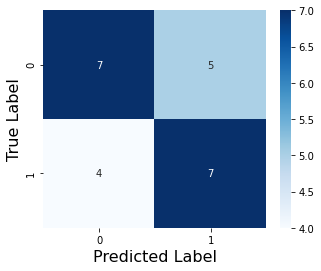

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.278
		0.333
		0.333
		0.667
		0.778
	Average:	0.478
	Model Score: 0.654
Evaluating...


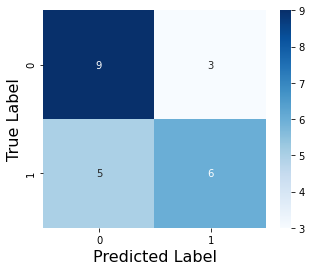

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.238
		0.456
		0.167
		0.54
		0.778
	Average:	0.436
	Model Score: 0.652
Evaluating...


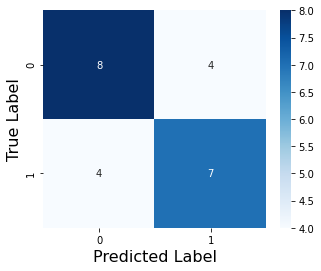

'BernoulliNB' object has no attribute 'feature_importances_'
9JTZSUU8
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.116074
		Best Score:	0.6333333333333333
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 2:27:20.339291
		Best Score:	0.7666666666666666
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.121330
		Best Score:	0.6
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.406222
		Best Score:	0.7
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.767
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		1.0
		0.25
		1.0
	Average:	0.628
	Model Score: 0.327
Ev

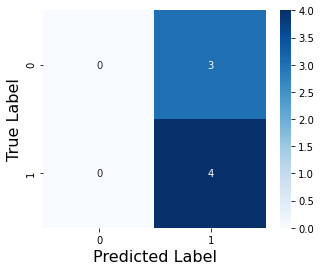

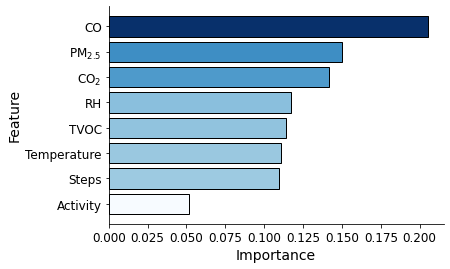

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		0.25
		1.0
	Average:	0.517
	Model Score: 0.81
Evaluating...


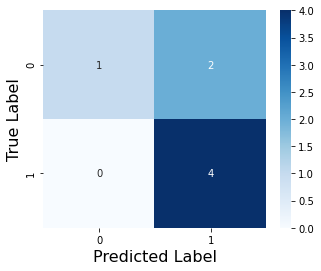

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.333
		0.25
		1.0
	Average:	0.494
	Model Score: 0.327
Evaluating...


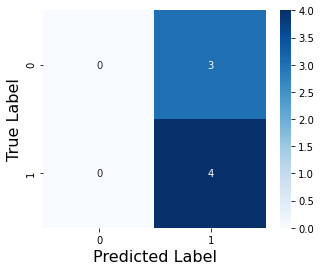

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.833
		0.0
		1.0
	Average:	0.544
	Model Score: 0.429
Evaluating...


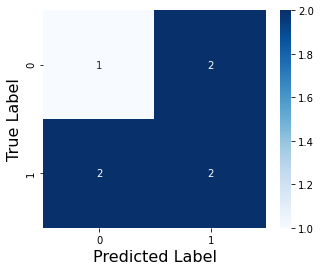

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.141172
		Best Score:	0.8666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:26.467307
		Best Score:	0.8666666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066920
		Best Score:	0.7666666666666666
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.351010
		Best Score:	0.8666666666666666
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.867
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		1.0
		1.0
		1.0
	Average:	0.778
	Model Score: 1.0
Evaluating...

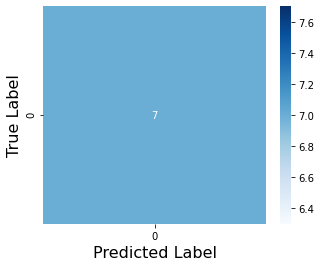

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		1.0
		1.0
		1.0
	Average:	0.778
	Model Score: 1.0
Evaluating...


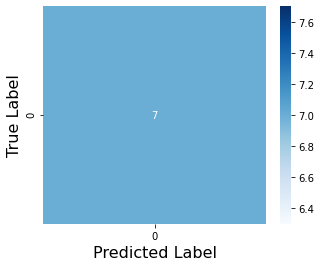

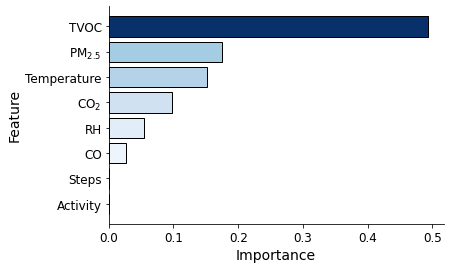

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		1.0
		1.0
		1.0
	Average:	0.778
	Model Score: 1.0
Evaluating...


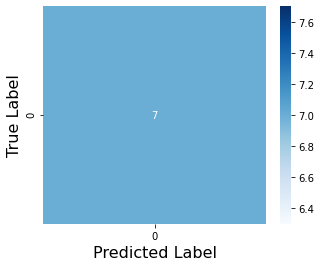

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		1.0
		1.0
		1.0
	Average:	0.778
	Model Score: 1.0
Evaluating...


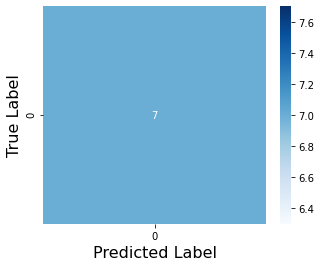

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.107935
		Best Score:	nan
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.702631
		Best Score:	0.9333333333333332
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063490
		Best Score:	0.9333333333333332
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.325811
		Best Score:	0.9333333333333332
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.933
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.444
		1.0
		1.0
	Average:	0.889
	Model Score: 0.51
Ev

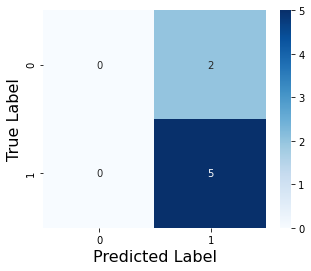

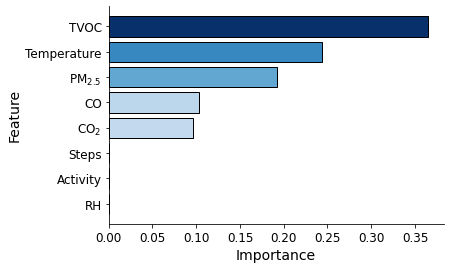

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.444
		1.0
		1.0
	Average:	0.889
	Model Score: 0.51
Evaluating...


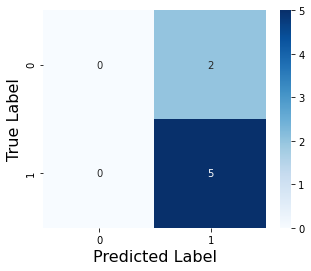

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.444
		1.0
		1.0
	Average:	0.889
	Model Score: 0.51
Evaluating...


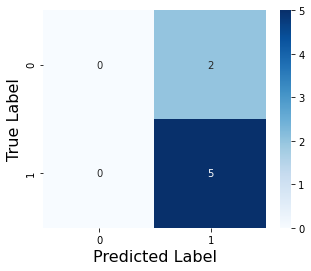

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		nan
		1.0
		1.0
	Average:	nan
	Model Score: 0.51
Evaluating...


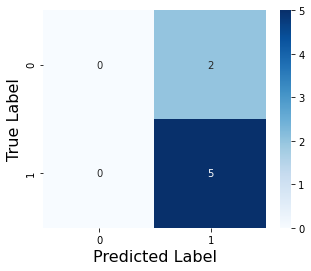

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111394
		Best Score:	0.7
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.398364
		Best Score:	0.7
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.097201
		Best Score:	0.6
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.341471
		Best Score:	0.8
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.8
		Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		1.0
		1.0
	Average:	0.667
	Model Score: 0.735
Evaluating...


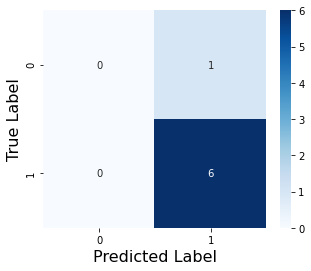

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		1.0
		1.0
	Average:	0.667
	Model Score: 0.735
Evaluating...


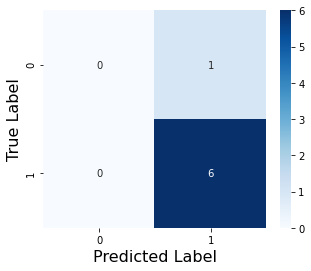

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		1.0
		1.0
	Average:	0.667
	Model Score: 0.735
Evaluating...


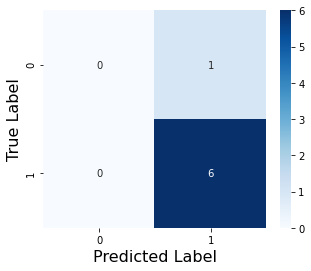

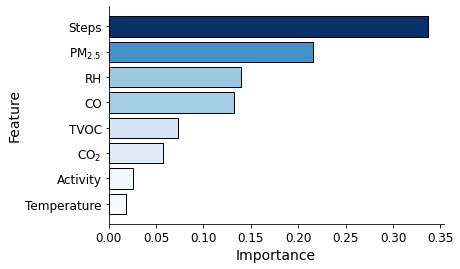

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.833
		0.444
		1.0
		1.0
	Average:	0.744
	Model Score: 0.714
Evaluating...


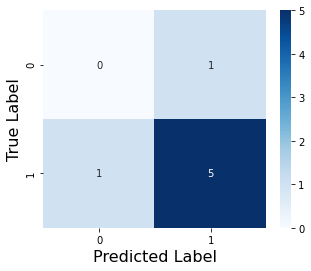

'BernoulliNB' object has no attribute 'feature_importances_'
QH34M4R9
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.114723
		Best Score:	0.8333333333333334
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.083835
		Best Score:	0.8333333333333334
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064379
		Best Score:	0.7666666666666667
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.329711
		Best Score:	0.8333333333333334
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.833
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 1.0
Eval

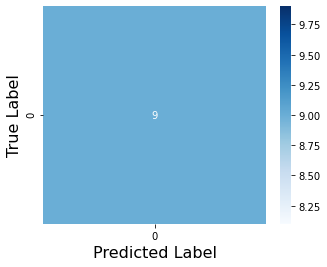

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 1.0
Evaluating...


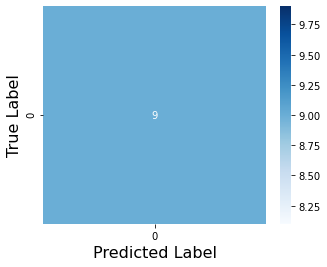

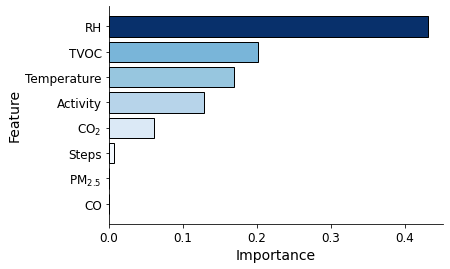

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 1.0
Evaluating...


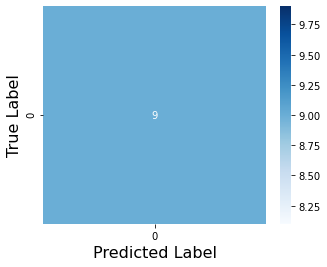

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.333
	Average:	0.692
	Model Score: 1.0
Evaluating...


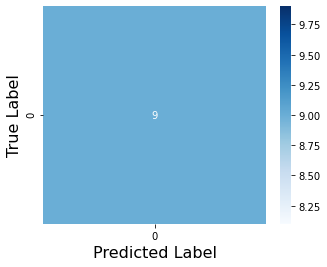

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112179
		Best Score:	0.9
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.551291
		Best Score:	0.9
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065138
		Best Score:	0.9
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.350648
		Best Score:	0.9
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.9
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		1.0
	Average:	0.825
	Model Score: 0.79
Evaluating...


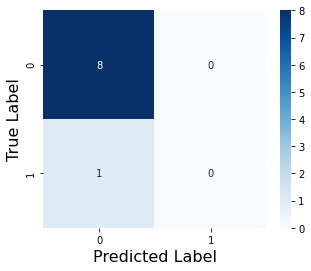

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		1.0
	Average:	0.825
	Model Score: 0.79
Evaluating...


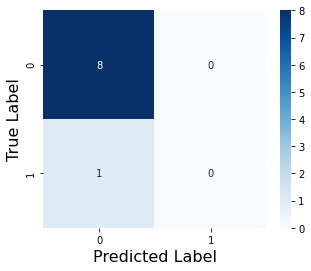

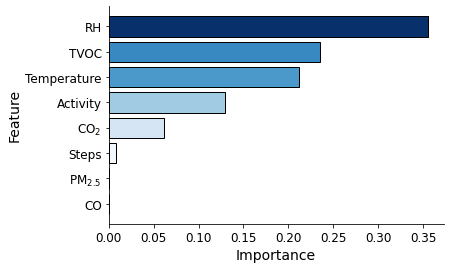

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		1.0
	Average:	0.825
	Model Score: 0.79
Evaluating...


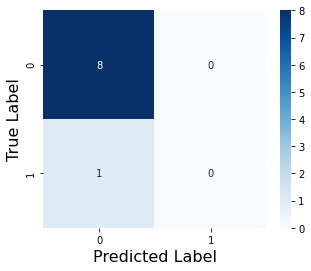

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		1.0
	Average:	0.825
	Model Score: 0.79
Evaluating...


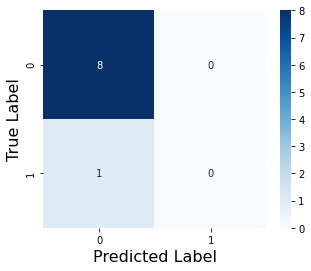

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121429
		Best Score:	0.8333333333333334
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.748497
		Best Score:	0.8333333333333334
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.078781
		Best Score:	0.8333333333333333
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.356181
		Best Score:	0.8333333333333334
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.833
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 0.605
Ev

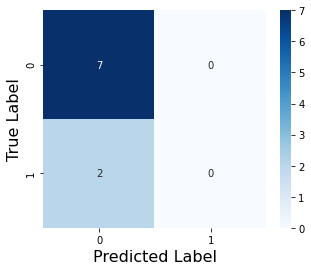

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 0.605
Evaluating...


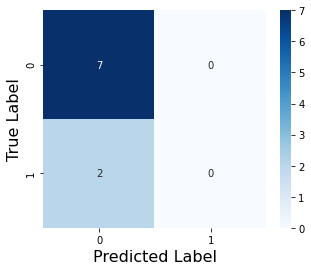

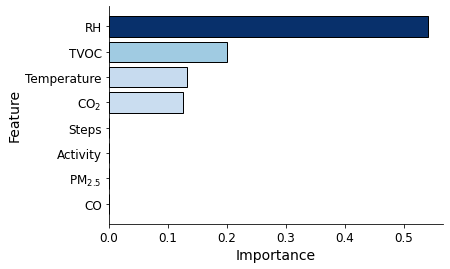

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		0.444
	Average:	0.714
	Model Score: 0.605
Evaluating...


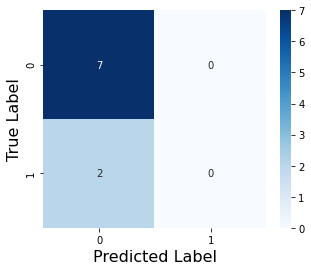

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		1.0
		1.0
	Average:	0.825
	Model Score: 0.605
Evaluating...


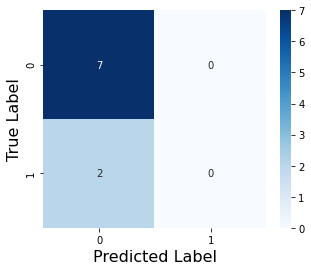

'BernoulliNB' object has no attribute 'feature_importances_'
Only 1 unique value for restful
LKKJDDAM
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.123738
		Best Score:	0.5666666666666667
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.968718
		Best Score:	0.7833333333333333
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063630
		Best Score:	0.5666666666666667
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.326325
		Best Score:	0.6333333333333333
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.783
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.833
	

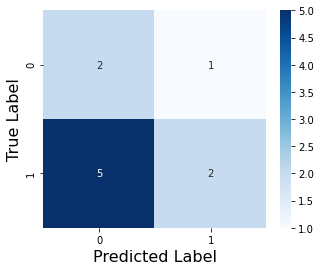

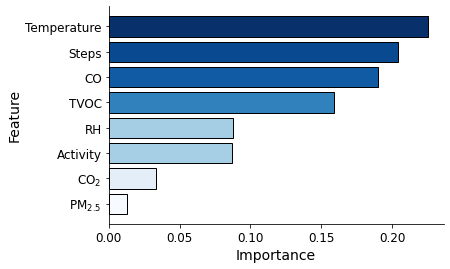

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.833
		0.5
		0.5
		0.833
		1.0
	Average:	0.733
	Model Score: 0.552
Evaluating...


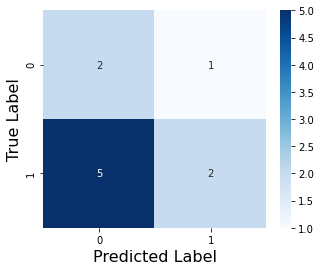

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.5
		0.5
		0.444
		0.444
	Average:	0.478
	Model Score: 0.48
Evaluating...


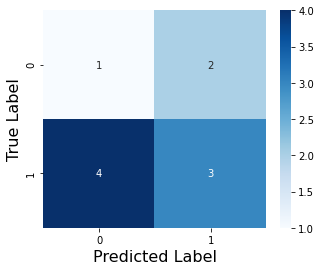

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.5
		0.5
		0.833
		0.444
	Average:	0.556
	Model Score: 0.48
Evaluating...


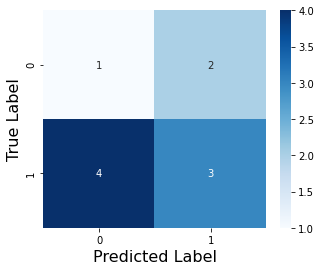

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.114229
		Best Score:	0.4833333333333334
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.396728
		Best Score:	0.6166666666666666
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064076
		Best Score:	0.4333333333333333
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.334500
		Best Score:	0.6
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.617
		Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.5
		0.25
		0.444
		0.444
	Average:	0.44
	Model Score: 0.1

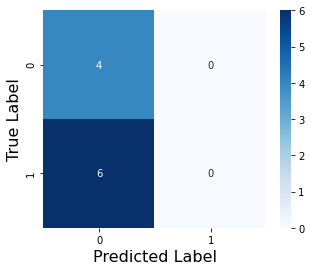

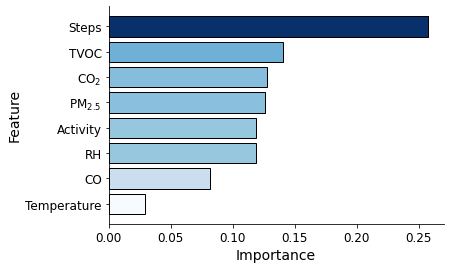

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.25
		0.444
		0.333
	Average:	0.431
	Model Score: 0.45
Evaluating...


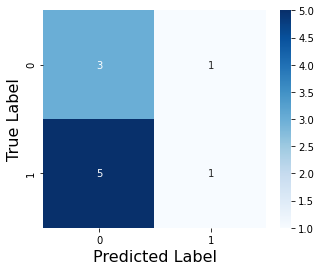

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.5
		0.25
		0.333
		0.333
	Average:	0.396
	Model Score: 0.16
Evaluating...


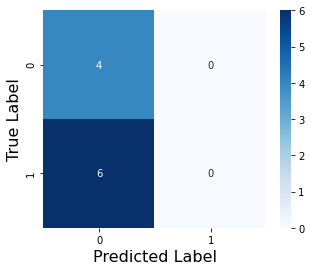

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.5
		0.5
		0.333
		0.333
	Average:	0.433
	Model Score: 0.65
Evaluating...


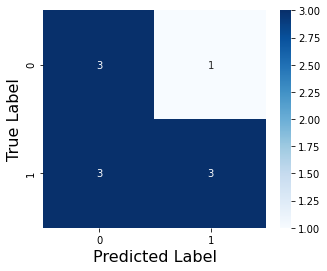

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117900
		Best Score:	0.7166666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.052593
		Best Score:	0.7166666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.086716
		Best Score:	0.39999999999999997
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.361877
		Best Score:	0.7166666666666666
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.717
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.444
		0.444
	Average:	0.515
	Model Score: 0.49
Evalua

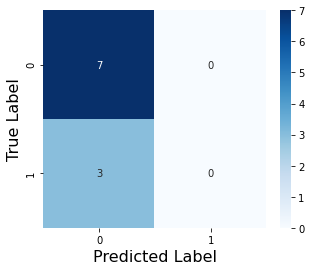

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.444
		0.444
	Average:	0.515
	Model Score: 0.49
Evaluating...


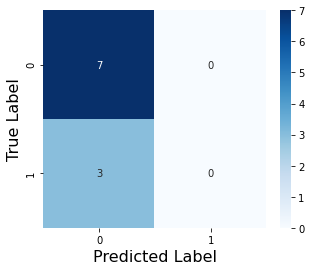

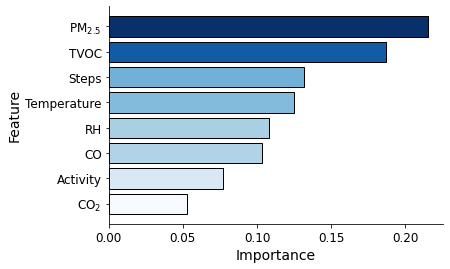

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.444
		0.444
	Average:	0.515
	Model Score: 0.49
Evaluating...


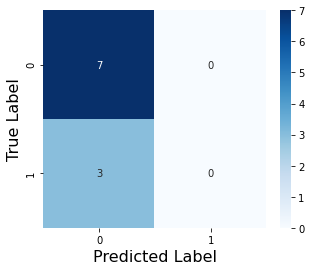

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.375
		0.5
		0.375
		0.444
		0.333
	Average:	0.406
	Model Score: 0.467
Evaluating...


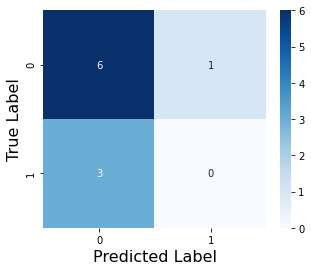

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113575
		Best Score:	0.7333333333333333
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.396770
		Best Score:	0.8333333333333333
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.076614
		Best Score:	0.7833333333333333
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.366602
		Best Score:	0.7833333333333333
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.833
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.5
		1.0
		1.0
		0.833
		1.0
	Average:	0.867

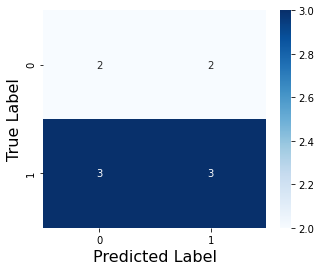

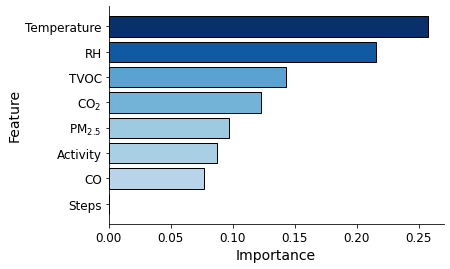

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.5
		1.0
		0.875
		0.833
		1.0
	Average:	0.842
	Model Score: 0.52
Evaluating...


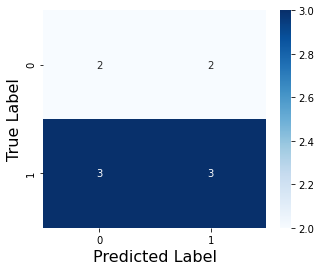

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.5
		1.0
		0.875
		0.833
		1.0
	Average:	0.842
	Model Score: 0.52
Evaluating...


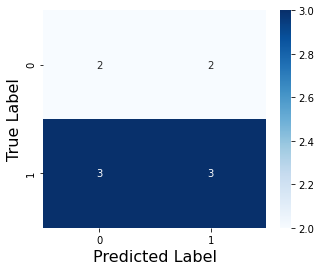

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.562
		0.875
		1.0
		0.444
	Average:	0.676
	Model Score: 0.6
Evaluating...


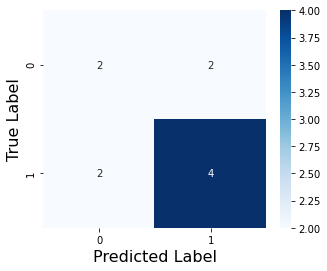

'LogisticRegression' object has no attribute 'feature_importances_'
AWA8UCES
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113512
		Best Score:	0.8666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:29.953108
		Best Score:	0.8666666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.129802
		Best Score:	0.8666666666666666
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.453459
		Best Score:	0.8666666666666666
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.867
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.3

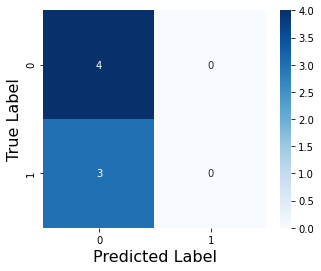

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.327
Evaluating...


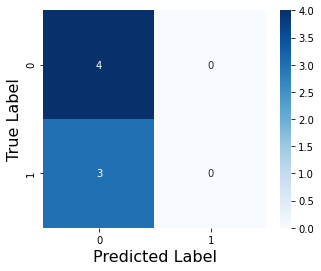

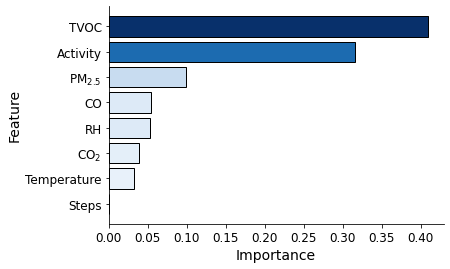

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.327
Evaluating...


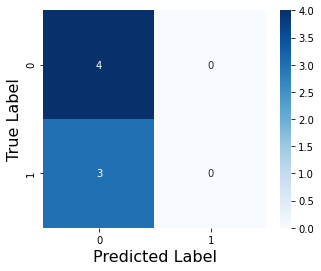

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.327
Evaluating...


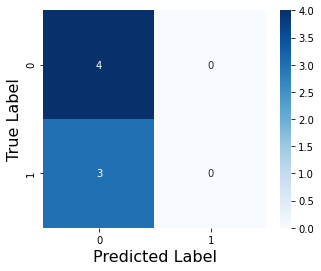

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.109722
		Best Score:	0.8666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.593120
		Best Score:	0.8666666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068143
		Best Score:	0.8666666666666666
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.394681
		Best Score:	0.8666666666666666
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.867
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.51
Evalu

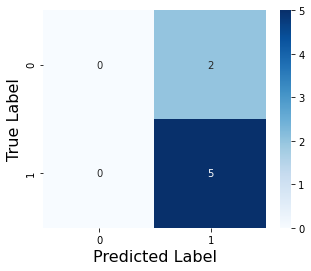

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.476
Evaluating...


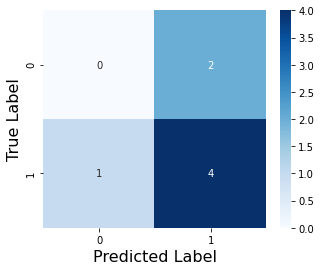

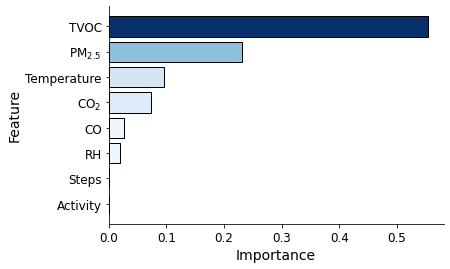

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.51
Evaluating...


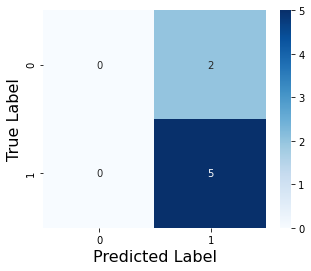

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.444
		0.444
		1.0
		1.0
	Average:	0.778
	Model Score: 0.51
Evaluating...


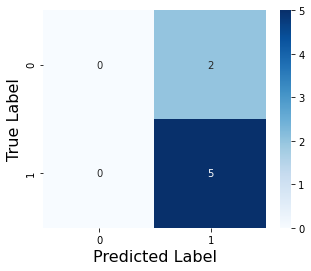

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.182633
		Best Score:	0.8
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.305104
		Best Score:	0.8666666666666666
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.103880
		Best Score:	0.8
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.364367
		Best Score:	0.7333333333333333
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.867
		Params:	{'max_depth': 3, 'mi

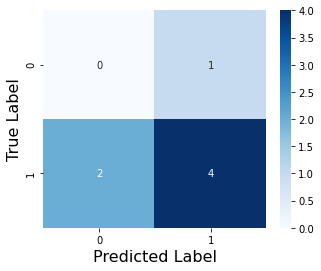

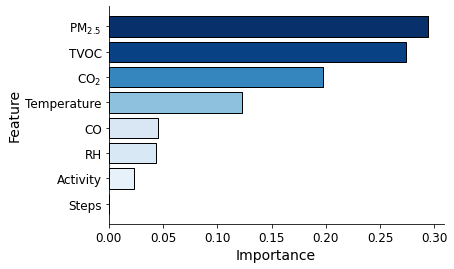

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		1.0
		1.0
	Average:	0.667
	Model Score: 0.686
Evaluating...


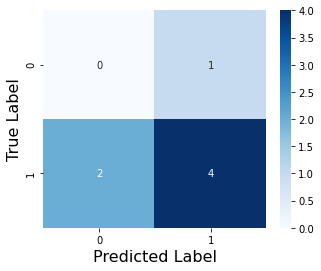

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		1.0
		1.0
	Average:	0.667
	Model Score: 0.686
Evaluating...


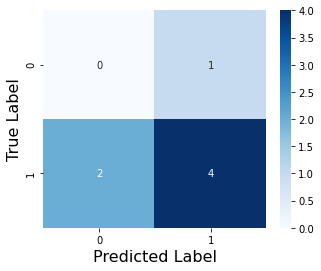

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		1.0
		1.0
		1.0
		0.25
	Average:	0.739
	Model Score: 0.643
Evaluating...


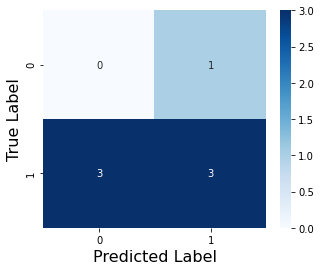

'KNeighborsClassifier' object has no attribute 'feature_importances_'
TMEXEJ5V
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117635
		Best Score:	0.6666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.868908
		Best Score:	0.6666666666666666
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.070749
		Best Score:	0.6666666666666666
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.370453
		Best Score:	0.7333333333333333
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.733
		Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.111
		0.833
		0.444
		1.0
		1.0
	Average:	0.678
	Model Sc

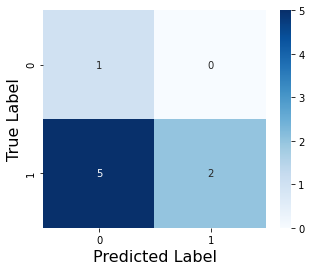

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.111
		0.833
		0.444
		0.833
		1.0
	Average:	0.644
	Model Score: 0.906
Evaluating...


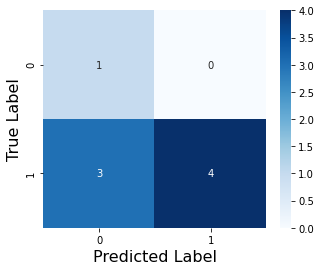

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.111
		0.833
		0.444
		0.833
		1.0
	Average:	0.644
	Model Score: 0.896
Evaluating...


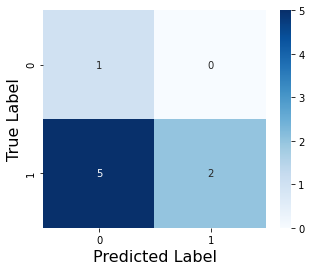

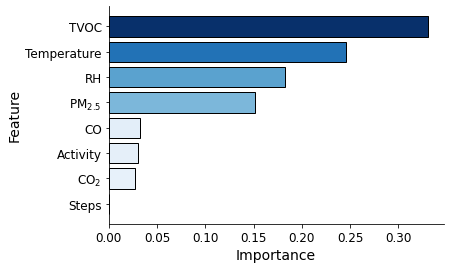

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.111
		0.833
		0.444
		0.833
		1.0
	Average:	0.644
	Model Score: 0.893
Evaluating...


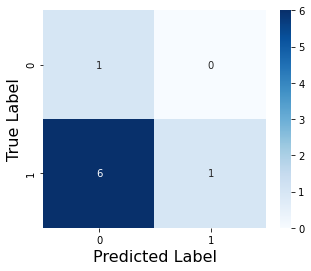

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.137741
		Best Score:	nan
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.667885
		Best Score:	0.9333333333333332
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065620
		Best Score:	0.9333333333333332
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.348814
		Best Score:	0.9333333333333332
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.933
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		1.0
		0.444
		1.0
	Average:	0.889
	Model Score: 0.562
E

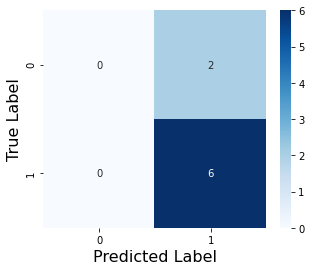

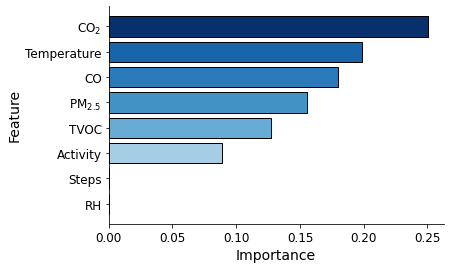

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		1.0
		0.444
		1.0
	Average:	0.889
	Model Score: 0.562
Evaluating...


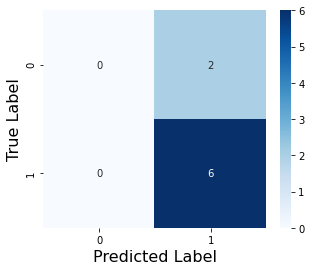

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		1.0
		0.444
		1.0
	Average:	0.889
	Model Score: 0.562
Evaluating...


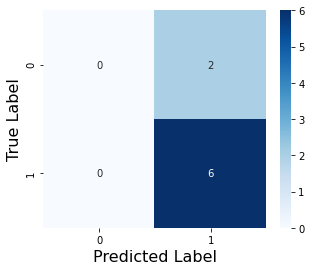

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		1.0
		nan
		1.0
	Average:	nan
	Model Score: 0.562
Evaluating...


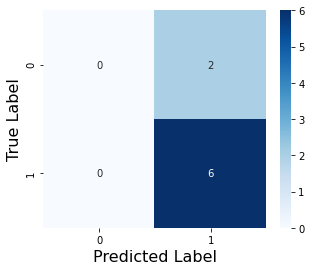

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.116756
		Best Score:	0.6666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.041950
		Best Score:	0.6666666666666667
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067022
		Best Score:	0.6
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.340770
		Best Score:	0.7333333333333333
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.733
		Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.444
		0.444
		0.444
		1.0
	Average:	0.556
	Model Score: 0.729
Evaluating...

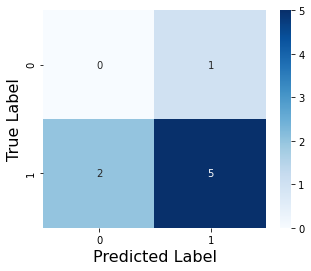

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.333
		1.0
		0.111
		1.0
	Average:	0.578
	Model Score: 0.7
Evaluating...


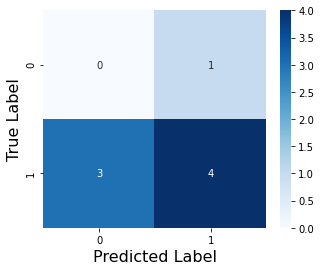

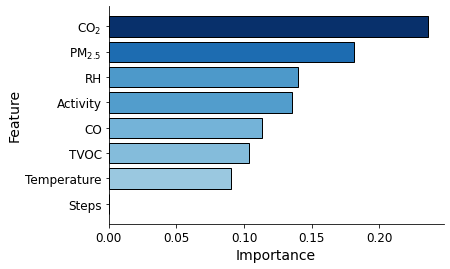

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.333
		0.444
		0.833
		1.0
	Average:	0.611
	Model Score: 0.7
Evaluating...


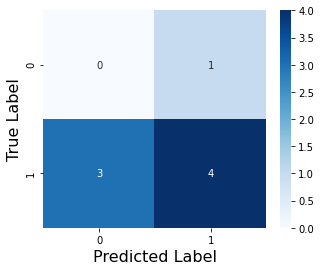

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.333
		0.444
		0.111
		1.0
	Average:	0.467
	Model Score: 0.896
Evaluating...


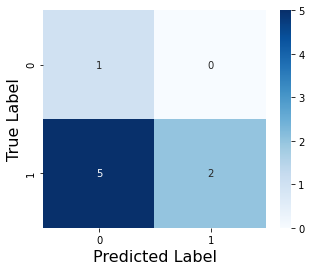

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
TLMLQ19S
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.178766
		Best Score:	0.71
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.380000
		Best Score:	0.71
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068549
		Best Score:	0.55
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.362055
		Best Score:	0.6300000000000001
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.71
		Params:	{'fit_intercept': True, 'so

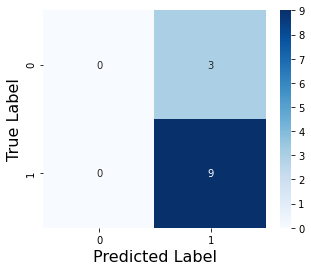

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.36
		0.64
		0.64
		0.562
	Average:	0.512
	Model Score: 0.525
Evaluating...


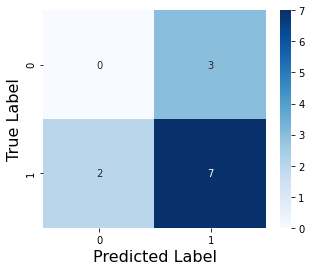

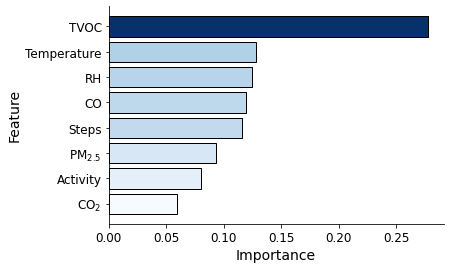

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.36
		0.6
		0.64
		0.562
	Average:	0.492
	Model Score: 0.625
Evaluating...


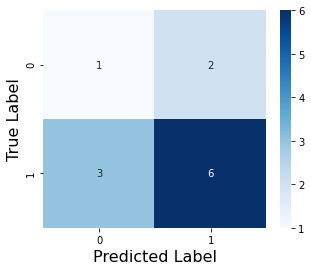

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.3
		0.64
		0.533
		0.562
	Average:	0.467
	Model Score: 0.5
Evaluating...


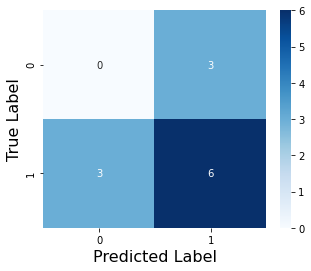

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.132418
		Best Score:	0.43
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.080582
		Best Score:	0.6
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067257
		Best Score:	0.48
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.344960
		Best Score:	0.6
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.6
		Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.36
		0.36
		0.433
		1.0
	Average:	0.491
	Model Score: 0.611
Evaluating...


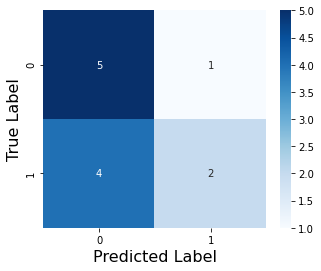

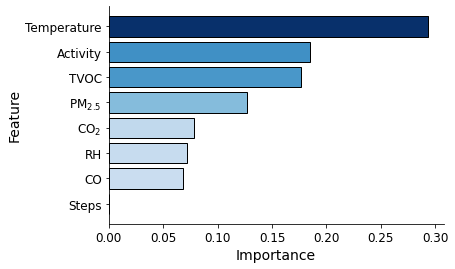

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.36
		0.6
		0.2
		1.0
	Average:	0.552
	Model Score: 0.389
Evaluating...


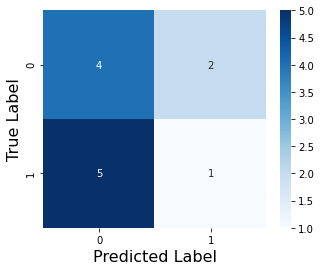

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.36
		0.2
		0.2
		1.0
	Average:	0.412
	Model Score: 0.414
Evaluating...


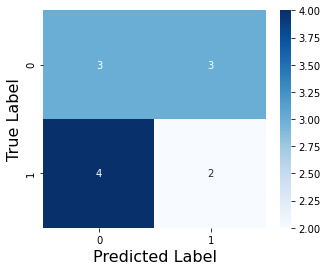

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.36
		0.2
		0.2
		0.562
	Average:	0.324
	Model Score: 0.227
Evaluating...


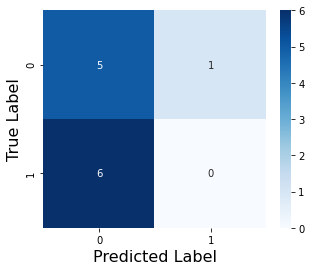

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.158396
		Best Score:	0.7500000000000001
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.972060
		Best Score:	0.7500000000000001
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066711
		Best Score:	0.5900000000000001
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.343570
		Best Score:	0.7500000000000001
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.75
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		0.64
		0.36
		0.562
	Average:	0.568
	Model Score: 0.444
Evalu

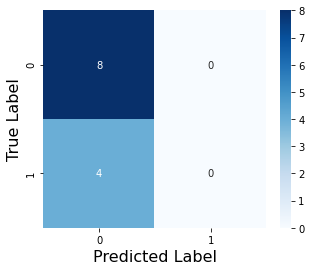

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		0.64
		0.36
		0.562
	Average:	0.568
	Model Score: 0.444
Evaluating...


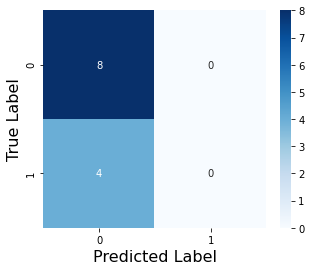

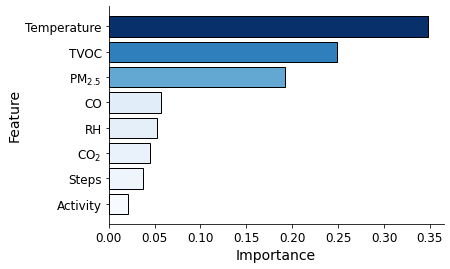

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		0.64
		0.36
		0.562
	Average:	0.568
	Model Score: 0.444
Evaluating...


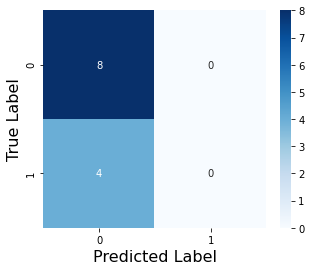

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.533
		0.64
		0.867
		0.3
		0.562
	Average:	0.58
	Model Score: 0.633
Evaluating...


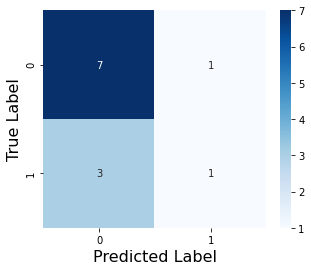

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.136285
		Best Score:	0.8800000000000001
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.801462
		Best Score:	0.8800000000000001
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065324
		Best Score:	0.8800000000000001
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.415528
		Best Score:	0.8800000000000001
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.88
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.64
		0.64
		0.64
		1.0
	Average:	0.784
	Model Score: 0.84
Evaluating..

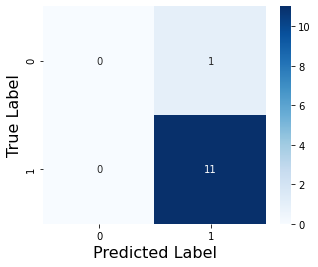

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.64
		0.64
		0.64
		1.0
	Average:	0.784
	Model Score: 0.84
Evaluating...


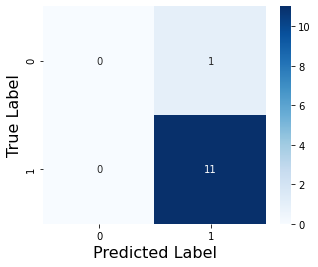

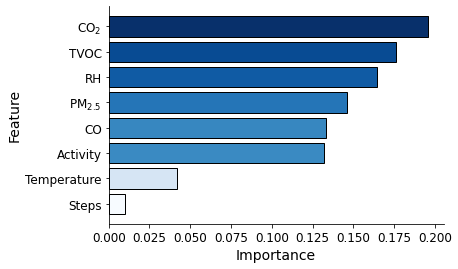

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.64
		0.64
		0.64
		1.0
	Average:	0.784
	Model Score: 0.833
Evaluating...


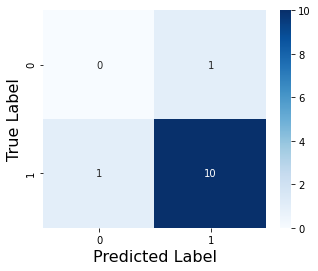

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.64
		0.64
		0.64
		1.0
	Average:	0.784
	Model Score: 0.84
Evaluating...


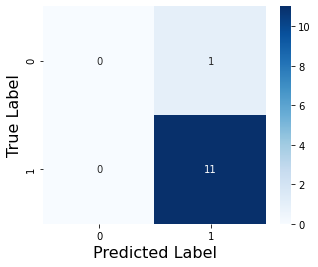

'KNeighborsClassifier' object has no attribute 'feature_importances_'


In [50]:
ind_pred = ieq_and_sq_prediction()
ind_res = {"beiwe":[],"n":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for dataset, target_set, targets in zip([ieq_activity_and_fb_gt30,ieq_activity_and_sr_gt20],[fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for pt in dataset["beiwe"].unique():
        print(pt.upper())
        fts = dataset[dataset["beiwe"] == pt]
        tgts = target_set[target_set["beiwe"] == pt]
        for target in targets:
            if len(tgts[f"{target}_binary"].unique()) > 1:
                try:
                    ind_pred.run(fts,tgts,target)
                    # adding results
                    ind_res["beiwe"].append(pt)
                    ind_res["n"].append(len(ind_pred.features))
                    ind_res["target"].append(target)
                    ind_res["best_performing_model"].append(ind_pred.results.iloc[0,0])
                    ind_res["model_score"].append(ind_pred.results.iloc[0,1])
                    bs = sum(ind_pred.targets.values)/len(ind_pred.targets)
                    ind_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
                    try:
                        ind_res["sensitive_parameter1"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                        ind_res["sensitive_parameter2"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
                    except KeyError:
                        ind_res["sensitive_parameter1"].append(np.nan)
                        ind_res["sensitive_parameter2"].append(np.nan)
                except ValueError as e:
                    print(e)
            else:
                print("Only 1 unique value for", target.replace("_"," "))

In [51]:
ind_res_df = pd.DataFrame(ind_res)
ind_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-individual-results.csv")

### Predicting other Participant Sleep Quality
We can also create a scheme where we predict the sleep quality of a few participants by training on a larger subset of the participants. 

We have two tools for model selection:
1. GroupKFold: Here we specify a certain number of splits to be made and a leave a subset of participants out of the training set to use as the test set. 
2. LeaveOneGroupOut: This cross-validation goes as far as to include all but one participant in the training set. Then we try to predict the sleep quality of that left-out individual.

Getting Features and Target (se)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.131107
		Best Score:	0.8136705399863295
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.815787
		Best Score:	0.8136705399863295
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063647
		Best Score:	0.8136705399863295
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.404003
		Best Score:	0.7664388243335611
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.814
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


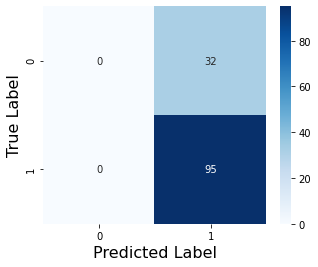

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


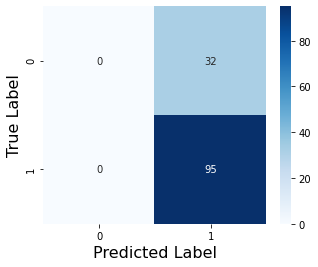

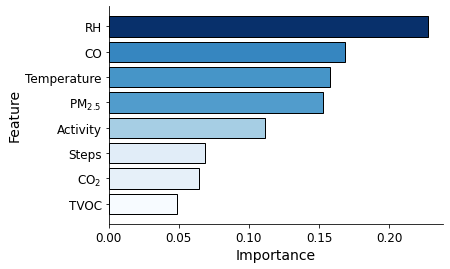

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


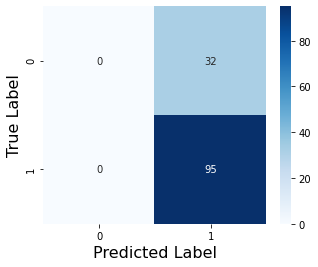

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.659
		0.648
		0.732
		0.715
	Average:	0.691
	Model Score: 0.6
Evaluating...


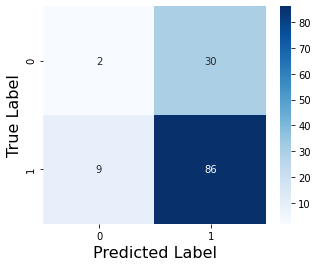

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.156017
		Best Score:	0.7979152426520848
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.587139
		Best Score:	0.7979152426520848
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065282
		Best Score:	0.7742652084757349
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.400884
		Best Score:	0.740088858509911
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.798
		Params:	{'fit_intercept': True, 'solver': 'liblinear'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.738
		0.644
		0.644
		0.644
		0.623
	Average:	0.659
	Model Score: 0.632
Evaluating...


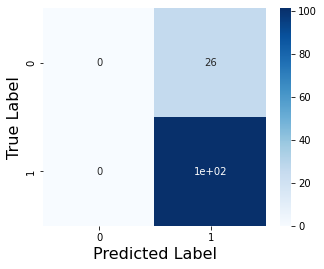

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.628
		0.644
		0.644
		0.644
		0.623
	Average:	0.637
	Model Score: 0.632
Evaluating...


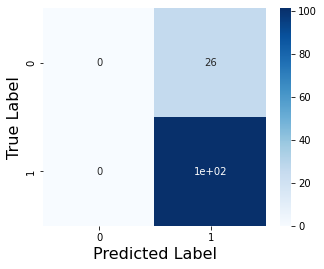

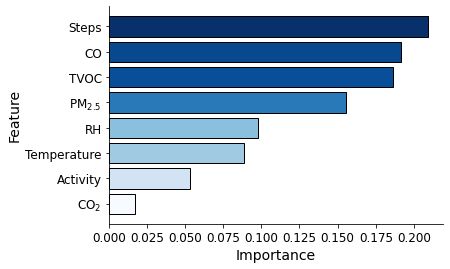

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.701
		0.64
		0.64
		0.644
		0.655
	Average:	0.656
	Model Score: 0.632
Evaluating...


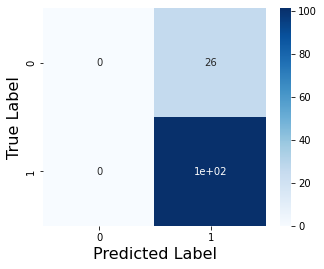

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.721
		0.696
		0.632
		0.791
		0.642
	Average:	0.696
	Model Score: 0.677
Evaluating...


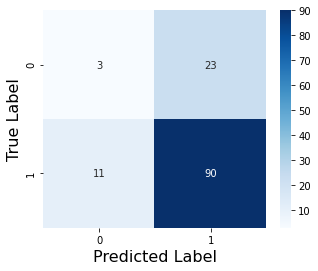

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.138337
		Best Score:	0.8184210526315789
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.579007
		Best Score:	0.8184210526315789
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064482
		Best Score:	0.8184210526315789
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.406911
		Best Score:	0.7947368421052632
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.818
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


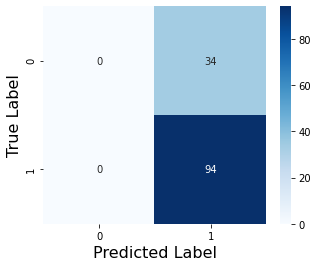

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


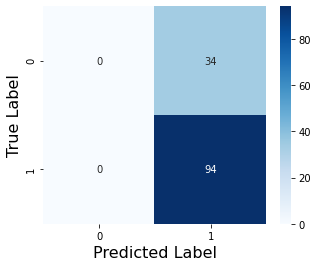

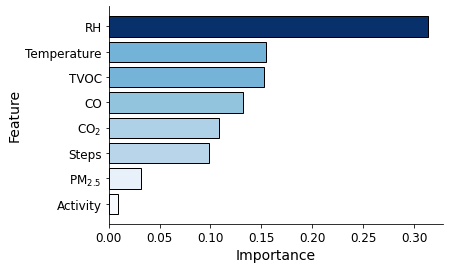

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


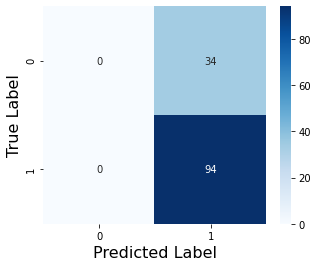

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.715
		0.695
		0.715
		0.666
		0.859
	Average:	0.73
	Model Score: 0.535
Evaluating...


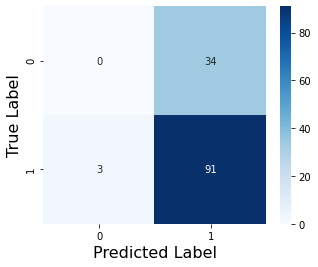

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127423
		Best Score:	0.7539986329460013
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.476628
		Best Score:	0.7591934381408065
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064567
		Best Score:	0.7199248120300752
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.400852
		Best Score:	0.6987354750512645
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.759
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.567
		0.567
		0.582
		0.582
		0.582
	Average:	0.576
	Model S

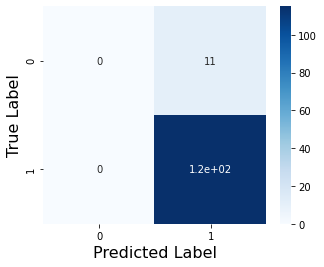

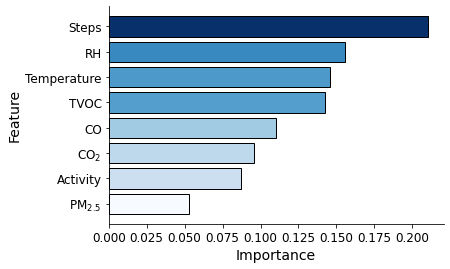

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.629
		0.696
		0.582
		0.582
		0.582
	Average:	0.614
	Model Score: 0.855
Evaluating...


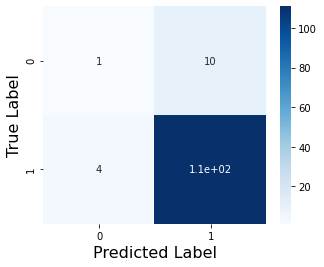

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.62
		0.565
		0.636
		0.58
		0.686
	Average:	0.617
	Model Score: 0.846
Evaluating...


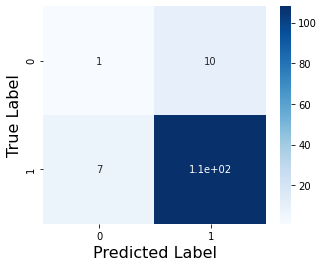

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.674
		0.697
		0.595
		0.617
		0.672
	Average:	0.651
	Model Score: 0.827
Evaluating...


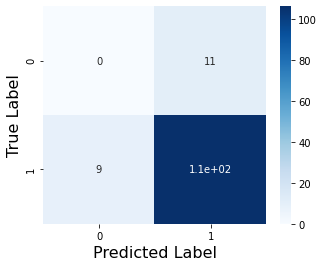

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.130518
		Best Score:	0.5799384825700615
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.507358
		Best Score:	0.6115516062884483
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064269
		Best Score:	0.5483595352016405
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.401151
		Best Score:	0.569583048530417
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.612
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.373
		0.366
		0.366
		0.382


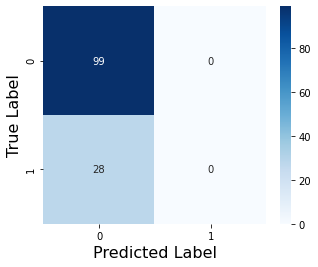

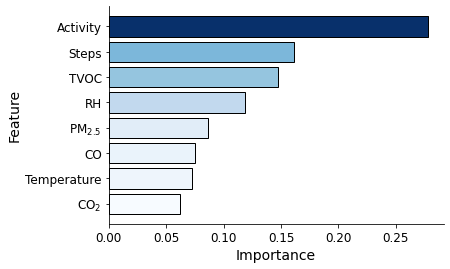

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.615
		0.511
		0.416
		0.546
		0.593
	Average:	0.536
	Model Score: 0.604
Evaluating...


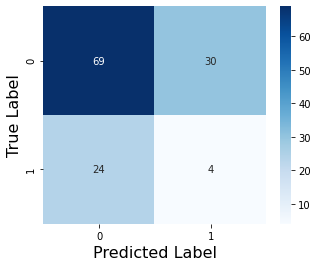

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.46
		0.666
		0.48
		0.469
		0.619
	Average:	0.539
	Model Score: 0.675
Evaluating...


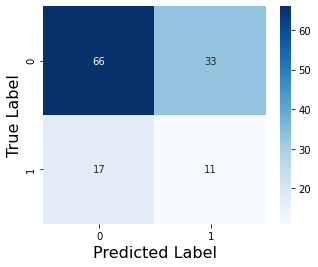

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.615
		0.567
		0.421
		0.507
		0.469
	Average:	0.516
	Model Score: 0.628
Evaluating...


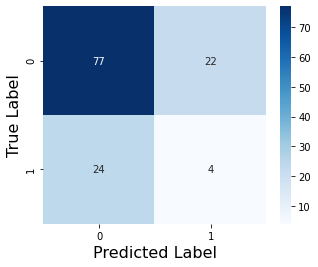

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.125111
		Best Score:	0.6061859193438142
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.430023
		Best Score:	0.6482911825017089
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065112
		Best Score:	0.6272385509227615
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.401357
		Best Score:	0.5485304169514695
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.648
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.416
		0.416
		0.416
		0.433
	Average:	0.42
	Model Score: 0.448
E

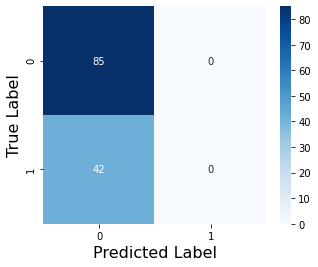

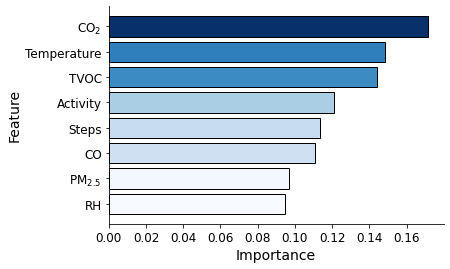

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.416
		0.776
		0.416
		0.403
	Average:	0.486
	Model Score: 0.448
Evaluating...


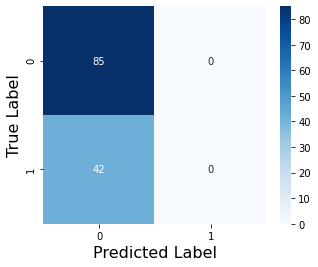

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.504
		0.776
		0.4
		0.41
	Average:	0.502
	Model Score: 0.448
Evaluating...


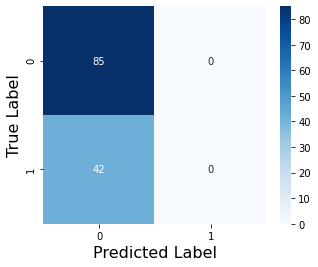

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.502
		0.611
		0.465
		0.482
		0.477
	Average:	0.507
	Model Score: 0.603
Evaluating...


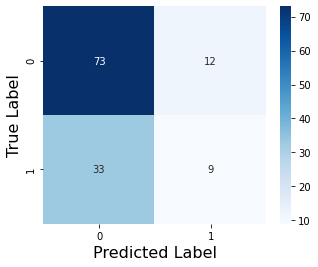

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.120393
		Best Score:	0.6105263157894738
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.464784
		Best Score:	0.6578947368421053
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064818
		Best Score:	0.6157894736842107
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.400454
		Best Score:	0.5947368421052632
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.658
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.433
		0.433
		0.433
		0.433
	Average:	0.433
	Model 

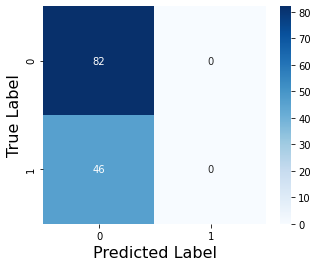

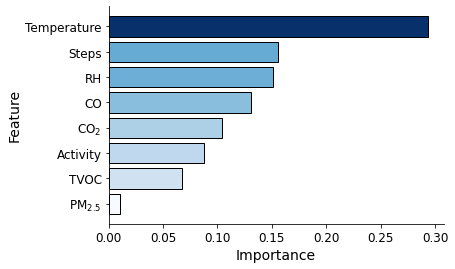

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.43
		0.433
		0.459
		0.436
	Average:	0.438
	Model Score: 0.41
Evaluating...


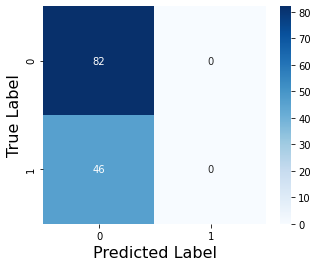

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.43
		0.433
		0.572
		0.46
		0.41
	Average:	0.461
	Model Score: 0.773
Evaluating...


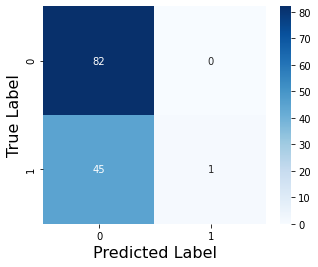

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.511
		0.599
		0.526
		0.476
		0.65
	Average:	0.552
	Model Score: 0.55
Evaluating...


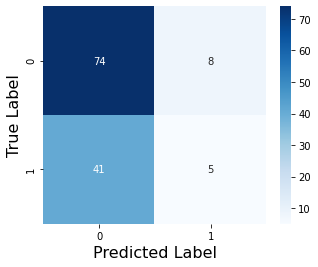

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.132513
		Best Score:	0.667805878332194
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.584318
		Best Score:	0.7015721120984278
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064815
		Best Score:	0.6700273410799726
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.406654
		Best Score:	0.6233082706766917
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.702
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.649
		0.701
		0.802
		0.484
		0.486
	Average:	0.624
	Model Score

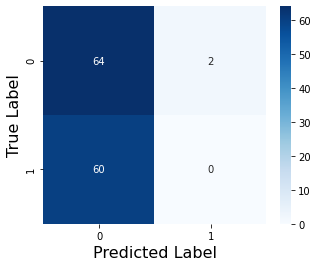

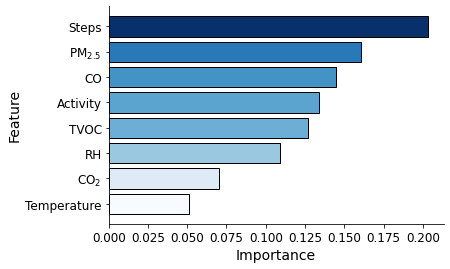

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.474
		0.653
		0.536
		0.486
		0.486
	Average:	0.527
	Model Score: 0.27
Evaluating...


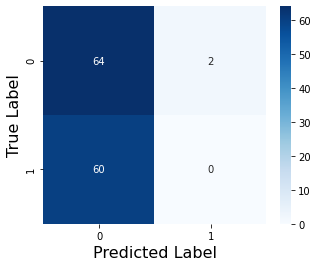

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.581
		0.551
		0.641
		0.795
		0.486
	Average:	0.611
	Model Score: 0.264
Evaluating...


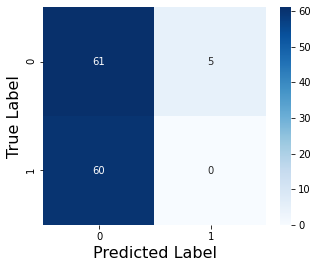

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.611
		0.497
		0.57
		0.529
		0.678
	Average:	0.577
	Model Score: 0.5
Evaluating...


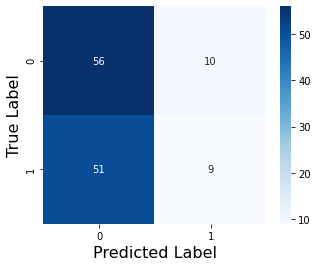

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127400
		Best Score:	0.48294600136705396
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.458855
		Best Score:	0.4383116883116883
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064670
		Best Score:	0.409501025290499
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.415701
		Best Score:	0.4645933014354068
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.483
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.481
		0.513
		0.473
		0.429
		0.511
	Average

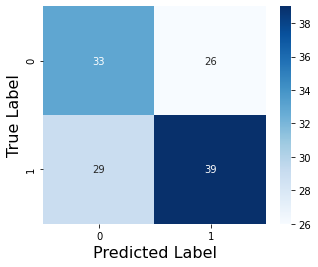

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.455
		0.394
		0.514
		0.404
		0.56
	Average:	0.466
	Model Score: 0.538
Evaluating...


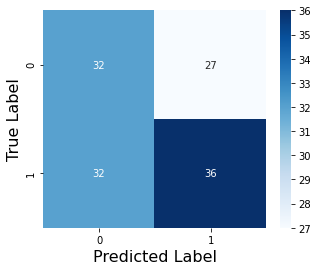

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.441
		0.379
		0.526
		0.329
		0.511
	Average:	0.438
	Model Score: 0.539
Evaluating...


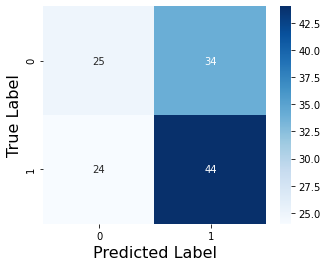

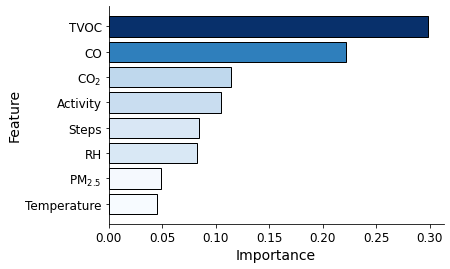

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.39
		0.434
		0.457
		0.284
		0.475
	Average:	0.408
	Model Score: 0.519
Evaluating...


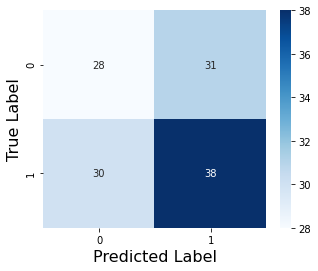

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.135063
		Best Score:	0.46421736158578264
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.533752
		Best Score:	0.4907382091592617
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064607
		Best Score:	0.46971975393028026
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.406350
		Best Score:	0.4828434723171566
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.491
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.515
		0.554
		0.452
		0.363
		0.519
	Average:	0.481
	Model Score: 0.28

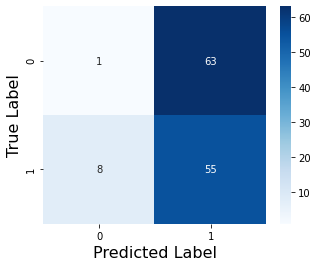

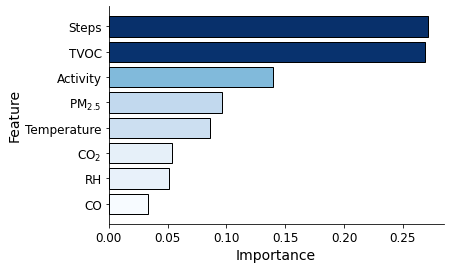

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.534
		0.489
		0.526
		0.444
		0.438
	Average:	0.486
	Model Score: 0.512
Evaluating...


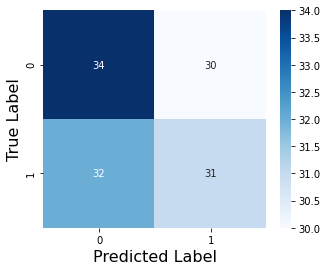

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.506
		0.475
		0.459
		0.47
		0.426
	Average:	0.467
	Model Score: 0.332
Evaluating...


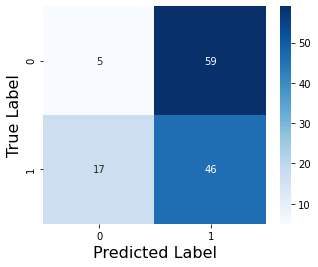

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.621
		0.408
		0.499
		0.344
		0.466
	Average:	0.468
	Model Score: 0.551
Evaluating...


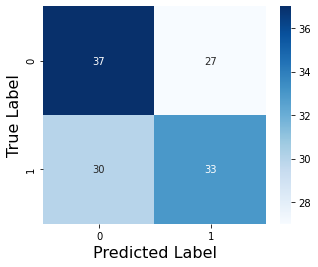

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124361
		Best Score:	0.4947368421052631
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.740901
		Best Score:	0.5105263157894736
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064892
		Best Score:	0.48421052631578954
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.403637
		Best Score:	0.47894736842105257
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.511
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.492
		0.354
		0.523
		0.277
		0.525
	Average:	0.434
	Model Sc

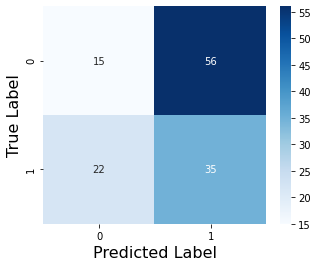

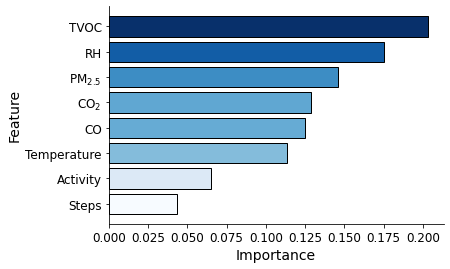

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.554
		0.364
		0.603
		0.41
		0.435
	Average:	0.473
	Model Score: 0.517
Evaluating...


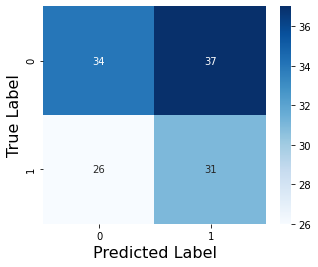

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.479
		0.388
		0.531
		0.398
		0.528
	Average:	0.465
	Model Score: 0.403
Evaluating...


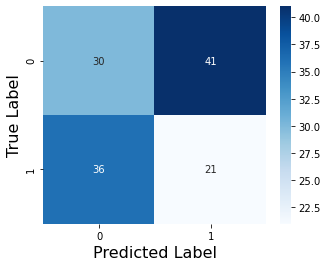

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.423
		0.478
		0.435
		0.51
		0.533
	Average:	0.476
	Model Score: 0.46
Evaluating...


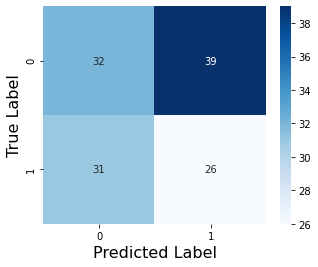

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.128794
		Best Score:	0.5286397812713602
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.518593
		Best Score:	0.4790840738209159
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065212
		Best Score:	0.46329460013670537
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.404524
		Best Score:	0.45044429254955576
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.529
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.582
		0.545
		0.579
		0.448
		0.5
	Average:	0.531
	Model Score: 0.46
Evaluating...


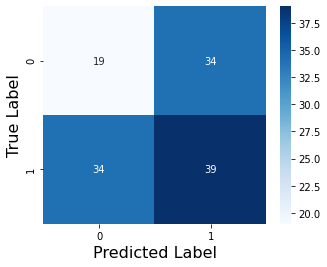

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.547
		0.402
		0.566
		0.382
		0.5
	Average:	0.479
	Model Score: 0.517
Evaluating...


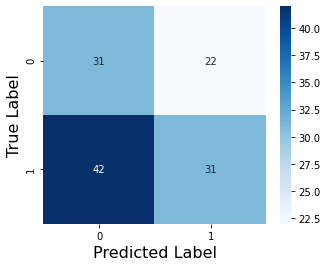

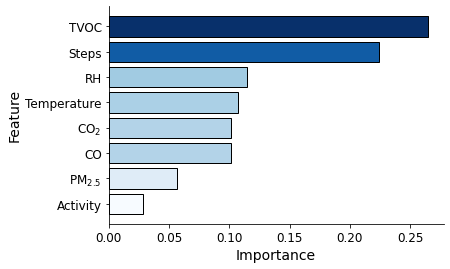

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.536
		0.402
		0.525
		0.36
		0.473
	Average:	0.459
	Model Score: 0.448
Evaluating...


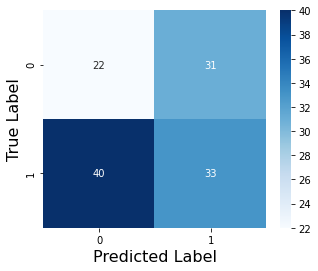

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.49
		0.326
		0.51
		0.356
		0.558
	Average:	0.448
	Model Score: 0.524
Evaluating...


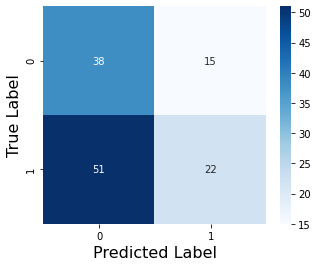

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118599
		Best Score:	0.53526999316473
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.497203
		Best Score:	0.5826384142173615
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064887
		Best Score:	0.4958988380041012
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.402019
		Best Score:	0.5377306903622693
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.583
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.357
		0.366
		0.351


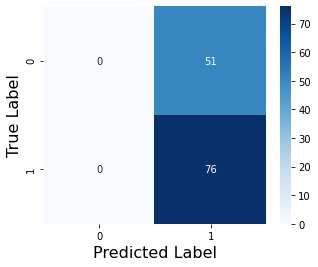

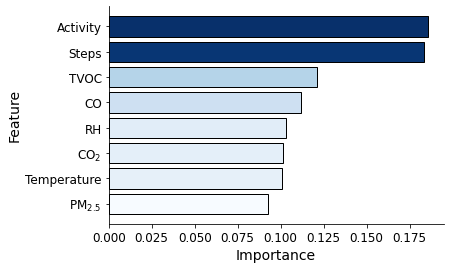

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.422
		0.429
		0.416
		0.67
	Average:	0.518
	Model Score: 0.522
Evaluating...


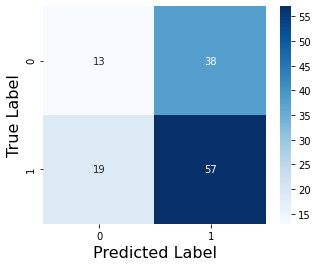

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.563
		0.428
		0.513
		0.451
		0.589
	Average:	0.509
	Model Score: 0.566
Evaluating...


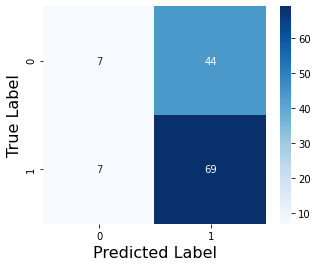

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.54
		0.372
		0.506
		0.382
		0.547
	Average:	0.47
	Model Score: 0.607
Evaluating...


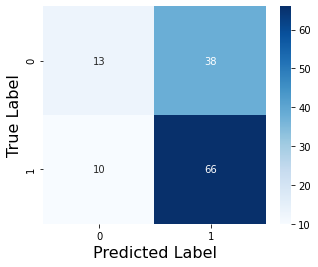

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.130723
		Best Score:	0.6298359535201641
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.503517
		Best Score:	0.6772043745727957
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064524
		Best Score:	0.648257006151743
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.406986
		Best Score:	0.6510252904989746
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.677
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.62
		0.53
		0.679
		0.799
		0.67
	Average:	0.66
	Model Score: 0.591
Evalua

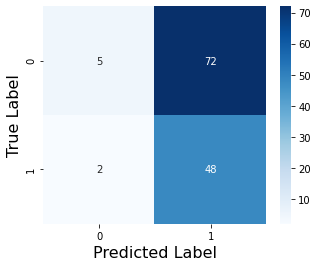

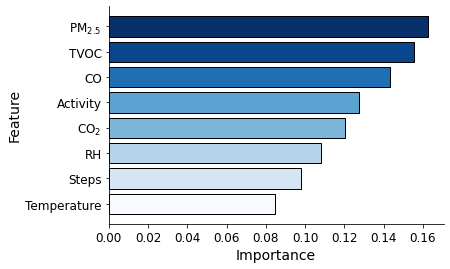

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.588
		0.526
		0.594
		0.646
		0.713
	Average:	0.614
	Model Score: 0.543
Evaluating...


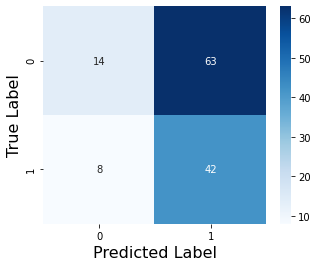

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.439
		0.438
		0.618
		0.43
		0.43
	Average:	0.471
	Model Score: 0.155
Evaluating...


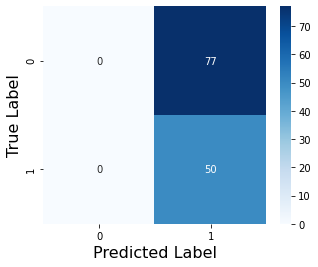

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.439
		0.424
		0.541
		0.43
		0.43
	Average:	0.453
	Model Score: 0.155
Evaluating...


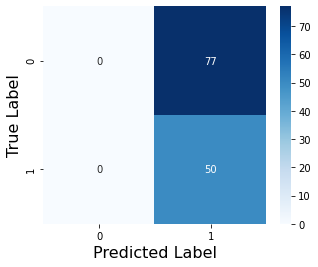

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127441
		Best Score:	0.5605263157894737
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.451849
		Best Score:	0.5842105263157895
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067512
		Best Score:	0.5368421052631579
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.402932
		Best Score:	0.5736842105263158
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.584
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.567
		0.576
		0.463
		0.589
		0.701
	Average:	0.579
	Model Score:

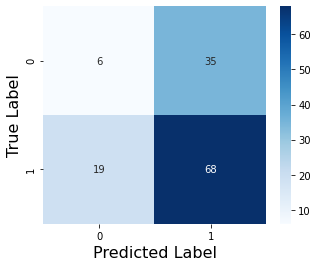

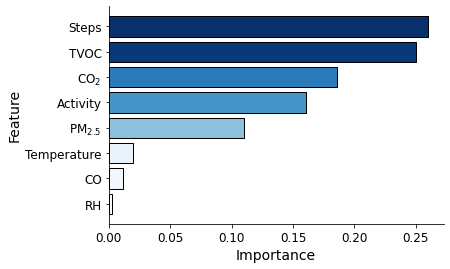

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.536
		0.576
		0.551
		0.707
		0.553
	Average:	0.585
	Model Score: 0.572
Evaluating...


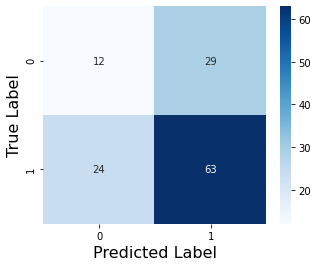

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.511
		0.513
		0.565
		0.583
		0.589
	Average:	0.552
	Model Score: 0.533
Evaluating...


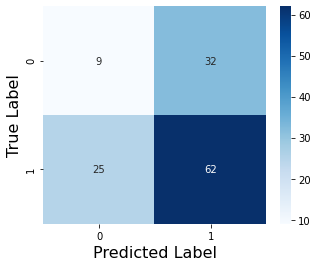

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.494
		0.505
		0.479
		0.553
		0.584
	Average:	0.523
	Model Score: 0.551
Evaluating...


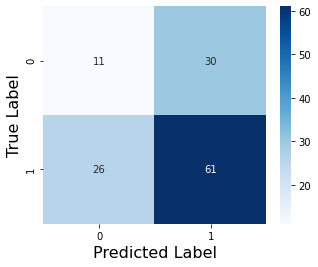

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.123247
		Best Score:	0.531578947368421
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.628202
		Best Score:	0.5445317840054682
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064379
		Best Score:	0.5132262474367738
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.402039
		Best Score:	0.49494190020505807
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.545
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.603
		0.455
		0.374
		0.64
		0.64
	Average:	0.542
	Model Score: 0.686


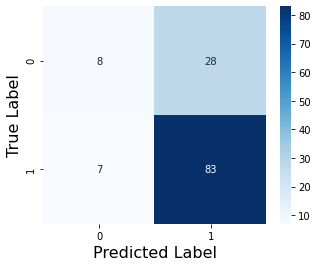

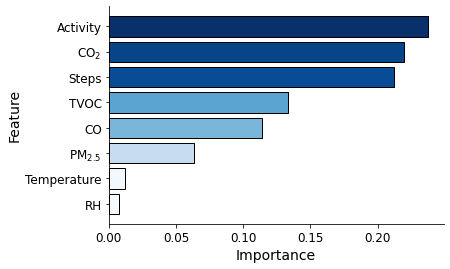

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.521
		0.443
		0.395
		0.589
		0.656
	Average:	0.521
	Model Score: 0.581
Evaluating...


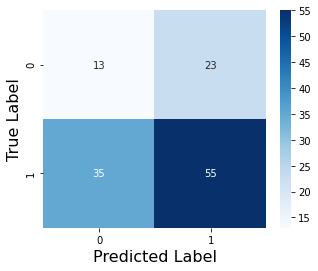

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.573
		0.388
		0.401
		0.572
		0.601
	Average:	0.507
	Model Score: 0.592
Evaluating...


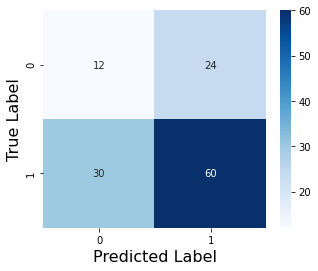

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.577
		0.324
		0.552
		0.485
		0.488
	Average:	0.485
	Model Score: 0.668
Evaluating...


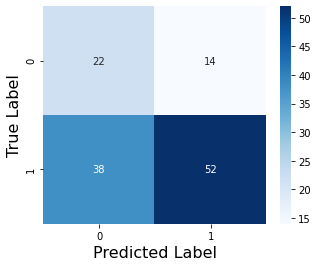

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118385
		Best Score:	0.6219753930280246
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.450933
		Best Score:	0.6482911825017089
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064567
		Best Score:	0.5957621326042378
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.404083
		Best Score:	0.6038277511961723
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.648
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.433
		0.41

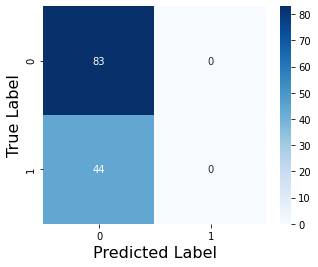

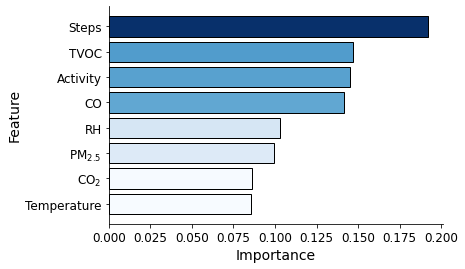

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.433
		0.452
		0.413
		0.413
	Average:	0.426
	Model Score: 0.422
Evaluating...


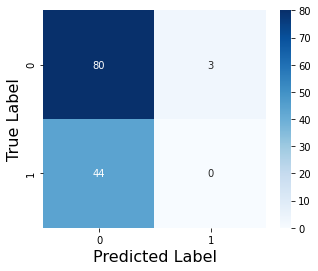

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.525
		0.601
		0.528
		0.579
		0.653
	Average:	0.577
	Model Score: 0.573
Evaluating...


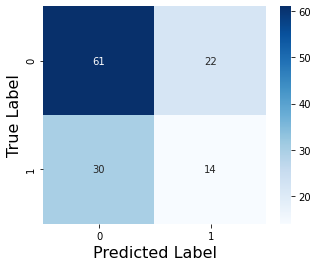

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.518
		0.495
		0.428
		0.416
		0.48
	Average:	0.467
	Model Score: 0.454
Evaluating...


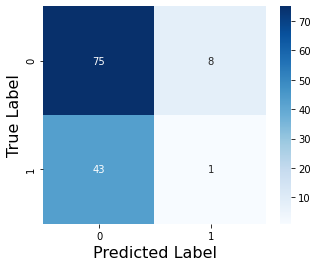

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127226
		Best Score:	0.5904306220095694
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.958952
		Best Score:	0.6141831852358168
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.082794
		Best Score:	0.5694121667805878
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.400107
		Best Score:	0.5642173615857826
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.614
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.373
		0.382
		0.382
		0.382
		0.366
	Average:	0.377
	Model Score: 0.571
E

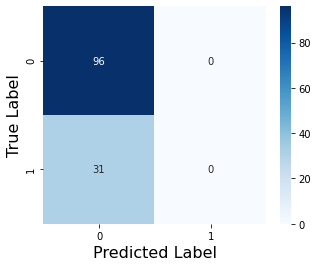

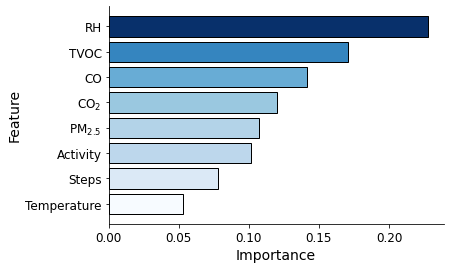

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.772
		0.382
		0.382
		0.421
		0.357
	Average:	0.463
	Model Score: 0.571
Evaluating...


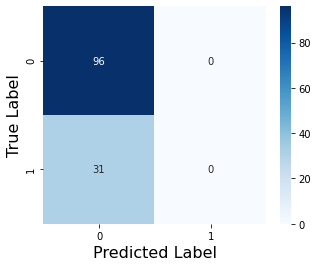

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.767
		0.402
		0.382
		0.373
		0.366
	Average:	0.458
	Model Score: 0.571
Evaluating...


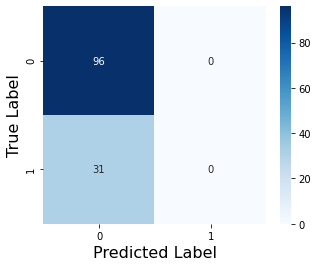

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.605
		0.513
		0.628
		0.467
		0.521
	Average:	0.547
	Model Score: 0.66
Evaluating...


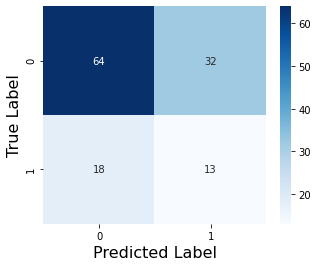

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.115290
		Best Score:	0.6394736842105264
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:26.962275
		Best Score:	0.6605263157894737
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.074567
		Best Score:	0.631578947368421
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.508253
		Best Score:	0.6289473684210527
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.661
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.45
		0.433
		0.433
		0.433
		0.433
	Average:	0.436
	Model Score: 

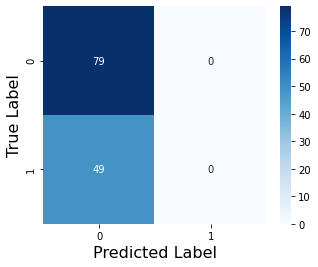

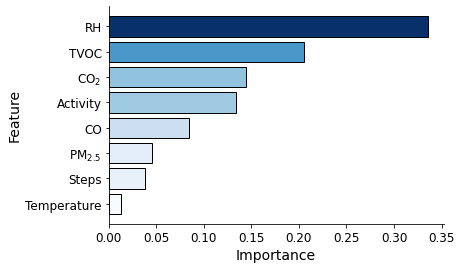

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.618
		0.497
		0.433
		0.43
		0.433
	Average:	0.482
	Model Score: 0.535
Evaluating...


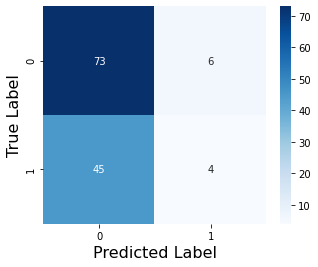

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.785
		0.493
		0.433
		0.607
		0.424
	Average:	0.548
	Model Score: 0.612
Evaluating...


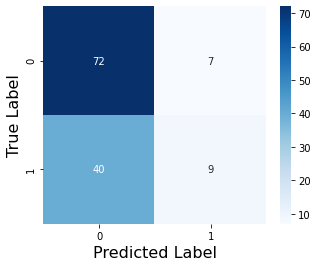

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.606
		0.545
		0.608
		0.697
		0.605
	Average:	0.612
	Model Score: 0.601
Evaluating...


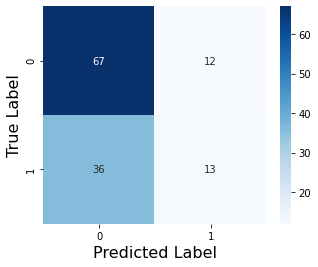

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.125956
		Best Score:	0.6650034176349966
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:17.895040
		Best Score:	0.675393028024607
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066394
		Best Score:	0.6468215994531784
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.401614
		Best Score:	0.6178742310321258
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.675
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.456
		0.456
		0.468
		0.45
		0.45
	Average:	0.456
	Model Scor

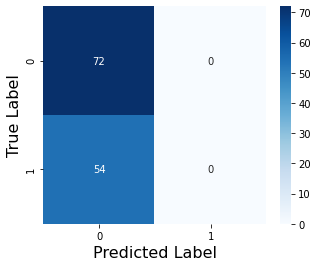

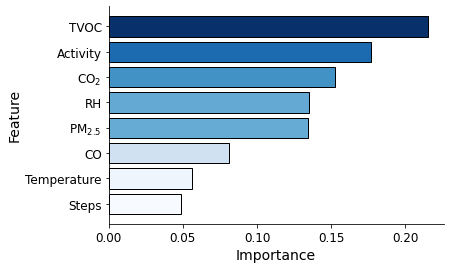

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.622
		0.79
		0.45
		0.447
	Average:	0.551
	Model Score: 0.327
Evaluating...


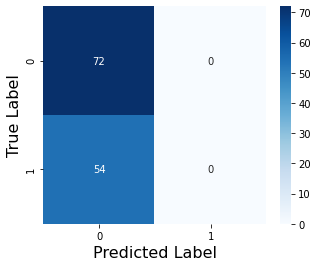

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.518
		0.79
		0.45
		0.447
	Average:	0.541
	Model Score: 0.541
Evaluating...


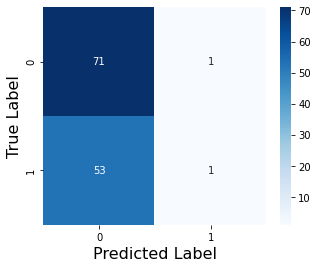

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.515
		0.548
		0.596
		0.582
		0.62
	Average:	0.572
	Model Score: 0.623
Evaluating...


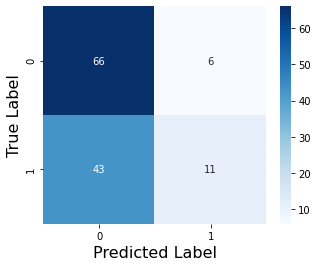

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
SPLIT 1
	Train:	190
	Test:	63

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.147516
		Best Score:	0.7210526315789473
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:17.906796
		Best Score:	0.7157894736842105
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.071487
		Best Score:	0.7263157894736842
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.426352
		Best Score:	0.6631578947368422
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Bernoulli Naive Bayes
		Score:	0.726
		Params:	{'alpha': 0}
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.66
		0.813
		0.74
		0.722
		0.641
	Average:	0.715
	Model Score: 0.534
Evaluatin

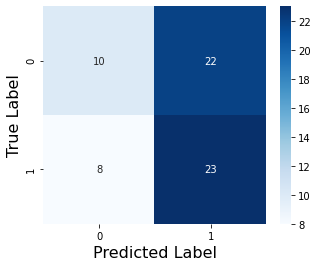

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.688
		0.798
		0.699
		0.65
		0.701
	Average:	0.707
	Model Score: 0.579
Evaluating...


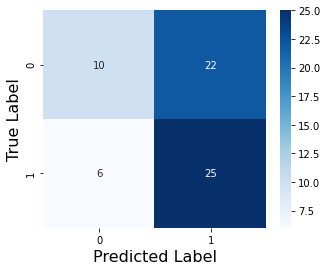

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.798
		0.542
		0.755
		0.679
	Average:	0.692
	Model Score: 0.547
Evaluating...


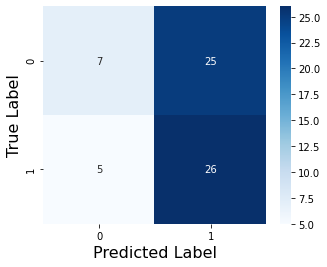

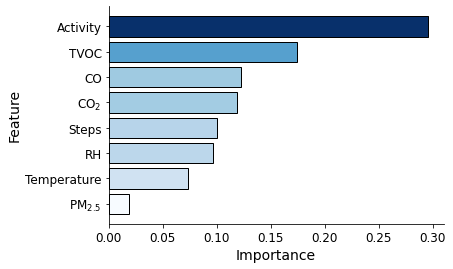

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.614
		0.734
		0.65
		0.671
		0.646
	Average:	0.663
	Model Score: 0.494
Evaluating...


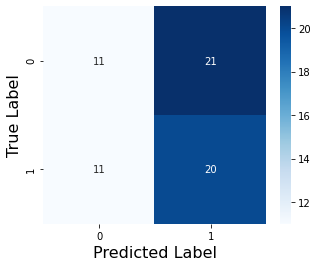

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	193
	Test:	60

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113054
		Best Score:	0.5588394062078272
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.092534
		Best Score:	0.6221322537112012
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066988
		Best Score:	0.5850202429149798
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.358416
		Best Score:	0.5284750337381917
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.622
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.341
		0.624
		0.504
		0.688
		0.648
	Average:	0.561
	Model Score:

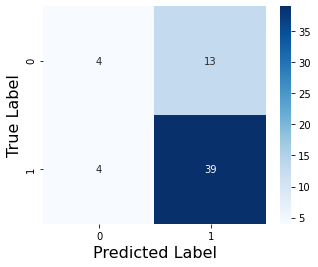

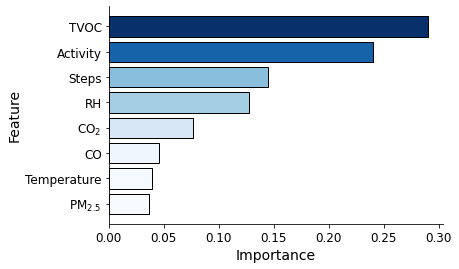

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.624
		0.418
		0.558
		0.537
	Average:	0.566
	Model Score: 0.678
Evaluating...


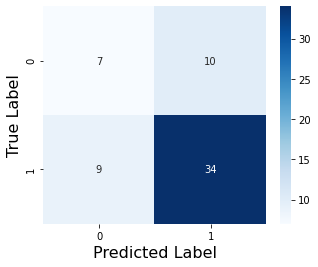

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.649
		0.657
		0.418
		0.453
		0.526
	Average:	0.541
	Model Score: 0.694
Evaluating...


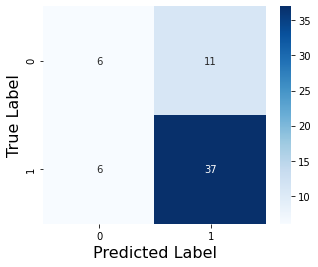

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.39
		0.58
		0.57
		0.506
		0.579
	Average:	0.525
	Model Score: 0.682
Evaluating...


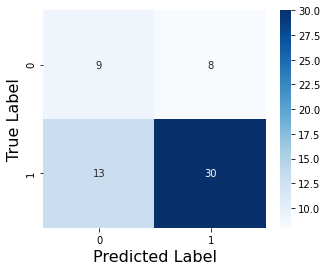

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	187
	Test:	66

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.115638
		Best Score:	0.6307254623044096
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.192224
		Best Score:	0.6840682788051209
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068076
		Best Score:	0.6466571834992888
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.408137
		Best Score:	0.6574679943100996
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.684
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.731
		0.735
		0.695
		0.691
		0.534
	Average:	0.677
	Model S

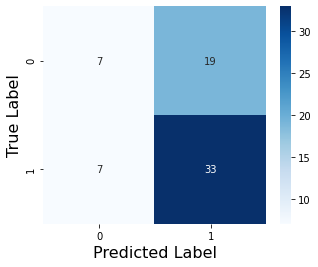

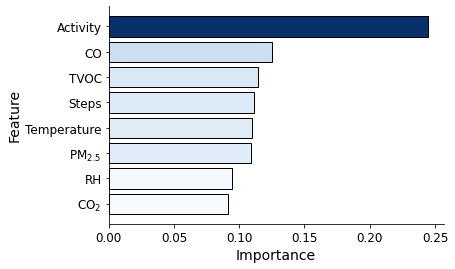

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.645
		0.702
		0.727
		0.655
		0.532
	Average:	0.652
	Model Score: 0.533
Evaluating...


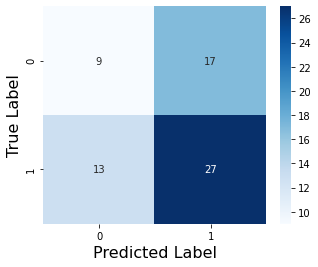

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.703
		0.64
		0.695
		0.643
		0.514
	Average:	0.639
	Model Score: 0.623
Evaluating...


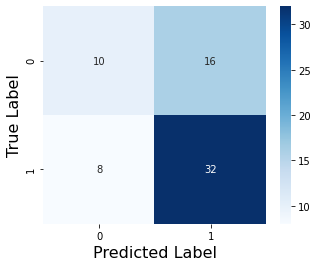

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.638
		0.64
		0.716
		0.632
		0.511
	Average:	0.628
	Model Score: 0.582
Evaluating...


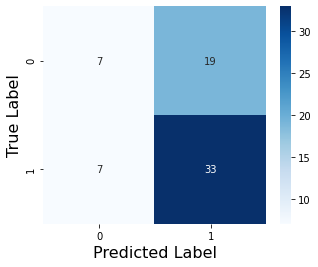

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	189
	Test:	64

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111243
		Best Score:	0.6132290184921764
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.458392
		Best Score:	0.6133712660028449
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065022
		Best Score:	0.5867709815078237
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.351446
		Best Score:	0.6031294452347085
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.613
		Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.719
		0.644
		0.571
		0.571
		0.536
	Average:	0.608
	Model Score

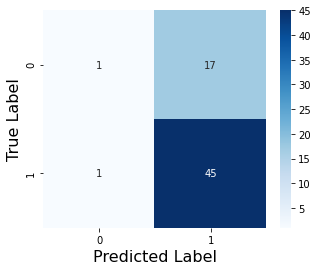

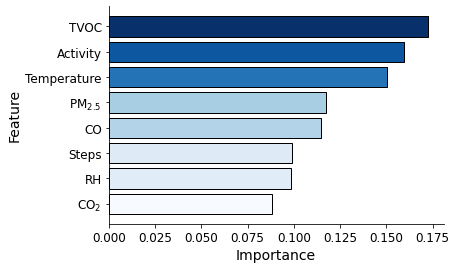

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.72
		0.491
		0.688
		0.616
		0.545
	Average:	0.612
	Model Score: 0.619
Evaluating...


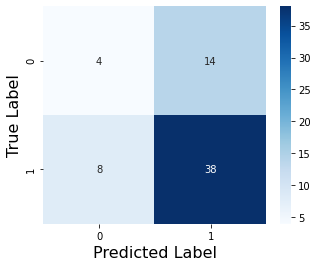

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.619
		0.616
		0.57
		0.561
		0.622
	Average:	0.597
	Model Score: 0.667
Evaluating...


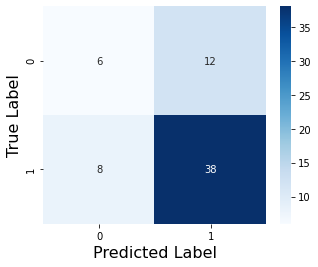

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.571
		0.771
		0.547
		0.65
		0.502
	Average:	0.608
	Model Score: 0.679
Evaluating...


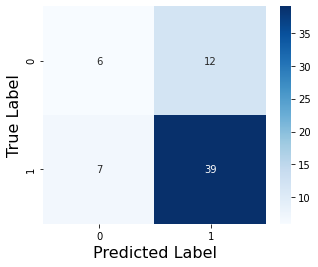

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
SPLIT 1
	Train:	190
	Test:	63

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111400
		Best Score:	0.5421052631578946
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:23.479731
		Best Score:	0.5157894736842105
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067510
		Best Score:	0.5421052631578948
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.366425
		Best Score:	0.4947368421052632
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Bernoulli Naive Bayes
		Score:	0.542
		Params:	{'alpha': 0}
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.526
		0.744
		0.5
		0.47
		0.501
	Average:	0.548
	Model Score: 0.563
Evaluating...


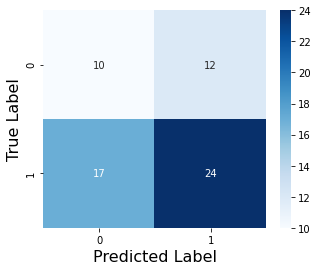

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.633
		0.596
		0.5
		0.47
		0.526
	Average:	0.545
	Model Score: 0.544
Evaluating...


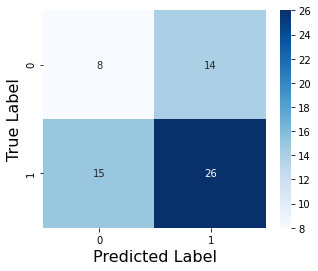

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.526
		0.5
		0.432
		0.474
		0.635
	Average:	0.513
	Model Score: 0.552
Evaluating...


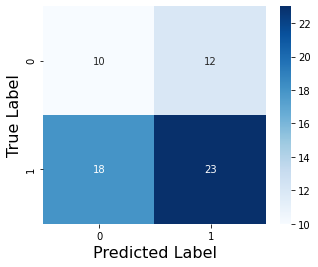

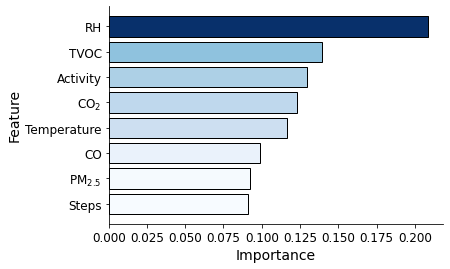

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.58
		0.42
		0.447
		0.452
		0.578
	Average:	0.495
	Model Score: 0.556
Evaluating...


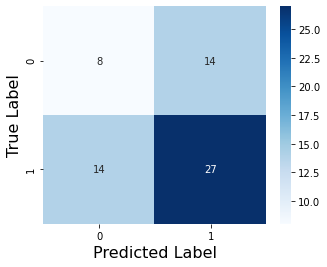

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	193
	Test:	60

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.159114
		Best Score:	0.4721997300944669
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:18.502133
		Best Score:	0.5342780026990555
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.069481
		Best Score:	0.4817813765182186
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.386761
		Best Score:	0.4882591093117409
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.534
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.584
		0.453
		0.477
		0.673
		0.517
	Average:	0.541
	Model 

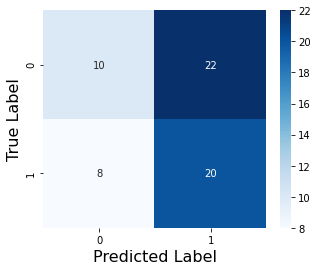

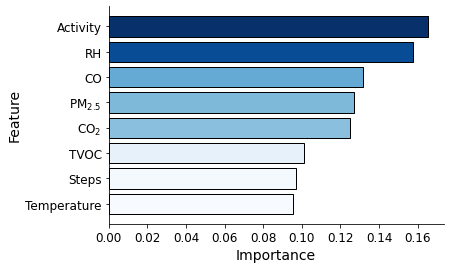

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.486
		0.436
		0.289
		0.682
		0.499
	Average:	0.478
	Model Score: 0.438
Evaluating...


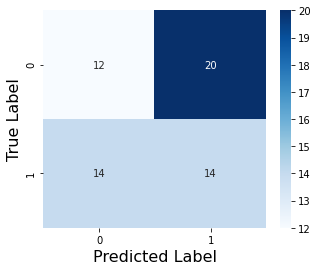

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.691
		0.488
		0.333
		0.486
		0.41
	Average:	0.482
	Model Score: 0.576
Evaluating...


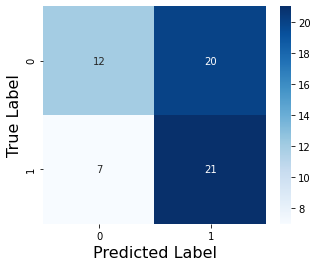

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.54
		0.396
		0.322
		0.502
		0.466
	Average:	0.445
	Model Score: 0.457
Evaluating...


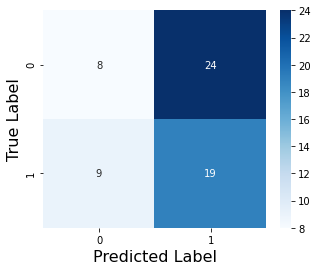

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	187
	Test:	66

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.134525
		Best Score:	0.49246088193456616
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.842797
		Best Score:	0.5295874822190612
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068505
		Best Score:	0.49203413940256036
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.376792
		Best Score:	0.486628733997155
		Best Params:	{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.53
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.779
		0.421
		0.517
		0.694
		0.431
	Average:	0.568
	Model Sco

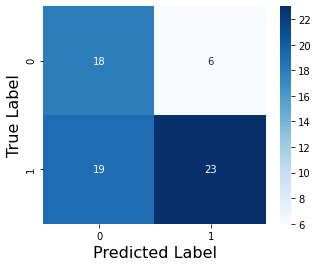

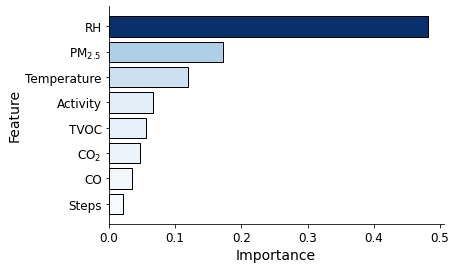

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.532
		0.37
		0.523
		0.595
		0.461
	Average:	0.496
	Model Score: 0.629
Evaluating...


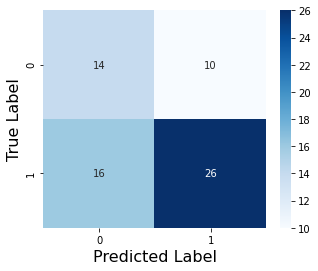

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.557
		0.423
		0.553
		0.54
		0.406
	Average:	0.496
	Model Score: 0.638
Evaluating...


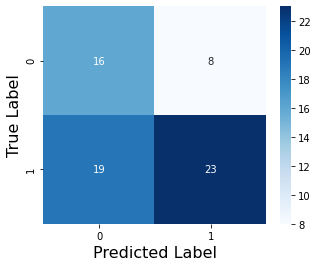

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.608
		0.363
		0.544
		0.404
		0.514
	Average:	0.487
	Model Score: 0.543
Evaluating...


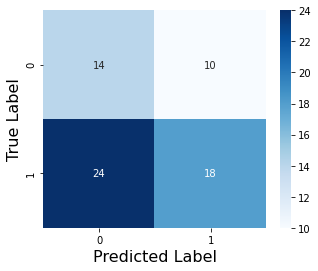

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	189
	Test:	64

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.119927
		Best Score:	0.5238975817923187
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:19.688643
		Best Score:	0.5766714082503557
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065564
		Best Score:	0.5399715504978663
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.416590
		Best Score:	0.5608819345661451
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.577
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.464
		0.673
		0.366
		0.515
	Average:	0.523
	Model Score

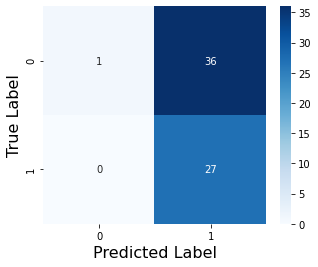

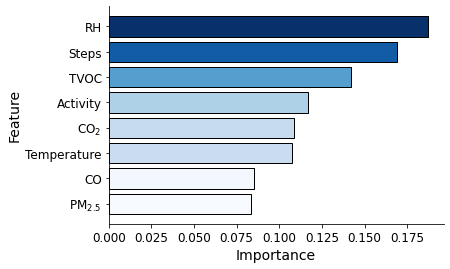

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.597
		0.359
		0.628
		0.525
		0.531
	Average:	0.528
	Model Score: 0.611
Evaluating...


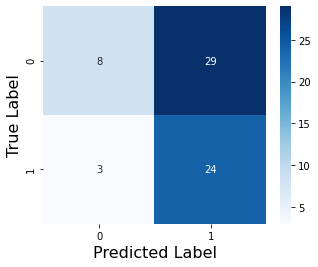

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.593
		0.387
		0.502
		0.36
		0.577
	Average:	0.484
	Model Score: 0.568
Evaluating...


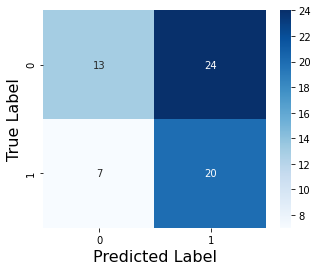

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.486
		0.482
		0.527
		0.525
		0.515
	Average:	0.507
	Model Score: 0.563
Evaluating...


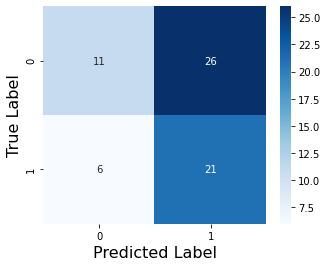

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
SPLIT 1
	Train:	190
	Test:	63

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117076
		Best Score:	0.4789473684210527
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:19.154072
		Best Score:	0.5157894736842106
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.109178
		Best Score:	0.4526315789473684
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.431093
		Best Score:	0.5
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.516
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.579
		0.575
		0.403
		0.413
		0.579
	Average

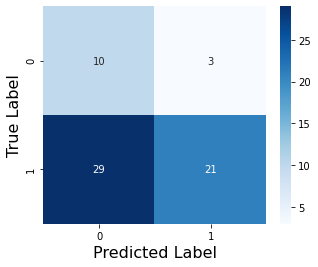

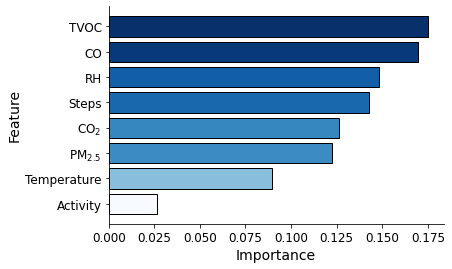

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.659
		0.51
		0.346
		0.326
		0.601
	Average:	0.489
	Model Score: 0.517
Evaluating...


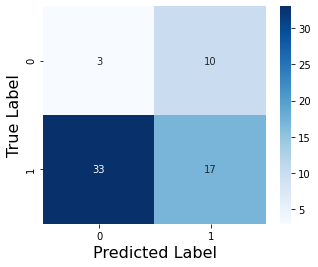

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.488
		0.411
		0.43
		0.45
		0.575
	Average:	0.471
	Model Score: 0.527
Evaluating...


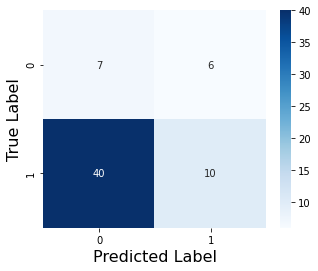

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.488
		0.462
		0.398
		0.427
		0.444
	Average:	0.444
	Model Score: 0.698
Evaluating...


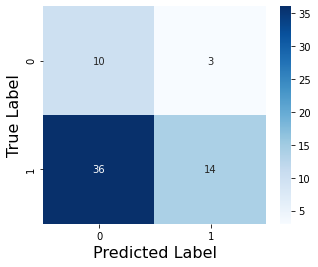

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	193
	Test:	60

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118294
		Best Score:	0.44561403508771924
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.528954
		Best Score:	0.5445344129554656
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065346
		Best Score:	0.45600539811066126
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.365714
		Best Score:	0.5187584345479082
		Best Params:	{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.545
		Params:	{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.379
		0.538
		0.543
		0.518
		0.718
	Average:	0.539
	Model Score: 0.5

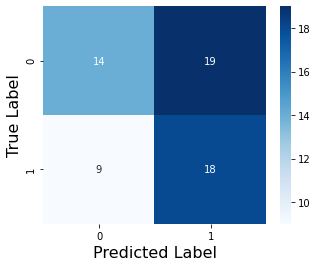

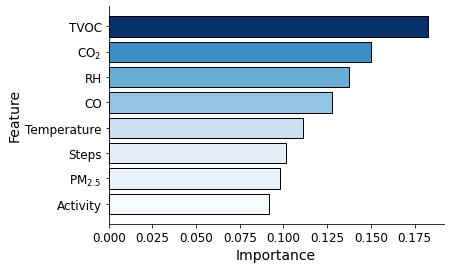

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.503
		0.53
		0.36
		0.474
		0.69
	Average:	0.511
	Model Score: 0.537
Evaluating...


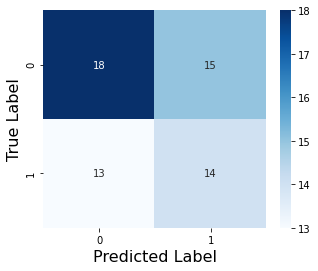

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.251
		0.487
		0.609
		0.474
		0.411
	Average:	0.446
	Model Score: 0.522
Evaluating...


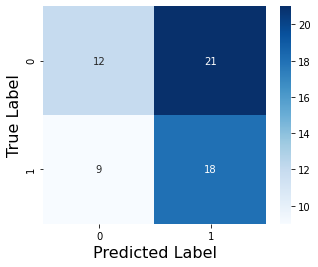

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.27
		0.51
		0.459
		0.395
		0.435
	Average:	0.414
	Model Score: 0.569
Evaluating...


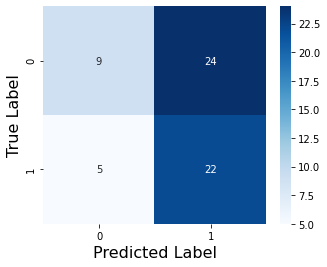

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	187
	Test:	66

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113272
		Best Score:	0.48719772403982925
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.315523
		Best Score:	0.5779516358463727
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.067881
		Best Score:	0.5079658605974395
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.389251
		Best Score:	0.5293029871977242
		Best Params:	{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.578
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.633
		0.446
		0.632
		0.573
		0.63
	Average:	0.583
	Model Score

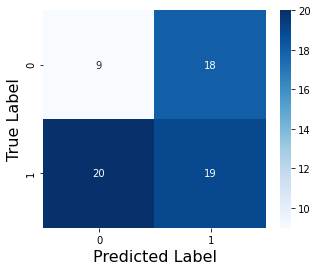

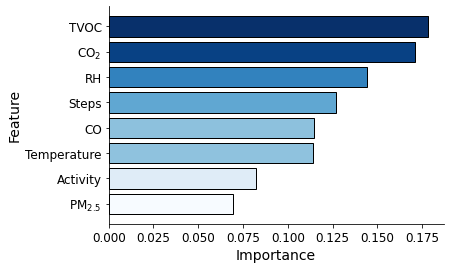

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.633
		0.451
		0.649
		0.379
		0.56
	Average:	0.534
	Model Score: 0.401
Evaluating...


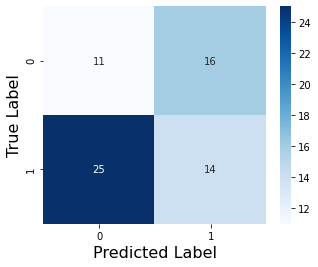

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.58
		0.451
		0.54
		0.489
		0.484
	Average:	0.509
	Model Score: 0.473
Evaluating...


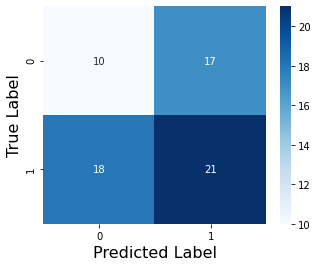

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.488
		0.363
		0.595
		0.461
		0.514
	Average:	0.484
	Model Score: 0.455
Evaluating...


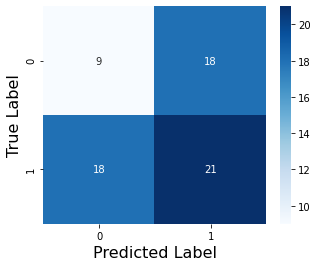

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	189
	Test:	64

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.130933
		Best Score:	0.5766714082503557
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.339337
		Best Score:	0.6135135135135135
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.071674
		Best Score:	0.5395448079658606
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.356436
		Best Score:	0.5502133712660028
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.614
		Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.599
		0.688
		0.366
		0.366
		0.373
	Average:	0.478
	Model Score

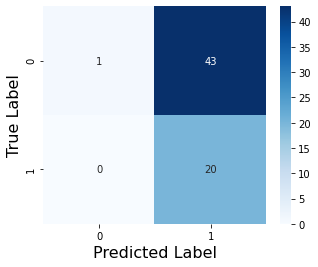

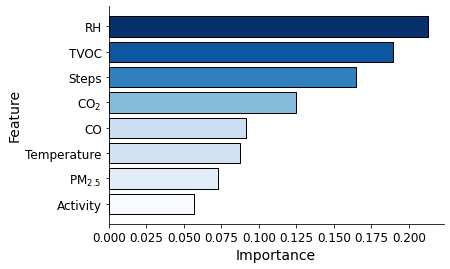

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.538
		0.66
		0.455
		0.346
		0.555
	Average:	0.511
	Model Score: 0.675
Evaluating...


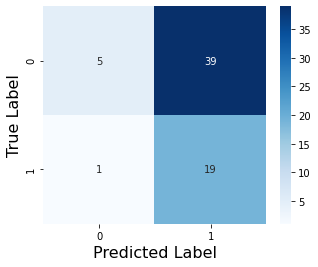

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.526
		0.616
		0.548
		0.526
		0.574
	Average:	0.558
	Model Score: 0.539
Evaluating...


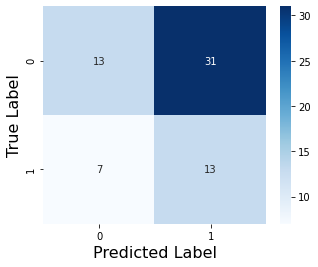

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.494
		0.551
		0.427
		0.491
		0.54
	Average:	0.501
	Model Score: 0.471
Evaluating...


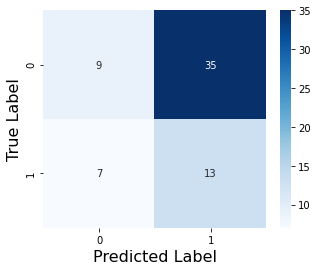

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
SPLIT 1
	Train:	190
	Test:	63

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113961
		Best Score:	0.8315789473684211
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.587563
		Best Score:	0.8368421052631578
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.075003
		Best Score:	0.8315789473684211
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.482767
		Best Score:	0.7842105263157894
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.837
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.709
		0.709
		0

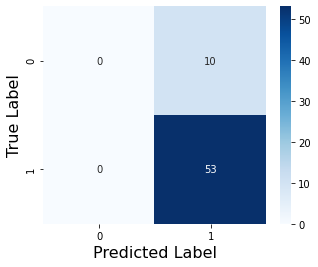

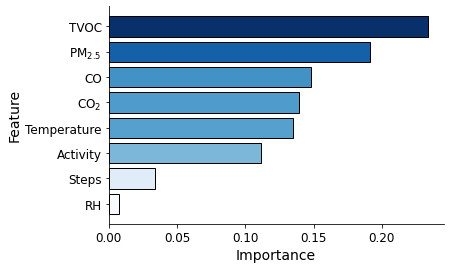

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.706
		0.709
		0.709
		0.709
		0.666
	Average:	0.7
	Model Score: 0.708
Evaluating...


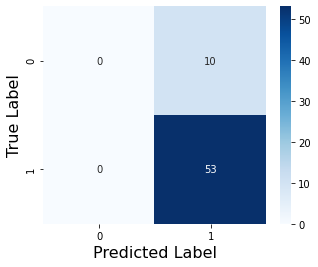

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.709
		0.709
		0.661
	Average:	0.7
	Model Score: 0.708
Evaluating...


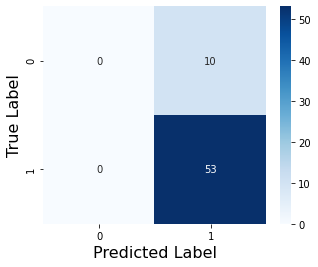

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.851
		0.774
		0.668
		0.709
		0.661
	Average:	0.733
	Model Score: 0.699
Evaluating...


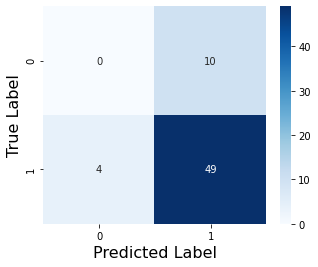

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	193
	Test:	60

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117004
		Best Score:	0.8290148448043185
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.135748
		Best Score:	0.8342780026990553
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065923
		Best Score:	0.8290148448043185
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.360445
		Best Score:	0.8082321187584345
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.834
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.716
		0.673
		0.673
		0.709
		0.709
	Average:	0.696
	Model Scor

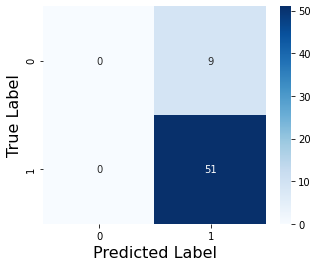

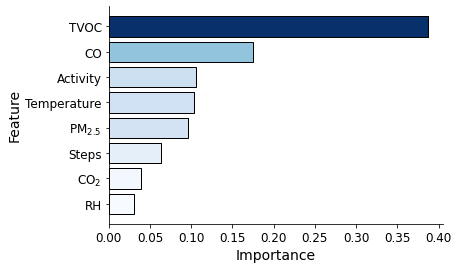

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.716
		0.673
		0.673
		0.709
		0.706
	Average:	0.695
	Model Score: 0.722
Evaluating...


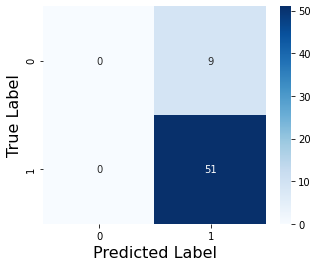

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.716
		0.673
		0.673
		0.709
		0.706
	Average:	0.695
	Model Score: 0.722
Evaluating...


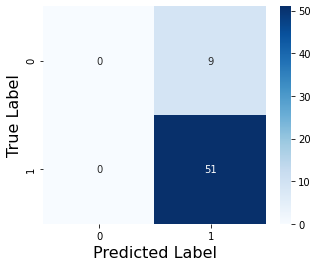

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.713
		0.673
		0.669
		0.702
		0.706
	Average:	0.692
	Model Score: 0.716
Evaluating...


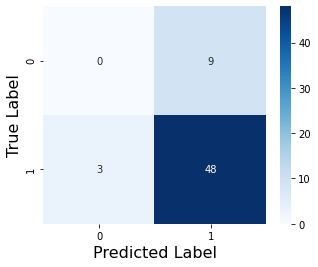

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	187
	Test:	66

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118767
		Best Score:	0.844950213371266
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.711174
		Best Score:	0.8503556187766714
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.078307
		Best Score:	0.844950213371266
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.362652
		Best Score:	0.8287339971550498
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.85
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.748
		0.748
		0.702
	Average:	0.723
	Model Score: 0.

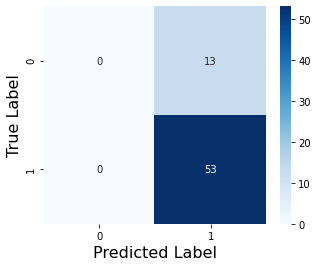

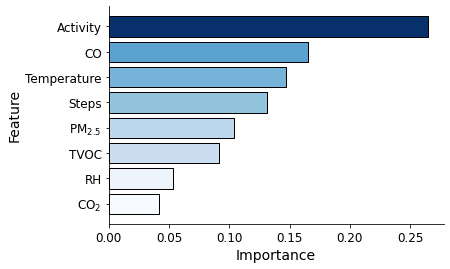

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.748
		0.748
		0.698
	Average:	0.722
	Model Score: 0.645
Evaluating...


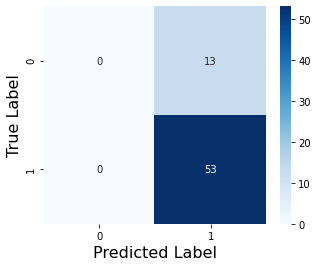

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.748
		0.748
		0.698
	Average:	0.722
	Model Score: 0.645
Evaluating...


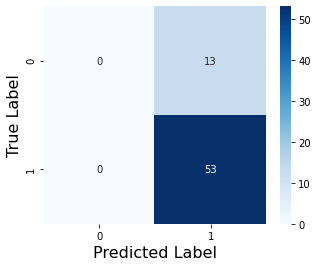

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.748
		0.734
		0.702
	Average:	0.72
	Model Score: 0.645
Evaluating...


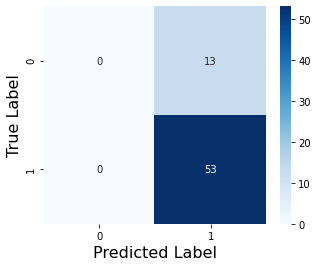

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	189
	Test:	64

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.136548
		Best Score:	0.8253200568990042
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.626162
		Best Score:	0.8307254623044097
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066118
		Best Score:	0.8253200568990042
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.358032
		Best Score:	0.8201991465149361
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.831
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.666
		0.666
		0.702
	Average:	0.69
	Model Score: 

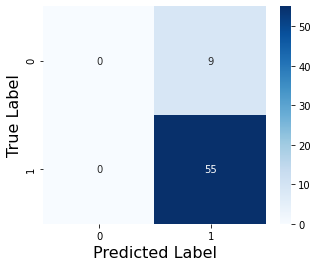

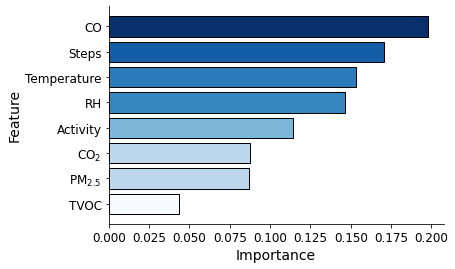

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.666
		0.666
		0.698
	Average:	0.69
	Model Score: 0.739
Evaluating...


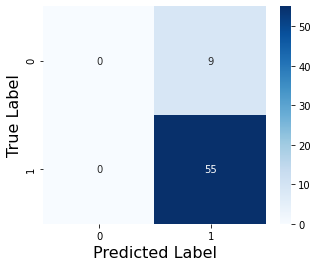

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.709
		0.666
		0.666
		0.698
	Average:	0.69
	Model Score: 0.739
Evaluating...


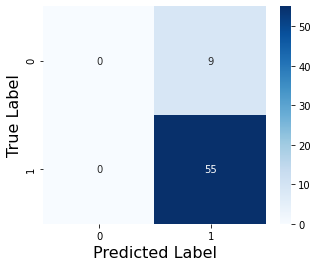

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.709
		0.706
		0.666
		0.661
		0.702
	Average:	0.689
	Model Score: 0.73
Evaluating...


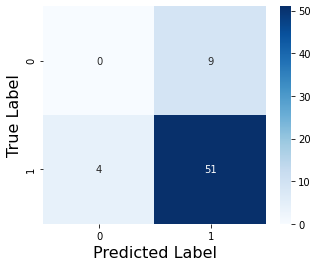

'KNeighborsClassifier' object has no attribute 'feature_importances_'


In [206]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut

group_pred = ieq_and_sq_prediction()

gkf = GroupKFold(n_splits=4)#len(test.features["count"].unique()))
res_group = {"split":[],"n_train":[],"n_test":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for target in targets: 
        group_pred.get_features_and_targets(ieq_and_activity,target_set,target)
        i = 1
        for train, test in gkf.split(group_pred.features, group_pred.targets, groups=group_pred.features["count"]):
            print("SPLIT", i)
            print(f"\tTrain:\t{len(train)}\n\tTest:\t{len(test)}\n")
            group_pred.set_test_and_train(group_pred.features.iloc[train,:],group_pred.features.iloc[test,:],group_pred.targets.iloc[train,:],group_pred.targets.iloc[test,:])
            group_pred.optimize_models()
            # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
            for model_number in range(len(group_pred.results)):
                print(group_pred.results.iloc[model_number,0].replace("_"," ").upper())
                group_pred.model = group_pred.classifier_model_params[group_pred.results.iloc[model_number,:]["model"]]["model"].set_params(**group_pred.results.iloc[model_number,:]["best_params"])
                group_pred.train_model(group_pred.model)
                group_pred.predict()
                group_pred.plot_confusion_matrix()
                group_pred.set_feature_importance(plot=True)

            res_group["split"].append(i)
            res_group["n_train"].append(len(train))
            res_group["n_test"].append(len(test))
            res_group["target"].append(target)
            res_group["best_performing_model"].append(group_pred.results.iloc[0,0])
            res_group["model_score"].append(group_pred.results.iloc[0,1])
            bs = sum(group_pred.targets.values)/len(group_pred.targets)
            res_group["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            try:
                res_group["sensitive_parameter1"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                res_group["sensitive_parameter2"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                res_group["sensitive_parameter1"].append(np.nan)
                res_group["sensitive_parameter2"].append(np.nan)

            i += 1

In [207]:
group_res_df = pd.DataFrame(res_group)
group_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-groups-results.csv")

## Summary of Prediction Models
Now we look more in-depth at the different prediction models.

In [81]:
def plot_hist(var):
    """plots histogram of variable"""
    fig, axes = plt.subplots(1,3,figsize=(21,4))
    for data, title, ax in zip([agg_res_df,ind_res_df,group_res_df],["aggregated","per participant","grouped"],axes.flat):
        data.sort_values(var,inplace=True)
        sns.histplot(x=var,data=data, shrink=0.8, stat="probability", color="cornflowerblue", discrete=True, linewidth=2, ax=ax)
        # y-axis
        ax.set_ylim([0,1])
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title.title())
        
        ax.tick_params("x",rotation=-15,labelsize=10)
    plt.show()
    plt.close()

### Hyperparameter Tuning
Included in the results are the hyperparameters that produced the greatest score per model. We can summarize those here.

In [97]:
from collections import defaultdict
res = agg_res_df
for m in res["model"].unique():
    print(m)
    dd = defaultdict(list)
    res_by_model = res[res["model"] == m]
    for d in res_by_model["hyper_parameters"]: # you can list as many input dicts as you want here
        for key, value in d.items():
            dd[key].append(value)
    print(pd.DataFrame(dd))

logistic_regression
   fit_intercept     solver
0           True      lbfgs
1           True      lbfgs
2          False      lbfgs
3           True      lbfgs
4           True      lbfgs
5          False      lbfgs
6           True  liblinear
7           True      lbfgs
8           True      lbfgs
random_forest
   max_depth  min_samples_leaf  min_samples_split  n_estimators
0          2                 1                  2            10
1          2                 1                  2            10
2          2                 1                  2            50
3          4                 1                  4           100
4          2                 1                  2            10
5          3                 1                  2            50
6          2                 1                  2           100
7          4                 1                  4            10
8          2                 1                  2            10
bernoulli_naive_bayes
   alpha
0    0.0
1    0

The following hyperparameters should be used:
* **Logistic Regression**: (fit_intercpt=True,solver="lbfgs")
* **Random Forest**: (max_depth=2,min_samples_leaf=1,min_samples_split=2,n_esimators=10)
* **Naive Bayes**: (alpha=0.0)
* **KNN**: (n_neighbors=7,p=1,weights=uniform)

### Best Performing Model
We take a look at the model that tended to produce the best score.

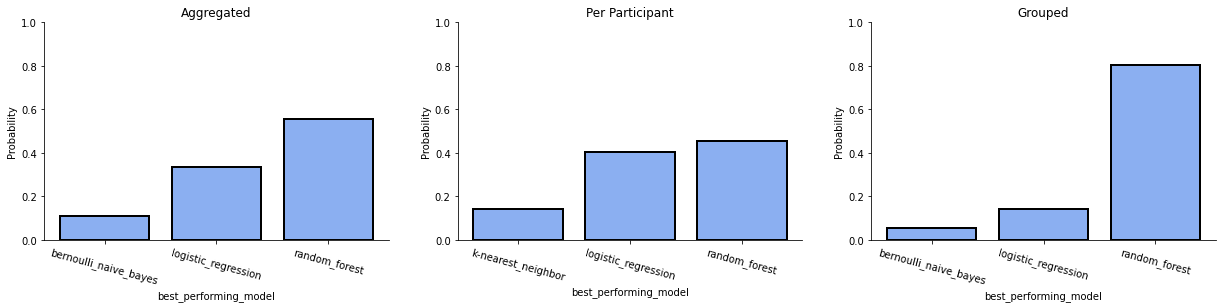

In [127]:
plot_hist("best_performing_model")

#### Winner
In all three cases, the **Random Forest Model** produced the highest scores, on average, compared to the other three.

#### Loser(s)
* **KNN** only showed up a few times in the per participant procedure but not in either of the other two procedures
* **Naive-Bayes** showed the opposite behavior: showing up in only the first and third procedures despite being better equiped to handle smaller datasets which was the case for the per participant procedure.

### Variable Contribution
We can also look at which variable tended to be the most useful in the model development.

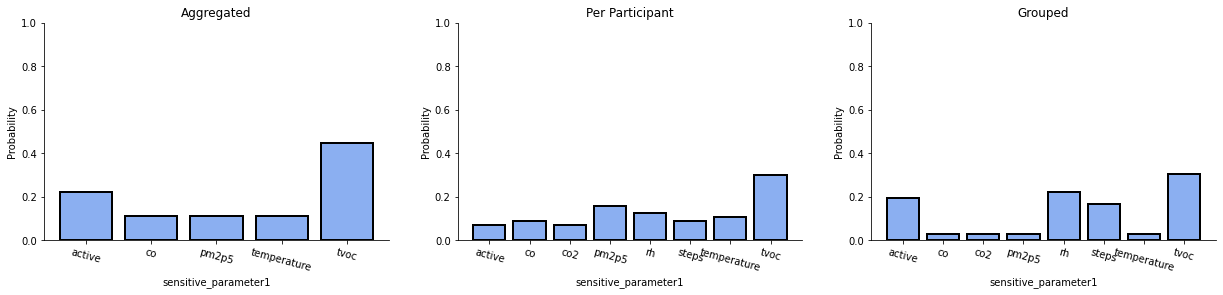

In [128]:
plot_hist("sensitive_parameter1")

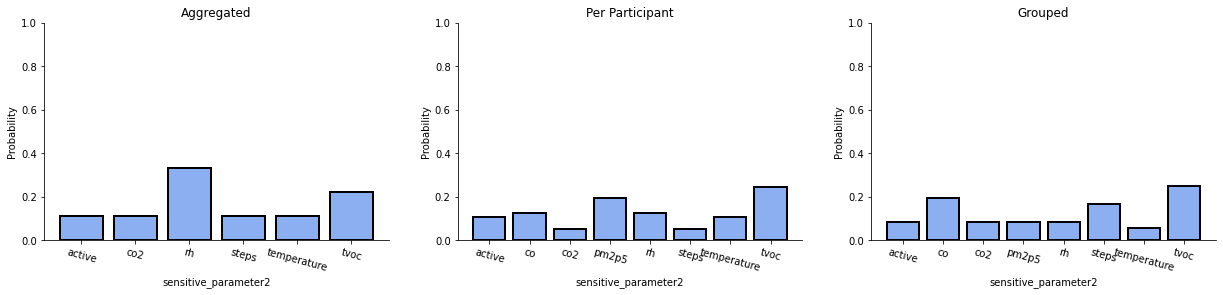

In [129]:
plot_hist("sensitive_parameter2")

#### Winner
**TVOCs** are the only variable that shows a consistent effect on the model development whether that be the first or second most influential parameter. 

#### Per Participant
* **PM2.5** seems to affect this procedure more so than the either two

#### Grouped
* **Activity** seems to have a somewhat large effect especially when considering the **steps** variable in conjunction

### Comparing Scores
We can look at the model scores compared to the "biased" score to see how well our models performed.

In [169]:
def plot_bar():
    """plots histogram of variable"""
    fig, axes = plt.subplots(1,3,figsize=(21,4))
    for data, title, ax in zip([agg_res_df,ind_res_df,group_res_df],["aggregated","per participant","grouped"],axes.flat):
        df_to_plot = pd.melt(data,id_vars=["target"],value_vars=["model_score","biased_score"])
        sns.barplot(x="target",y="value",hue="variable",data=df_to_plot, hue_order=["biased_score","model_score"],palette=["gray","seagreen"], edgecolor="black",linewidth=2, ax=ax)
        # y-axis
        ax.set_ylim([0,1])
        ax.set_ylabel("Score")
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title.title())
        ax.legend(loc="lower left",framealpha=1)
        
        ax.tick_params("x",rotation=-15,labelsize=10)
    plt.show()
    plt.close()

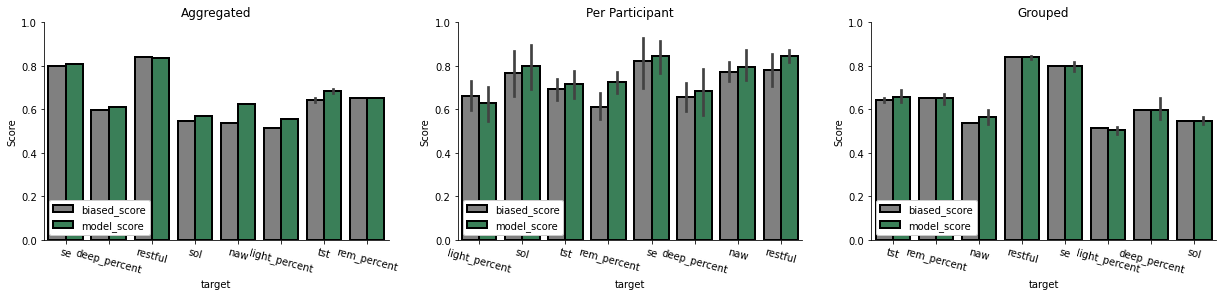

In [170]:
plot_bar()

#### Aggregated
In all cases but `restful` and `rem_percent`, the model out-performed the biased score most noteably for:
* `naw`
* `light_percent`

#### Per Participant
On average, the models were able to out-perform the biased score except in the case of `light_percent`, most notably:
* `rem_percent`
* `restful`

#### Grouped
The worst-performing procedure where the majority of the scores are similar between the biased and model performance. Only the estimation of `naw` seems to be signficiantly different.

### Aggregate: Deep Dive

In [185]:
agg_res_df["dScore"] = agg_res_df["model_score"] - agg_res_df["biased_score"]
agg_res_df.sort_values("dScore",ascending=False)

target  best_performing_model  model_score  biased_score  \
7            naw          random_forest     0.621747      0.537549   
5            tst          random_forest     0.693048      0.632411   
2  light_percent          random_forest     0.552941      0.513780   
6            sol  bernoulli_naive_bayes     0.568627      0.545455   
1            tst          random_forest     0.676471      0.653543   
3   deep_percent          random_forest     0.611765      0.596457   
0             se    logistic_regression     0.805882      0.797244   
4    rem_percent    logistic_regression     0.650000      0.649606   
8        restful    logistic_regression     0.834403      0.837945   

  sensitive_parameter1 sensitive_parameter2    dScore  
7                 tvoc                   rh  0.084197  
5               active                 tvoc  0.060637  
2                 tvoc                steps  0.039162  
6                 tvoc                   rh  0.023173  
1               active          temperature  0.022927  
3                 tvoc                  co2  0.015308  
0                pm2p5               active  0.008638  
4                   co                 tvoc  0.000394  
8          temperature                   rh -0.003542

Using this procedure, we are able to see noticeable differences in the scores between `naw` and `tst` targets.

### Per Participant: Deep Dive

In [188]:
ind_res_df["dScore"] = ind_res_df["model_score"] - ind_res_df["biased_score"]
ind_res_df.groupby("target").mean().sort_values("dScore", ascending=False)

n  model_score  biased_score    dScore
target                                                       
rem_percent    42.714286     0.724104      0.607881  0.116223
restful        26.000000     0.845000      0.779365  0.065635
sol            25.333333     0.797222      0.767169  0.030053
tst            34.500000     0.718152      0.692079  0.026073
se             42.714286     0.845669      0.820283  0.025386
deep_percent   42.714286     0.682880      0.657898  0.024982
naw            26.400000     0.793333      0.773386  0.019948
light_percent  42.714286     0.628526      0.659262 -0.030736

By looking at the mean difference in the scores across the participants sleep targets, we can predict `rem_percent` and `restful` more accurately than a biased score. 

In [202]:
high_scoring_ind = ind_res_df.sort_values("dScore",ascending=False)[ind_res_df["dScore"] > 0.05]
high_scoring_ind

beiwe   n         target best_performing_model  model_score  \
35  tlmlq19s  68    rem_percent         random_forest     0.711111   
14  qh34m4r9  45    rem_percent         random_forest     0.700000   
46  lkkjddam  28        restful         random_forest     0.833333   
43  lkkjddam  28            tst         random_forest     0.783333   
19  lkkjddam  51    rem_percent         random_forest     0.680952   
5   itmylz3g  31             se         random_forest     0.800000   
15  lkkjddam  51             se         random_forest     0.628571   
47  awa8uces  20            tst   logistic_regression     0.866667   
36  9jtzsuu8  20            tst         random_forest     0.766667   
49  awa8uces  20        restful         random_forest     0.866667   
24  vr9j5rry  32    rem_percent         random_forest     0.800000   
13  qh34m4r9  45   deep_percent         random_forest     0.800000   
9   itmylz3g  31    rem_percent   logistic_regression     0.750000   
28  tmexej5v  39  light_percent    k-nearest_neighbor     0.653333   
11  qh34m4r9  45            tst         random_forest     0.800000   
38  9jtzsuu8  20            naw         random_forest     0.933333   
25  awa8uces  32            tst   logistic_regression     0.670000   
51  tmexej5v  22            sol         random_forest     0.933333   
30  tmexej5v  39    rem_percent         random_forest     0.606667   
48  awa8uces  20            sol   logistic_regression     0.866667   
3   kyj367pi  33   deep_percent         random_forest     0.820000   
4   kyj367pi  33    rem_percent   logistic_regression     0.820000   
29  tmexej5v  39   deep_percent   logistic_regression     0.846667   
8   itmylz3g  31   deep_percent   logistic_regression     0.600000   
50  tmexej5v  22            tst    k-nearest_neighbor     0.733333   

    biased_score sensitive_parameter1 sensitive_parameter2    dScore  
35      0.544118                pm2p5                   co  0.166993  
14      0.533333                steps          temperature  0.166667  
46      0.678571          temperature                   rh  0.154762  
43      0.642857          temperature                steps  0.140476  
19      0.549020                steps               active  0.131933  
5       0.677419                   co                 tvoc  0.122581  
15      0.509804                pm2p5                steps  0.118768  
47      0.750000                 tvoc               active  0.116667  
36      0.650000                   co                pm2p5  0.116667  
49      0.750000                pm2p5                 tvoc  0.116667  
24      0.687500                pm2p5                 tvoc  0.112500  
13      0.688889                pm2p5                  co2  0.111111  
9       0.645161                 tvoc                pm2p5  0.104839  
28      0.564103                   rh                 tvoc  0.089231  
11      0.711111               active                   co  0.088889  
38      0.850000                 tvoc          temperature  0.083333  
25      0.593750          temperature                 tvoc  0.076250  
51      0.863636                  co2          temperature  0.069697  
30      0.538462                   co                pm2p5  0.068205  
48      0.800000                 tvoc                pm2p5  0.066667  
3       0.757576                steps                 tvoc  0.062424  
4       0.757576                pm2p5               active  0.062424  
29      0.794872                 tvoc                   rh  0.051795  
8       0.548387                 tvoc                   co  0.051613  
50      0.681818                 tvoc          temperature  0.051515

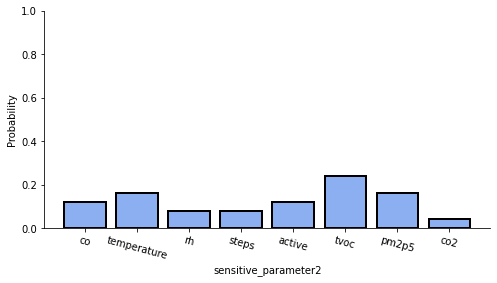

In [201]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(x="sensitive_parameter2",data=high_scoring_ind, shrink=0.8, stat="probability", color="cornflowerblue", discrete=True, linewidth=2, ax=ax)
# y-axis
ax.set_ylim([0,1])
# remainder
for loc in ["top","right"]:
    ax.spines[loc].set_visible(False)

ax.tick_params("x",rotation=-15,labelsize=10)
plt.show()
plt.close()

By looking at the top scoring models, we can see they are primarily:
* random forest (and even those that are logistic regression might have scores equal to random forest but were selected since they came first)
* `rem_percent`
* sensitive to `pm2p5`, `temperature`, and `tvoc`

### Grouped: Deep Dive

In [215]:
group_res_df["dScore"] = group_res_df["model_score"] - group_res_df["biased_score"]
group_res_df.sort_values(["split","dScore"],ascending=False)
#group_res_df.groupby(["split","target"]).mean()

split  n_train  n_test         target  best_performing_model  model_score  \
31      4      189      64            naw          random_forest     0.613514   
7       4      382     126            tst          random_forest     0.701572   
27      4      189      64            sol          random_forest     0.576671   
19      4      382     126    rem_percent          random_forest     0.675393   
11      4      382     126  light_percent    logistic_regression     0.528640   
35      4      189      64        restful          random_forest     0.830725   
23      4      189      64            tst          random_forest     0.613371   
3       4      382     126             se          random_forest     0.759193   
15      4      382     126   deep_percent          random_forest     0.544532   
22      3      187      66            tst          random_forest     0.684068   
30      3      187      66            naw          random_forest     0.577952   
2       3      380     128             se    logistic_regression     0.818421   
34      3      187      66        restful          random_forest     0.850356   
18      3      380     128    rem_percent          random_forest     0.660526   
6       3      380     128            tst          random_forest     0.657895   
10      3      380     128  light_percent          random_forest     0.510526   
14      3      380     128   deep_percent          random_forest     0.584211   
26      3      187      66            sol          random_forest     0.529587   
13      2      381     127   deep_percent          random_forest     0.677204   
29      2      193      60            naw          random_forest     0.544534   
1       2      381     127             se    logistic_regression     0.797915   
33      2      193      60        restful          random_forest     0.834278   
5       2      381     127            tst          random_forest     0.648291   
21      2      193      60            tst          random_forest     0.622132   
25      2      193      60            sol          random_forest     0.534278   
9       2      381     127  light_percent          random_forest     0.490738   
17      2      381     127    rem_percent          random_forest     0.614183   
20      1      190      63            tst  bernoulli_naive_bayes     0.726316   
0       1      381     127             se    logistic_regression     0.813671   
32      1      190      63        restful          random_forest     0.836842   
16      1      381     127    rem_percent          random_forest     0.648291   
24      1      190      63            sol  bernoulli_naive_bayes     0.542105   
12      1      381     127   deep_percent          random_forest     0.582638   
28      1      190      63            naw          random_forest     0.515789   
8       1      381     127  light_percent    logistic_regression     0.482946   
4       1      381     127            tst          random_forest     0.611552   

    biased_score sensitive_parameter1 sensitive_parameter2    dScore  
31      0.537549                   rh                 tvoc  0.075964  
7       0.653543                steps                pm2p5  0.048029  
27      0.545455                   rh                steps  0.031217  
19      0.649606                 tvoc               active  0.025787  
11      0.513780                 tvoc                steps  0.014860  
35      0.837945                   co                steps -0.007219  
23      0.632411                 tvoc               active -0.019040  
3       0.797244                steps                   rh -0.038051  
15      0.596457               active                  co2 -0.051925  
22      0.632411               active                   co  0.051657  
30      0.537549                 tvoc                  co2  0.040402  
2       0.797244                   rh          temperature  0.021177  
34      0.837945               active                   co  0.012411  
18      0.64

There seem to be significant differences in the performance of the models based on the splits.

Leave One Group Out

Stratified K-Fold

In [ ]:
dd